# Radiomics Analysis of High & Low Ki-67 Subgroups 

## Data Source: The Cancer Imaging Archive - Adrenal-ACC-Ki67-Seg | Voxel-level segmentation of pathologically-proven Adrenocortical carcinoma with Ki-67 expression 

In RStudio, I used the available clinical data to quartile and segment the samples into 'high Ki-67' (n = 13) and 'low Ki-67' (n = 13) subgroups. R-code for this process is on Github. I then proceeded to download the images and segmentations for these samples and will now convert them to Nifti format and carry out PyRadiomics Batch processing on them to extract radiomic features for both subgroups. Statistically significant radiomic features will then be compared in both subgroups, thus characterising the radiomic landscape of both high and low Ki-67 ACC subgroups.

First, in shell, download the required libraries:

pip install DicomRTTool SimpleITK pandas numpy matplotlib pyradiomics
sudo apt-get install dcm2niix

Also, visualised each sample using 3DSlicer to determine which imaging files that the segmentation corressponds to for each sample and noted this.

In [1]:
# Importing necessary libraries
import os
import glob
import SimpleITK as sitk
from DicomRTTool.ReaderWriter import DicomReaderWriter
import subprocess
import pydicom
import radiomics
from radiomics import featureextractor
import logging
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.api as sm
import statsmodels.stats.multitest as multitest
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
import scipy.stats as stats
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

In [3]:
# Converting "high_ki67" DICOM files to Nifti use dcm2niix:
def convert_dicom_to_nifti(dicom_root_path, nifti_output_path):
    if not os.path.exists(nifti_output_path):
        os.makedirs(nifti_output_path)

    for root, dirs, files in os.walk(dicom_root_path):
        for dir_name in dirs:
            dicom_path = os.path.join(root, dir_name)
            sub_nifti_output_path = os.path.join(nifti_output_path, dir_name)
            if not os.path.exists(sub_nifti_output_path):
                os.makedirs(sub_nifti_output_path)

            # Using dcm2niix solely on regular imaging files
            command = f'dcm2niix -o "{sub_nifti_output_path}" "{dicom_path}"'
            try:
                subprocess.run(command, shell=True, check=True)
                print(f'Converted DICOM files in {dicom_path} to NIfTI format at {sub_nifti_output_path}.')
            except subprocess.CalledProcessError as e:
                print(f'Error converting {dicom_path} with dcm2niix: {e}')
                continue

# Paths to DICOM and NIfTI directories
base_path = '/media/evannaughton/STORE N GO/project/tcia_data'
high_dicom_path = os.path.join(base_path, 'high_ki67')
high_nifti_output_path = os.path.join(base_path, 'high_ki67_nifti')

# Convert High Group DICOM to NIfTI
convert_dicom_to_nifti(high_dicom_path, high_nifti_output_path)

In [ ]:
# Converting "low_ki67" DICOM files to Nifti use dcm2niix:
# Paths to DICOM and NIfTI directories
low_dicom_path = os.path.join(base_path, 'low_ki67')
low_nifti_output_path = os.path.join(base_path, 'low_ki67_nifti')

# Convert Low Group DICOM to NIfTI
convert_dicom_to_nifti(low_dicom_path, low_nifti_output_path)

In [6]:
# Re-running to add in a sample that I missed in the low group previously (11/06/2024)

# Input and output directories
input_dir = '/media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029'
output_dir = '/media/evannaughton/STORE N GO/project/tcia_data/low_ki67_nifti/Adrenal_Ki67_Seg_029'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Convert DICOM to Nifti
convert_dicom_to_nifti(input_dir, output_dir)

print(f'DICOM files from {input_dir} have been converted to Nifti format and saved in {output_dir}')

Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 350 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476/300.000000-Segmentation-33016/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 186 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/low_ki67_nifti/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029_ABD_ROUTINE_20070619152508_2 (512x512x186x1)
Convert 163 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/low_ki67_nifti/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029_ABD_ROUTINE_20070619152508_6 (512x512x163x1)


Error: Converted 349 of 350 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/low_ki67_nifti/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029" "/media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 350 DICOM file(s)
Skipping non-image DICOM: /media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476/300.000000-Segmentation-33016/1-1.dcm
Unsupported DICOM bit-depth 1 with 1 samples per pixel
Convert 186 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/low_ki67_nifti/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476/06-19-2007-NA-Abdomen-26476_ABD_ROUTINE_20070619152508_2 (512x512x186x1)
Convert 163 DICOM as /media/eva

Error: Converted 349 of 350 files


Error converting /media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476 with dcm2niix: Command 'dcm2niix -o "/media/evannaughton/STORE N GO/project/tcia_data/low_ki67_nifti/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476" "/media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476"' returned non-zero exit status 8.
Chris Rorden's dcm2niiX version v1.0.20211006  (JP2:OpenJPEG) GCC11.2.0 x86-64 (64-bit Linux)
Found 186 DICOM file(s)
Convert 186 DICOM as /media/evannaughton/STORE N GO/project/tcia_data/low_ki67_nifti/Adrenal_Ki67_Seg_029/2.000000-Abdomen 3mm-65727/2.000000-Abdomen_3mm-65727_ABD_ROUTINE_20070619152508_2 (512x512x186x1)


KeyboardInterrupt: 

The codes above tended to overloop so I just interuppted the kernel after each group of samples ran and I obtained my Nifti files.

In [7]:
# Converting segmentation files to nifti
def convert_segmentation_files(dicom_root_path, nifti_output_path):
    if not os.path.exists(nifti_output_path):
        os.makedirs(nifti_output_path)

    for root, dirs, files in os.walk(dicom_root_path):
        for dir_name in dirs:
            dicom_path = os.path.join(root, dir_name)
            sub_nifti_output_path = os.path.join(nifti_output_path, dir_name)
            if not os.path.exists(sub_nifti_output_path):
                os.makedirs(sub_nifti_output_path)

            for file_name in os.listdir(dicom_path):
                file_path = os.path.join(dicom_path, file_name)
                try:
                    ds = pydicom.dcmread(file_path)
                    if hasattr(ds, 'Modality') and ds.Modality == 'SEG':
                        seg_sitk_image = sitk.ReadImage(file_path)
                        seg_nifti_file = os.path.join(sub_nifti_output_path, f"{dir_name}_{file_name.replace('.dcm', '.nii.gz')}")
                        sitk.WriteImage(seg_sitk_image, seg_nifti_file)
                        print(f'Converted segmentation DICOM {file_path} to NIfTI format at {seg_nifti_file}.')
                except Exception as e:
                    print(f'Could not read file {file_path}: {e}')

# Paths to DICOM and NIfTI directories
high_dicom_path = os.path.join(base_path, 'high_ki67')
low_dicom_path = os.path.join(base_path, 'low_ki67')
high_nifti_output_path = os.path.join(base_path, 'high_ki67_nifti')
low_nifti_output_path = os.path.join(base_path, 'low_ki67_nifti')

# Convert High Group Segmentation Files
convert_segmentation_files(high_dicom_path, high_nifti_output_path)

# Convert Low Group Segmentation Files
convert_segmentation_files(low_dicom_path, low_nifti_output_path)

In [8]:
# Doing the same for the new sample in the low group (Adrenal_29)

convert_segmentation_files(input_dir, output_dir)

print(f'Segmentation files from {input_dir} have been converted to Nifti format and saved in {output_dir}')

Could not read file /media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476/2.000000-Abdomen 3mm-65727: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476/2.000000-Abdomen 3mm-65727'
Could not read file /media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476/300.000000-Segmentation-33016: [Errno 21] Is a directory: '/media/evannaughton/STORE N GO/project/tcia_data/low_ki67/Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029/06-19-2007-NA-Abdomen-26476

After this runs, remove unwanted folders produced and sort each segmentation to its associated sample.

After matching each segmentation file with its associated sample and removing unwanted folders, we can proceed with the extraction of radiomic features from each group of samples. 

To do this we need to create a Params.yaml File with our intended parameters for PyRadiomics to run, and load it in.
The Params file was taken from the PyRadiomics Github page and its parameters are specific for CT image analysis. This file was further modified to capture additional LoG Sigma values (1.0, 2.0 and 3.0) and additional feature classes (e.g. ngtdm).

Before carrying out PyRadiomics Batch on all samples, I wish to perform sanity checks on the nifti files I produced in order to validate them. I will also extract features from a single sample to ensure that they are in the correct format for analysis.

In [9]:
# Checking to see if the files are valid for radiomics analysis 
def check_nifti_file(file_path):
    try:
        image = sitk.ReadImage(file_path)
        print(f"File {file_path} is valid. Dimensions: {image.GetSize()}")
        return image
    except Exception as e:
        print(f"File {file_path} is invalid: {e}")
        return None

# Paths to check
high_nifti_path = '/media/evannaughton/STORE N GO/project/tcia_data/high_ki67_nifti'
low_nifti_path = '/media/evannaughton/STORE N GO/project/tcia_data/low_ki67_nifti'

# High Ki67 sample
high_sample_path = os.path.join(high_nifti_path, 'Adrenal_Ki67_Seg_012')
high_image_file = os.path.join(high_sample_path, 'Adrenal_Ki67_Seg_012_7.18_@_ANGIOGRAM_VENOGRAM_@_20060805203016_3.nii')
high_seg_file = os.path.join(high_sample_path, '300.000000-Segmentation-00566', '1-1.nii.gz')

# Low Ki67 sample
low_sample_path = os.path.join(low_nifti_path, 'Adrenal_Ki67_Seg_005')
low_image_file = os.path.join(low_sample_path, 'Adrenal_Ki67_Seg_005_6.8_@_CAP_ADRENAL_@_20050104180841_3.nii')
low_seg_file = os.path.join(low_sample_path, '300.000000-Segmentation-00816', '1-1.nii.gz')

print("Checking high Ki67 image file:")
check_nifti_file(high_image_file)
print("\nChecking high Ki67 segmentation file:")
check_nifti_file(high_seg_file)

print("\nChecking low Ki67 image file:")
check_nifti_file(low_image_file)
print("\nChecking low Ki67 segmentation file:")
check_nifti_file(low_seg_file)


Checking high Ki67 image file:
File /media/evannaughton/STORE N GO/project/tcia_data/high_ki67_nifti/Adrenal_Ki67_Seg_012/Adrenal_Ki67_Seg_012_7.18_@_ANGIOGRAM_VENOGRAM_@_20060805203016_3.nii is valid. Dimensions: (512, 512, 117)

Checking high Ki67 segmentation file:
File /media/evannaughton/STORE N GO/project/tcia_data/high_ki67_nifti/Adrenal_Ki67_Seg_012/300.000000-Segmentation-00566/1-1.nii.gz is valid. Dimensions: (512, 512, 769)

Checking low Ki67 image file:
File /media/evannaughton/STORE N GO/project/tcia_data/low_ki67_nifti/Adrenal_Ki67_Seg_005/Adrenal_Ki67_Seg_005_6.8_@_CAP_ADRENAL_@_20050104180841_3.nii is valid. Dimensions: (512, 512, 105)

Checking low Ki67 segmentation file:
File /media/evannaughton/STORE N GO/project/tcia_data/low_ki67_nifti/Adrenal_Ki67_Seg_005/300.000000-Segmentation-00816/1-1.nii.gz is valid. Dimensions: (512, 512, 121)


<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7459624acd50> >

In [ ]:
# extracting radiomic features from a single sample:
# Verifying that the images are in the correct format

# Define the paths to files
image_path1 = '/media/evannaughton/STORE N GO/project/tcia_data/high_ki67_nifti/Adrenal_Ki67_Seg_012/Adrenal_Ki67_Seg_012_7.18_@_ANGIOGRAM_VENOGRAM_@_20060805203016_3.nii'
image_path2 = '/media/evannaughton/STORE N GO/project/tcia_data/high_ki67_nifti/Adrenal_Ki67_Seg_012/Adrenal_Ki67_Seg_012_7.18_@_ANGIOGRAM_VENOGRAM_@_20060805203016_5.nii'
mask_path = '/media/evannaughton/STORE N GO/project/tcia_data/high_ki67_nifti/Adrenal_Ki67_Seg_012/300.000000-Segmentation-00566_1-1.nii.gz'
param_path = '/media/evannaughton/STORE N GO/project/tcia_data/Params.yaml'

# Load the images
image1 = sitk.ReadImage(image_path1)
image2 = sitk.ReadImage(image_path2)

# Check the number of slices in each image
num_slices1 = image1.GetSize()[2]
num_slices2 = image2.GetSize()[2]

print(f'Number of slices in Image 1: {num_slices1}')
print(f'Number of slices in Image 2: {num_slices2}')

# Function to show a specific slice
def show_slice(image, slice_index, title="Slice"):
    array = sitk.GetArrayFromImage(image)
    plt.imshow(array[slice_index], cmap="gray")
    plt.title(f'{title} - Slice {slice_index}')
    plt.show()

# Visualize the first middle and last slices of both images
slice_indices = [0, num_slices1 // 2, num_slices1 - 1]
for idx in slice_indices:
    show_slice(image1, idx, title="Image 1")

slice_indices = [0, num_slices2 // 2, num_slices2 - 1]
for idx in slice_indices:
    show_slice(image2, idx, title="Image 2")

In [ ]:
# Visualising the mask for this sample

# Define the path to mask file
mask_path = '/media/evannaughton/STORE N GO/project/tcia_data/high_ki67_nifti/Adrenal_Ki67_Seg_012/300.000000-Segmentation-00566_1-1.nii.gz'

# Load the mask
mask = sitk.ReadImage(mask_path)

# Convert the mask to a numpy array
mask_array = sitk.GetArrayFromImage(mask)

# Visualize the middle slice of the mask
middle_slice = mask_array[mask_array.shape[0] // 2]
plt.imshow(middle_slice, cmap='gray')
plt.title('Middle Slice of the Mask')
plt.colorbar()
plt.show()

# Print unique values in the mask
unique_values = set(mask_array.flatten())
print(f'Unique values in the mask: {unique_values}')

In [ ]:
# extracting radiomic features from a single sample

# Load the mask
mask = sitk.ReadImage(mask_path)

# Create the feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor(param_path)

# Extract the features from both images using label 255
features1 = extractor.execute(image1, mask, label=255)
features2 = extractor.execute(image2, mask, label=255)

# Print the features for both images
print("Features from Image 1:")
for feature_name in features1.keys():
    print(f'{feature_name}: {features1[feature_name]}')

print("\nFeatures from Image 2:")
for feature_name in features2.keys():
    print(f'{feature_name}: {features2[feature_name]}')

These checks have validated the files for PyRadiomics Batch analysis. 

The script that the scipt below is modelled after is PyRadiomics BatchProcessingWithPandas.py. This script can be found on the PyRadiomics Github page.

First I need to create a CSV containing all of the image and mask paths for the low and high samples along with their labels.

In [20]:
# Creating CSV file to use for PyRadiomics Batch

# Base paths
base_path_high = "/media/evannaughton/STORE N GO1/project/tcia_data/high_ki67_nifti"
base_path_low = "/media/evannaughton/STORE N GO1/project/tcia_data/low_ki67_nifti"

# List of filenames for high group 
high_images = [
    'Adrenal_Ki67_Seg_012/Adrenal_Ki67_Seg_012_7.18_@_ANGIOGRAM_VENOGRAM_@_20060805203016_5.nii',
    'Adrenal_Ki67_Seg_013/Adrenal_Ki67_Seg_013_ABD_WO_W_20060911130257_3.nii',
    'Adrenal_Ki67_Seg_016/Adrenal_Ki67_Seg_016_Abdomen_Avg._Abdomen_Hx_20061017113555_2770.nii',
    'Adrenal_Ki67_Seg_017/Adrenal_Ki67_Seg_017_7.7_@_ADRENAL_SMALL_MASS_-_ABDOMEN_-_42-46_DFOV_20071219132020_5.nii',
    'Adrenal_Ki67_Seg_021/Adrenal_Ki67_Seg_021_ADRENAL_MASS_Abdomen_20080331104143_3.nii',
    'Adrenal_Ki67_Seg_024/Adrenal_Ki67_Seg_024_ABDOMEN_PELVIS_WO_W_20080811142006_4.nii',
    'Adrenal_Ki67_Seg_028/Adrenal_Ki67_Seg_028_6.9_UROGRAM_20080921141905_3.nii',
    'Adrenal_Ki67_Seg_033/Adrenal_Ki67_Seg_033_6.6_CHEST_ABD_PELVIS_DUAL_ENERGY_THREE_PHASE_LIVER_20090908113425_7.nii',
    'Adrenal_Ki67_Seg_035/Adrenal_Ki67_Seg_035_04MultiPhaseAdrenals_20091117161420_7.nii',
    'Adrenal_Ki67_Seg_038/Adrenal_Ki67_Seg_038_6.1_Abdomen_&_Pelvis_20100223133437_3.nii',
    'Adrenal_Ki67_Seg_039/Adrenal_Ki67_Seg_039_ADI_ADRENAL_20100208180635_5.nii',
    'Adrenal_Ki67_Seg_044/Adrenal_Ki67_Seg_044_6.8_ABD_PELVIS_REDUCED_TECHNIQUE_OVER_220_LBS_20091025090809_3.nii',
    'Adrenal_Ki67_Seg_052/Adrenal_Ki67_Seg_052_No_series_description_20130514074620_10.nii',
]
high_masks = [
    'Adrenal_Ki67_Seg_012/300.000000-Segmentation-00566_1-1.nii.gz',
    'Adrenal_Ki67_Seg_013/300.000000-Segmentation-11514_1-1.nii.gz',
    'Adrenal_Ki67_Seg_016/300.000000-Segmentation-46674_1-1.nii.gz',
    'Adrenal_Ki67_Seg_017/300.000000-Segmentation-96192_1-1.nii.gz',
    'Adrenal_Ki67_Seg_021/300.000000-Segmentation-80028_1-1.nii.gz',
    'Adrenal_Ki67_Seg_024/300.000000-Segmentation-97769_1-1.nii.gz',
    'Adrenal_Ki67_Seg_028/300.000000-Segmentation-69303_1-1.nii.gz',
    'Adrenal_Ki67_Seg_033/300.000000-Segmentation-91896_1-1.nii.gz',
    'Adrenal_Ki67_Seg_035/300.000000-Segmentation-77548_1-1.nii.gz',
    'Adrenal_Ki67_Seg_038/300.000000-Segmentation-22094_1-1.nii.gz',
    'Adrenal_Ki67_Seg_039/300.000000-Segmentation-78069_1-1.nii.gz',
    'Adrenal_Ki67_Seg_044/300.000000-Segmentation-61494_1-1.nii.gz',
    'Adrenal_Ki67_Seg_052/300.000000-Segmentation-48086_1-1.nii.gz',
]
high_labels = [255] * len(high_images)  

# List of filenames for low group 
low_images = [
    'Adrenal_Ki67_Seg_001/Adrenal_Ki67_Seg_001_1ROUTINEABDOMEN_20000822090108_5.nii',
    'Adrenal_Ki67_Seg_005/Adrenal_Ki67_Seg_005_No_series_description_20050104180841_5.nii',
    'Adrenal_Ki67_Seg_006/Adrenal_Ki67_Seg_006_LG_ABDOMEN_SIN_CONTRASTE_20050212171243_4.nii',
    'Adrenal_Ki67_Seg_009/Adrenal_Ki67_Seg_009_6.2_Abd_Pelvis_20040426182838_4.nii',
    'Adrenal_Ki67_Seg_015/Adrenal_Ki67_Seg_015_6.15_ADRENAL_20070507143349_3.nii',
    'Adrenal_Ki67_Seg_018/Adrenal_Ki67_Seg_018_No_series_description_20071205144825_13.nii',
    'Adrenal_Ki67_Seg_026/Adrenal_Ki67_Seg_026_ABD_PEL_ROUTINE_WITH_20080909143326_8.nii',
    'Adrenal_Ki67_Seg_029/Adrenal_Ki67_Seg_029_ABD_ROUTINE_20070619152508_2.nii',
    'Adrenal_Ki67_Seg_031/Adrenal_Ki67_Seg_031_CAP_W_O_W_20090202094424_5.nii',
    'Adrenal_Ki67_Seg_034/Adrenal_Ki67_Seg_034_6.5_CHEST_ABD_PELVIS_WO_W_SAFECT_20091011091452_930.nii',
    'Adrenal_Ki67_Seg_036/Adrenal_Ki67_Seg_036_No_series_description_20100120153537_5.nii',
    'Adrenal_Ki67_Seg_043/Adrenal_Ki67_Seg_043_No_series_description_20110709194704_10.nii',
    'Adrenal_Ki67_Seg_048/Adrenal_Ki67_Seg_048_6.1_ROUTINE_ABD_PELVIS_FEET_FIRST_(50%ASIR)_20110920161902_2.nii',
]
low_masks = [
    'Adrenal_Ki67_Seg_001/300.000000-Segmentation-33545_1-1.nii.gz',
    'Adrenal_Ki67_Seg_005/300.000000-Segmentation-00816_1-1.nii.gz',
    'Adrenal_Ki67_Seg_006/300.000000-Segmentation-41833_1-1.nii.gz',
    'Adrenal_Ki67_Seg_009/300.000000-Segmentation-68113_1-1.nii.gz',
    'Adrenal_Ki67_Seg_015/300.000000-Segmentation-56188_1-1.nii.gz',
    'Adrenal_Ki67_Seg_018/300.000000-Segmentation-85302_1-1.nii.gz',
    'Adrenal_Ki67_Seg_026/300.000000-Segmentation-74960_1-1.nii.gz',
    'Adrenal_Ki67_Seg_029/300.000000-Segmentation-33016_1-1.nii.gz',
    'Adrenal_Ki67_Seg_031/300.000000-Segmentation-93609_1-1.nii.gz',
    'Adrenal_Ki67_Seg_034/300.000000-Segmentation-76687_1-1.nii.gz',
    'Adrenal_Ki67_Seg_036/300.000000-Segmentation-88247_1-1.nii.gz',
    'Adrenal_Ki67_Seg_043/300.000000-Segmentation-09147_1-1.nii.gz',
    'Adrenal_Ki67_Seg_048/300.000000-Segmentation-72337_1-1.nii.gz',
]
low_labels = [255] * len(low_images) 

# Construct full paths for high group
high_image_paths = [os.path.join(base_path_high, fname) for fname in high_images]
high_mask_paths = [os.path.join(base_path_high, fname) for fname in high_masks]

# Construct full paths for low group
low_image_paths = [os.path.join(base_path_low, fname) for fname in low_images]
low_mask_paths = [os.path.join(base_path_low, fname) for fname in low_masks]

# Create DataFrame for high group
high_group_data = {
    'image': high_image_paths,
    'mask': high_mask_paths,
    'label': high_labels
}
high_group_df = pd.DataFrame(high_group_data)

# Create DataFrame for low group
low_group_data = {
    'image': low_image_paths,
    'mask': low_mask_paths,
    'label': low_labels
}
low_group_df = pd.DataFrame(low_group_data)

# Save DataFrames to CSV files
high_group_csv = '/media/evannaughton/STORE N GO1/project/tcia_data/high_group.csv'
low_group_csv = '/media/evannaughton/STORE N GO1/project/tcia_data/low_group.csv'

high_group_df.to_csv(high_group_csv, index=False)
low_group_df.to_csv(low_group_csv, index=False)

print("CSV files created successfully.")

CSV files created successfully.


In [37]:
# Defining function to extract radiomic features 

def extract_features(input_csv, output_csv, param_path):
    # Configure logging
    rLogger = logging.getLogger('radiomics')
    rLogger.setLevel(logging.INFO)
    handler = logging.FileHandler(filename='pyrad_log.txt', mode='w')
    handler.setFormatter(logging.Formatter('%(levelname)s:%(name)s: %(message)s'))
    rLogger.addHandler(handler)

    # Initialize feature extractor
    extractor = featureextractor.RadiomicsFeatureExtractor(param_path)
    
    # Read the input CSV file
    cases = pd.read_csv(input_csv)
    results = []

    for idx, case in cases.iterrows():
        image_filepath = case['image']
        mask_filepath = case['mask']
        label = int(case['label'])

        try:
            # Load image and mask
            image = sitk.ReadImage(image_filepath)
            mask = sitk.ReadImage(mask_filepath)
            
            # Extract features
            features = extractor.execute(image, mask, label)
            features['ID'] = idx  # Add case ID for reference
            
            results.append(features)
        except Exception as e:
            rLogger.error("Error processing case %d: %s", idx, e, exc_info=True)
    
    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    rLogger.info("Processing complete, results saved to %s", output_csv)

print("Function defined successfully.")

Function defined successfully.


In [39]:
# Feature extraction

# Paths to the CSV files and parameter file
high_group_csv = '/media/evannaughton/STORE N GO/project/tcia_data/high_group.csv'
low_group_csv = '/media/evannaughton/STORE N GO/project/tcia_data/low_group.csv'
params_path = '/media/evannaughton/STORE N GO/project/tcia_data/Params.yaml'

# Output CSV files for the extracted features
high_output_csv = '/media/evannaughton/STORE N GO/project/tcia_data/high_group_features.csv'
low_output_csv = '/media/evannaughton/STORE N GO/project/tcia_data/low_group_features.csv'

# Extract features for high group
extract_features(high_group_csv, high_output_csv, params_path)

# Extract features for low group
extract_features(low_group_csv, low_output_csv, params_path)

print("Feature extraction completed for both groups.")

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

Feature extraction completed for both groups.


In [5]:
# Checking the contents of the results files

# Paths to the results CSV files
high_output_csv = '/media/evannaughton/STORE N GO1/project/tcia_data/high_group_features.csv'
low_output_csv = '/media/evannaughton/STORE N GO1/project/tcia_data/low_group_features.csv'

# Load the CSV files into DataFrames
high_group_df = pd.read_csv(high_output_csv)
low_group_df = pd.read_csv(low_output_csv)

# Display the contents of the high group DataFrame
print("High Group Features:")
display(high_group_df)

# Display the contents of the low group DataFrame
print("Low Group Features:")
display(low_group_df)

High Group Features:


diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                            v3.0.1                     1.24.3   
1                            v3.0.1                     1.24.3   
2                            v3.0.1                     1.24.3   
3                            v3.0.1                     1.24.3   
4                            v3.0.1                     1.24.3   
5                            v3.0.1                     1.24.3   
6                            v3.0.1                     1.24.3   
7                            v3.0.1                     1.24.3   
8                            v3.0.1                     1.24.3   
9                            v3.0.1                     1.24.3   
10                           v3.0.1                     1.24.3   
11                           v3.0.1                     1.24.3   
12                           v3.0.1                     1.24.3   

   diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                           2.3.1                          1.4.1   
1                           2.3.1                          1.4.1   
2                           2.3.1                          1.4.1   
3                           2.3.1                          1.4.1   
4                           2.3.1                          1.4.1   
5                           2.3.1                          1.4.1   
6                           2.3.1                          1.4.1   
7                           2.3.1                          1.4.1   
8                           2.3.1                          1.4.1   
9                           2.3.1                          1.4.1   
10                          2.3.1                          1.4.1   
11                          2.3.1                          1.4.1   
12                          2.3.1                          1.4.1   

   diagnostics_Versions_Python  \
0                       3.11.5   
1                       3.11.5   
2                       3.11.5   
3                       3.11.5   
4                       3.11.5   
5                       3.11.5   
6                       3.11.5   
7                       3.11.5   
8                       3.11.5   
9                       3.11.5   
10                      3.11.5   
11                      3.11.5   
12                      3.11.5   

                   diagnostics_Configuration_Settings  \
0   {'minimumROIDimensions': 2, 'minimumROISize': ...   
1   {'minimumROIDimensions': 2, 'minimumROISize': ...   
2   {'minimumROIDimensions': 2, 'minimumROISize': ...   
3   {'minimumROIDimensions': 2, 'minimumROISize': ...   
4   {'minimumROIDimensions': 2, 'minimumROISize': ...   
5   {'minimumROIDimensions': 2, 'minimumROISize': ...   
6   {'minimumROIDimensions': 2, 'minimumROISize': ...   
7   {'minimumROIDimensions': 2, 'minimumROISize': ...   
8   {'minimumROIDimensions': 2, 'minimumROISize': ...   
9   {'minimumROIDimensions': 2, 'minimumROISize': ...   
10  {'minimumROIDimensions': 2, 'minimumROISize': ...   
11  {'minimumROIDimensions': 2, 'minimumROISize': ...   
12  {'minimumROIDimensions': 2, 'minimumROISize': ...   

          diagnostics_Configuration_EnabledImageTypes  \
0   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
1   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
2   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
3   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
4   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
5   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
6   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
7   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
8   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
9   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
10  {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
11  {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
12  {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   

             diagnostics_Image-original_Hash  \
0 

Low Group Features:


diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                            v3.0.1                     1.24.3   
1                            v3.0.1                     1.24.3   
2                            v3.0.1                     1.24.3   
3                            v3.0.1                     1.24.3   
4                            v3.0.1                     1.24.3   
5                            v3.0.1                     1.24.3   
6                            v3.0.1                     1.24.3   
7                            v3.0.1                     1.24.3   
8                            v3.0.1                     1.24.3   
9                            v3.0.1                     1.24.3   
10                           v3.0.1                     1.24.3   
11                           v3.0.1                     1.24.3   
12                           v3.0.1                     1.24.3   

   diagnostics_Versions_SimpleITK diagnostics_Versions_PyWavelet  \
0                           2.3.1                          1.4.1   
1                           2.3.1                          1.4.1   
2                           2.3.1                          1.4.1   
3                           2.3.1                          1.4.1   
4                           2.3.1                          1.4.1   
5                           2.3.1                          1.4.1   
6                           2.3.1                          1.4.1   
7                           2.3.1                          1.4.1   
8                           2.3.1                          1.4.1   
9                           2.3.1                          1.4.1   
10                          2.3.1                          1.4.1   
11                          2.3.1                          1.4.1   
12                          2.3.1                          1.4.1   

   diagnostics_Versions_Python  \
0                       3.11.5   
1                       3.11.5   
2                       3.11.5   
3                       3.11.5   
4                       3.11.5   
5                       3.11.5   
6                       3.11.5   
7                       3.11.5   
8                       3.11.5   
9                       3.11.5   
10                      3.11.5   
11                      3.11.5   
12                      3.11.5   

                   diagnostics_Configuration_Settings  \
0   {'minimumROIDimensions': 2, 'minimumROISize': ...   
1   {'minimumROIDimensions': 2, 'minimumROISize': ...   
2   {'minimumROIDimensions': 2, 'minimumROISize': ...   
3   {'minimumROIDimensions': 2, 'minimumROISize': ...   
4   {'minimumROIDimensions': 2, 'minimumROISize': ...   
5   {'minimumROIDimensions': 2, 'minimumROISize': ...   
6   {'minimumROIDimensions': 2, 'minimumROISize': ...   
7   {'minimumROIDimensions': 2, 'minimumROISize': ...   
8   {'minimumROIDimensions': 2, 'minimumROISize': ...   
9   {'minimumROIDimensions': 2, 'minimumROISize': ...   
10  {'minimumROIDimensions': 2, 'minimumROISize': ...   
11  {'minimumROIDimensions': 2, 'minimumROISize': ...   
12  {'minimumROIDimensions': 2, 'minimumROISize': ...   

          diagnostics_Configuration_EnabledImageTypes  \
0   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
1   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
2   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
3   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
4   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
5   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
6   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
7   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
8   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
9   {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
10  {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
11  {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   
12  {'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...   

             diagnostics_Image-original_Hash  \
0 

In [27]:
# Display basic statistics for the high group DataFrame
print("High Group Features Statistics:")
display(high_group_df.describe())

# Display basic statistics for the low group DataFrame
print("Low Group Features Statistics:")
display(low_group_df.describe())

High Group Features Statistics:


diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                        13.000000                           13.000000   
mean                       -614.727462                        -1573.538462   
std                         174.636204                          533.440502   
min                        -801.245666                        -2048.000000   
25%                        -770.388993                        -2048.000000   
50%                        -667.907683                        -2048.000000   
75%                        -495.000560                        -1024.000000   
max                        -268.872468                        -1000.000000   

       diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
count                           13.000000                           13.000000   
mean                          2453.538462                       177625.923077   
std                            834.237737                       217981.529296   
min                           1196.000000                        12655.000000   
25%                           1555.000000                        72342.000000   
50%                           3071.000000                        98966.000000   
75%                           3071.000000                       218550.000000   
max                           3095.000000                       837803.000000   

       diagnostics_Mask-original_VolumeNum  \
count                            13.000000   
mean                              1.230769   
std                               0.832050   
min                               1.000000   
25%                               1.000000   
50%                               1.000000   
75%                               1.000000   
max                               4.000000   

       diagnostics_Image-interpolated_Mean  \
count                            13.000000   
mean                             20.581322   
std                              77.278221   
min                            -207.606335   
25%                               8.488967   
50%                              42.037946   
75%                              68.914633   
max                              90.936301   

       diagnostics_Image-interpolated_Minimum  \
count                               13.000000   
mean                             -1007.628920   
std                                430.609481   
min                              -2271.087158   
25%                               -992.000000   
50%                               -924.522461   
75%                               -874.064575   
max                               -519.744507   

       diagnostics_Image-interpolated_Maximum  \
count                               13.000000   
mean                              1308.338473   
std                                827.822054   
min                                519.574463   
25%                                954.324768   
50%                               1247.812866   
75%                               1334.586182   
max                               3877.716309   

       diagnostics_Mask-interpolated_VoxelNum  \
count                               13.000000   
mean                            275569.769231   
std                             210170.615112   
min                              15643.000000   
25%                             121428.000000   
50%                             244625.000000   
75%                             422180.000000   
max                             649085.000000   

       diagnostics_Mask-interpolated_VolumeNum  ...  \
count                                13.000000  ...   
mean                                  1.230769  ...   
std                                   0.832050  ...   
min                                   1.000000  ...   
25%                                   1.000000  ...   
50%                                   1.000000  ...   
75%                              

Low Group Features Statistics:


diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                        13.000000                           13.000000   
mean                       -703.500503                        -1886.692308   
std                         121.313894                          559.619720   
min                        -841.045847                        -3023.000000   
25%                        -806.253365                        -2048.000000   
50%                        -753.399159                        -2048.000000   
75%                        -589.103254                        -2048.000000   
max                        -516.457524                        -1024.000000   

       diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
count                           13.000000                           13.000000   
mean                          1867.923077                       163149.538462   
std                            592.416304                       185255.858005   
min                           1367.000000                        10261.000000   
25%                           1503.000000                        52123.000000   
50%                           1593.000000                       140715.000000   
75%                           2010.000000                       180756.000000   
max                           3071.000000                       686706.000000   

       diagnostics_Mask-original_VolumeNum  \
count                            13.000000   
mean                              1.307692   
std                               0.630425   
min                               1.000000   
25%                               1.000000   
50%                               1.000000   
75%                               1.000000   
max                               3.000000   

       diagnostics_Image-interpolated_Mean  \
count                            13.000000   
mean                             36.652872   
std                              44.143603   
min                             -42.385915   
25%                              10.973962   
50%                              35.032837   
75%                              56.352252   
max                             115.268674   

       diagnostics_Image-interpolated_Minimum  \
count                               13.000000   
mean                              -899.518035   
std                                274.006838   
min                              -1129.622437   
25%                              -1057.073364   
50%                              -1017.000000   
75%                               -880.000000   
max                               -169.530594   

       diagnostics_Image-interpolated_Maximum  \
count                               13.000000   
mean                              1202.671288   
std                                343.715020   
min                                394.000000   
25%                               1130.614746   
50%                               1308.994141   
75%                               1394.000000   
max                               1556.237427   

       diagnostics_Mask-interpolated_VoxelNum  \
count                            1.300000e+01   
mean                             4.031417e+05   
std                              5.595240e+05   
min                              9.948000e+03   
25%                              7.187300e+04   
50%                              1.377910e+05   
75%                              5.032900e+05   
max                              1.691454e+06   

       diagnostics_Mask-interpolated_VolumeNum  ...  \
count                                13.000000  ...   
mean                                  1.230769  ...   
std                                   0.438529  ...   
min                                   1.000000  ...   
25%                                   1.000000  ...   
50%                                   1.000000  ...   
75%                              

In [6]:
# Combining dataframes for statistical analyses

# Add a column indicating the group
high_group_df['Group'] = 'High'
low_group_df['Group'] = 'Low'

# Combine the DataFrames
combined_df = pd.concat([high_group_df, low_group_df], ignore_index=True)

# Identify non-numeric columns
non_numeric_cols = combined_df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Convert only the feature columns to numeric
for col in non_numeric_cols:
    if col not in ['ID', 'Group']:
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

# Drop columns with NaNs in more than a certain percentage of their rows 
threshold = 0.5
combined_df = combined_df.dropna(axis=1, thresh=int((1-threshold) * combined_df.shape[0]))

# Verify conversion and cleaning
print("Combined DataFrame after cleaning:")
display(combined_df.head(26))

Non-numeric columns: Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Hash',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size',
       'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing',
       'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_CenterOfMass',
       'diagnostics_Image-interpolated_Spacing',
       'diagnostics_Image-interpolated_Size',
       'diagnostics_Mask-interpolated_Spacing',
       'diagnostics_Mask-interpolated_Size',
       'diagnostics_Mask-interpolated_BoundingBox',
       'diagnosti

diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
0                       -723.075215                             -2048.0   
1                       -508.741553                             -1024.0   
2                       -613.750366                             -1000.0   
3                       -795.652701                             -2048.0   
4                       -483.266426                             -1024.0   
5                       -368.725705                             -1024.0   
6                       -774.413501                             -2048.0   
7                       -770.388993                             -2048.0   
8                       -495.000560                             -1024.0   
9                       -667.907683                             -2048.0   
10                      -268.872468                             -1024.0   
11                      -720.416172                             -2048.0   
12                      -801.245666                             -2048.0   
13                      -575.731504                             -1024.0   
14                      -658.026796                             -2048.0   
15                      -841.045847                             -2048.0   
16                      -589.103254                             -2048.0   
17                      -677.760214                             -2048.0   
18                      -806.253365                             -2048.0   
19                      -838.698784                             -2048.0   
20                      -516.584208                             -1024.0   
21                      -516.457524                             -1024.0   
22                      -762.731543                             -3023.0   
23                      -793.905054                             -2048.0   
24                      -815.809282                             -2048.0   
25                      -753.399159                             -2048.0   

    diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
0                               3071.0                              837803   
1                               3071.0                              122953   
2                               3095.0                               22907   
3                               3071.0                               84565   
4                               1279.0                               93316   
5                               1346.0                              248641   
6                               1928.0                               98966   
7                               3071.0                               12655   
8                               3071.0                               31391   
9                               1555.0                              151764   
10                              1196.0                              218550   
11                              3071.0                               72342   
12                              3071.0                              313284   
13                              1471.0                               66805   
14                              1367.0                               54812   
15                              1643.0                              322228   
16                              1417.0                              144471   
17                              1712.0                              140715   
18                              1534.0                               14133   
19                              2010.0                               14903   
20                              2318.0                              686706   
21                              1593.0                               10261   
22                              3071.0                              168259   
23                              1573.0                               52123   
24                          

In [209]:
# LASSO regression

# Encode the target variable
combined_df['Group'] = combined_df['Group'].map({'High': 1, 'Low': 0})

# Separate features and target
X = combined_df.drop(columns=['ID', 'Group'])
y = combined_df['Group']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform LASSO regression with cross-validation
lasso = LassoCV(cv=10, random_state=0, max_iter=10000).fit(X_scaled, y)

# Extract coefficients
lasso_coef = lasso.coef_

# Identify significant features (non-zero coefficients)
significant_features = X.columns[lasso_coef != 0]
print("Significant features:", significant_features)

# Create a DataFrame to show the coefficients of significant features
significant_features_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_coef})
significant_features_df = significant_features_df[significant_features_df['Coefficient'] != 0]
print(significant_features_df)

Significant features: Index(['log-sigma-1-0-mm-3D_glcm_Correlation'], dtype='object')
                                  Feature   Coefficient
143  log-sigma-1-0-mm-3D_glcm_Correlation -3.416071e-17


In [210]:
# Perform initial LASSO regression to get feature importance
lasso = Lasso(alpha=0.01, max_iter=10000).fit(X_scaled, y)
lasso_coef = lasso.coef_

# Get the absolute values of coefficients to determine importance
coef_magnitude = np.abs(lasso_coef)

# Get the indices of the top 20 features
top_features_idx = np.argsort(coef_magnitude)[-20:]  
top_features = X.columns[top_features_idx]
print("Top features:", top_features)

Top features: Index(['log-sigma-1-0-mm-3D_glszm_ZoneEntropy', 'original_shape_Flatness',
       'wavelet-HHH_firstorder_Skewness', 'wavelet-LHL_glcm_MCC',
       'log-sigma-1-0-mm-3D_glcm_Imc1', 'wavelet-LLH_glszm_ZoneVariance',
       'original_shape_Sphericity', 'original_glcm_Idmn',
       'wavelet-LHH_firstorder_Mean', 'log-sigma-2-0-mm-3D_glcm_Id',
       'log-sigma-1-0-mm-3D_glszm_SmallAreaEmphasis',
       'wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',
       'log-sigma-1-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet-HHL_firstorder_Skewness',
       'log-sigma-2-0-mm-3D_glszm_SizeZoneNonUniformityNormalized',
       'log-sigma-3-0-mm-3D_glszm_SmallAreaEmphasis',
       'wavelet-HHH_glcm_ClusterShade', 'wavelet-HHH_glszm_ZoneVariance',
       'wavelet-LLH_glszm_LowGrayLevelZoneEmphasis',
       'wavelet-LHH_glszm_GrayLevelNonUniformityNormalized'],
      dtype='object')


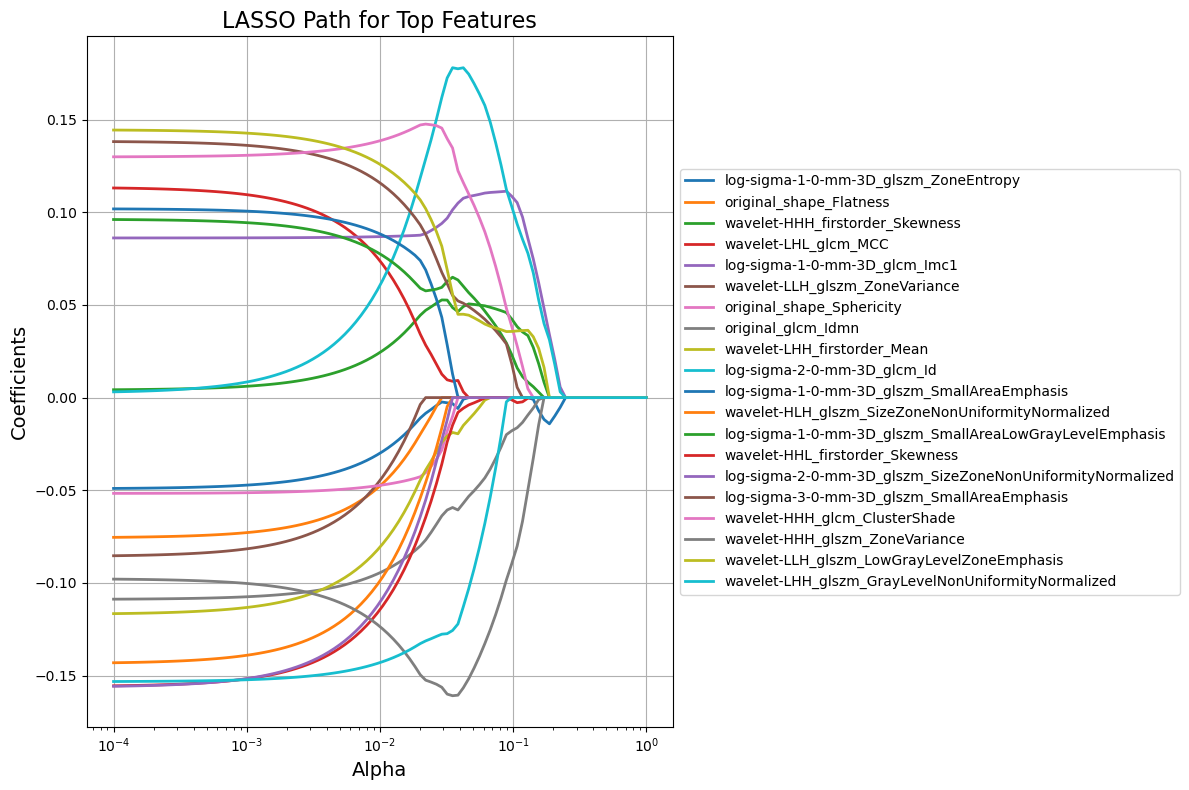

In [215]:
# Compute path for the top features
alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled[:, top_features_idx], y, alphas=np.logspace(-4, 0, 100))

# Plot the path for top features
plt.figure(figsize=(12, 8))
for i in range(coefs_lasso.shape[0]):
    plt.plot(alphas_lasso, coefs_lasso[i, :], label=top_features[i], linewidth=2)

plt.xlabel('Alpha', fontsize=14)
plt.ylabel('Coefficients', fontsize=14)
plt.title('LASSO Path for Top Features', fontsize=16)
plt.xscale('log')
plt.grid(True)

# Place legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.tight_layout()
plt.savefig('/home/evannaughton/project/radiomics_code/plots/LASSO_Path_for_Top_Features1.png', dpi=250)
plt.show()

According to LASSO regression, these 20 features are the most significant between the high and low Ki-67 groups. The LASSO path plot shows how feature coefficients change as the regularization strength (alpha) varies. Features with coefficients that remain significant (non-zero) over a wide range of alpha values, such as log-sigma-1-0-mm-3D_glszm_ZoneEntropy and original_shape_Flatness, are likely more important for predicting the response variable. Features with coefficients that quickly shrink to zero as alpha increases, like wavelet-HHL_firstorder_Skewness, are less important under stronger regularization. The crossing paths of some coefficients indicate changes in relative importance due to correlations between features. This plot helps in selecting an optimal alpha to balance model complexity and performance, guiding feature selection and model validation for improved prediction accuracy. Its good to see shape_flatness and shape_sphericity as well as cluster_shade here as they coincide with the original study by Ahmed et al.

In [216]:
# Perform LASSO regression with cross-validation
lasso_cv = LassoCV(cv=10, random_state=0, max_iter=10000).fit(X_scaled[:, top_features_idx], y)

# Extract coefficients
lasso_coef_cv = lasso_cv.coef_

# Identify significant features (non-zero coefficients)
significant_features_cv = top_features[lasso_coef_cv != 0]
print("Significant features with cross-validation:", significant_features_cv)

# Create DataFrame showing the coefficients of significant features
significant_features_df_cv = pd.DataFrame({'Feature': top_features, 'Coefficient': lasso_coef_cv})
significant_features_df_cv = significant_features_df_cv[significant_features_df_cv['Coefficient'] != 0]
print(significant_features_df_cv)

Significant features with cross-validation: Index(['log-sigma-1-0-mm-3D_glszm_ZoneEntropy', 'original_shape_Flatness',
       'wavelet-HHH_firstorder_Skewness', 'wavelet-LHL_glcm_MCC',
       'log-sigma-1-0-mm-3D_glcm_Imc1', 'wavelet-LLH_glszm_ZoneVariance',
       'original_shape_Sphericity', 'original_glcm_Idmn',
       'wavelet-LHH_firstorder_Mean', 'log-sigma-2-0-mm-3D_glcm_Id',
       'log-sigma-1-0-mm-3D_glszm_SmallAreaEmphasis',
       'wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',
       'log-sigma-1-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet-HHL_firstorder_Skewness',
       'log-sigma-2-0-mm-3D_glszm_SizeZoneNonUniformityNormalized',
       'log-sigma-3-0-mm-3D_glszm_SmallAreaEmphasis',
       'wavelet-HHH_glcm_ClusterShade', 'wavelet-HHH_glszm_ZoneVariance',
       'wavelet-LLH_glszm_LowGrayLevelZoneEmphasis',
       'wavelet-LHH_glszm_GrayLevelNonUniformityNormalized'],
      dtype='object')
                                              Feature  Coef

In [7]:
# Performing statistical analysis on the results (t-test)

# List of feature columns
feature_columns = [col for col in combined_df.columns if col not in ['ID', 'Group']]

# Create DataFrame for results
results = pd.DataFrame(columns=['Feature', 'P-Value'])

# Perform t-test for each feature
for feature in feature_columns:
    high_group_values = combined_df[combined_df['Group'] == 'High'][feature]
    low_group_values = combined_df[combined_df['Group'] == 'Low'][feature]

    t_stat, p_val = ttest_ind(high_group_values, low_group_values, nan_policy='omit')

    results.loc[len(results)] = {'Feature': feature, 'P-Value': p_val}

# Filter and display all significant features (p-value < 0.05)
significant_features = results[results['P-Value'] < 0.05]
print("Significant Features (P-Value < 0.05):")
display(significant_features)

Significant Features (P-Value < 0.05):


Feature   P-Value
44                         original_firstorder_Variance  0.046865
48                        original_glcm_ClusterTendency  0.048069
56                                   original_glcm_Idmn  0.047676
71                     original_glrlm_GrayLevelVariance  0.039977
86      original_glszm_GrayLevelNonUniformityNormalized  0.047264
...                                                 ...       ...
1076                wavelet-LLL_glcm_DifferenceVariance  0.026128
1091                        wavelet-LLL_glcm_SumSquares  0.037446
1094                wavelet-LLL_glrlm_GrayLevelVariance  0.030102
1109  wavelet-LLL_glszm_GrayLevelNonUniformityNormal...  0.006125
1129                 wavelet-LLL_gldm_GrayLevelVariance  0.027319

[86 rows x 2 columns]

These radiomic features demonstrate statistically significant intergroup difference between the low and high Ki-67 tumour subgroups (via T-Test).

In [220]:
# Performing LASSO regression on these significant features 

# List of significant features from the t-test
significant_features_list = significant_features['Feature'].tolist()

# Filter the original DataFrame to include only these features
filtered_df = combined_df[significant_features_list + ['Group']]

# Define features and target variable
X_filtered = filtered_df.drop(columns=['Group'])
y_filtered = filtered_df['Group'].apply(lambda x: 1 if x == 'High' else 0)

# Split data into training and test sets
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Standardize features
scaler_filtered = StandardScaler()
X_train_filtered_scaled = scaler_filtered.fit_transform(X_train_filtered)
X_test_filtered_scaled = scaler_filtered.transform(X_test_filtered)

# Perform LASSO regression with cross-validation to select the best alpha
lasso_cv_filtered = LassoCV(cv=10, random_state=42, max_iter=100000)
lasso_cv_filtered.fit(X_train_filtered_scaled, y_train_filtered)

# Get the coefficients and features
coefficients_filtered = pd.Series(lasso_cv_filtered.coef_, index=X_filtered.columns)

# Filter out non-zero coefficients
significant_features_lasso = coefficients_filtered[coefficients_filtered != 0]
print("Significant features identified by LASSO regression:")
print(significant_features_lasso)

# Evaluate model performance
train_score_filtered = lasso_cv_filtered.score(X_train_filtered_scaled, y_train_filtered)
test_score_filtered = lasso_cv_filtered.score(X_test_filtered_scaled, y_test_filtered)
print(f"Training score: {train_score_filtered}")
print(f"Test score: {test_score_filtered}")

# Output the number of selected features
print(f"Number of significant features: {len(significant_features_lasso)}")

Significant features identified by LASSO regression:
log-sigma-1-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis       0.065021
log-sigma-2-0-mm-3D_glrlm_RunLengthNonUniformityNormalized   -0.015494
log-sigma-3-0-mm-3D_firstorder_InterquartileRange            -0.062757
log-sigma-3-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis       0.105045
wavelet-HLL_glrlm_RunEntropy                                 -0.133718
wavelet-HHH_firstorder_Skewness                               0.087977
dtype: float64
Training score: 0.5320275090347019
Test score: 0.049030631717255746
Number of significant features: 6


According to the LASSO regression model on statistically significant features by t-test, these 6 features are significant differentiating features between high and low groups.

<Figure size 1000x600 with 0 Axes>

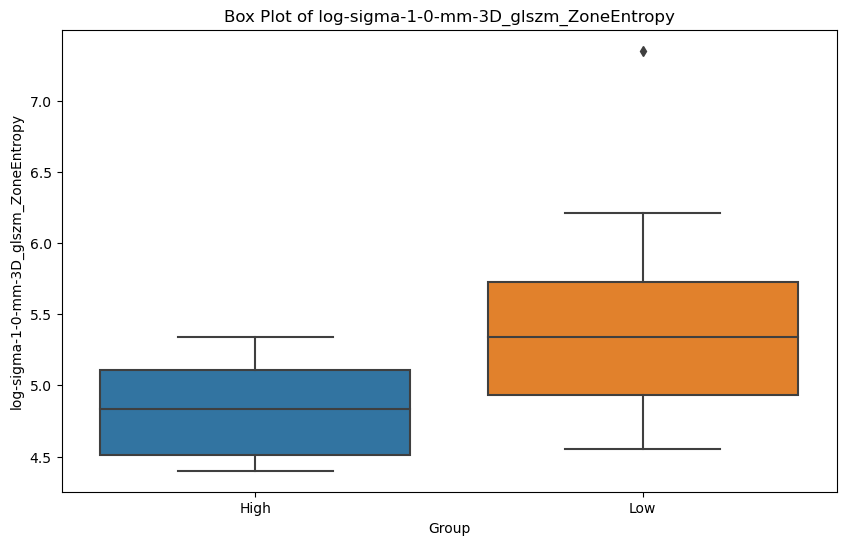

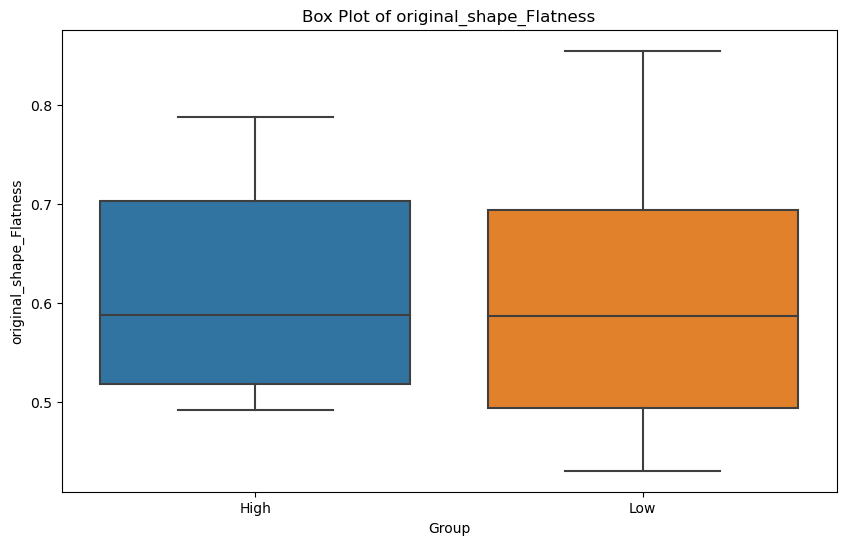

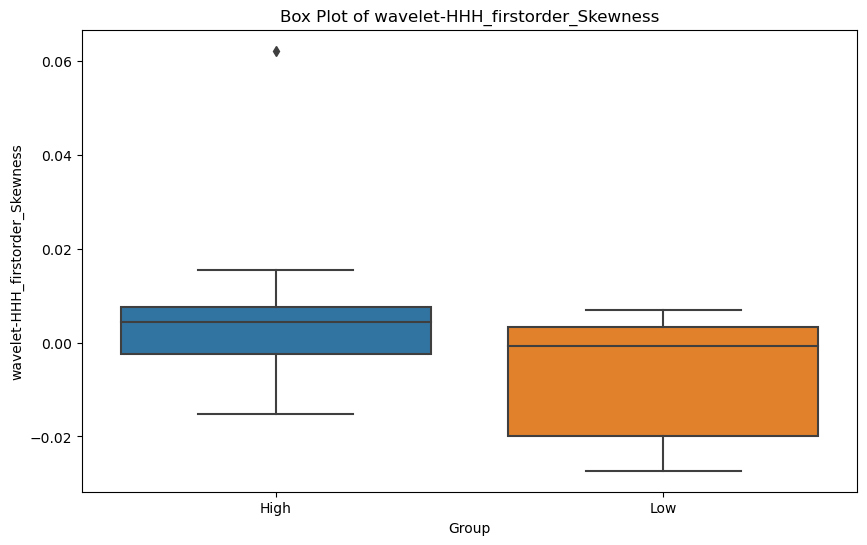

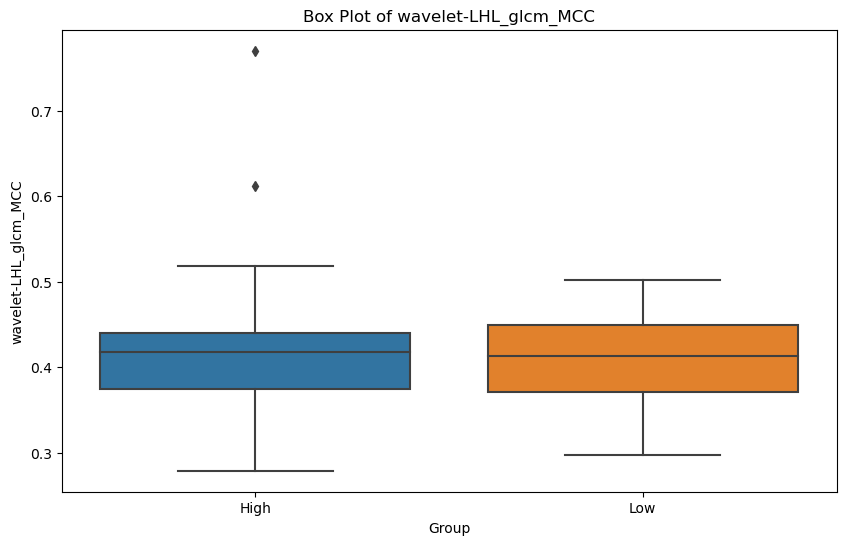

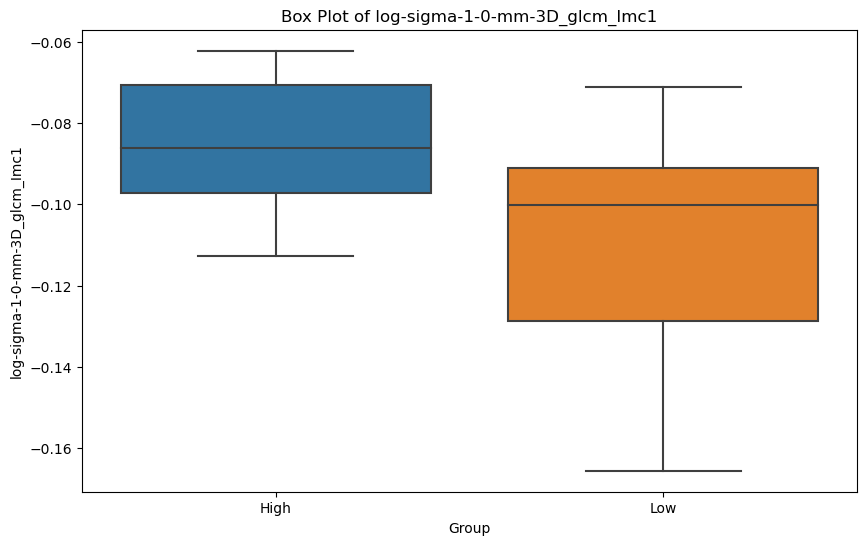

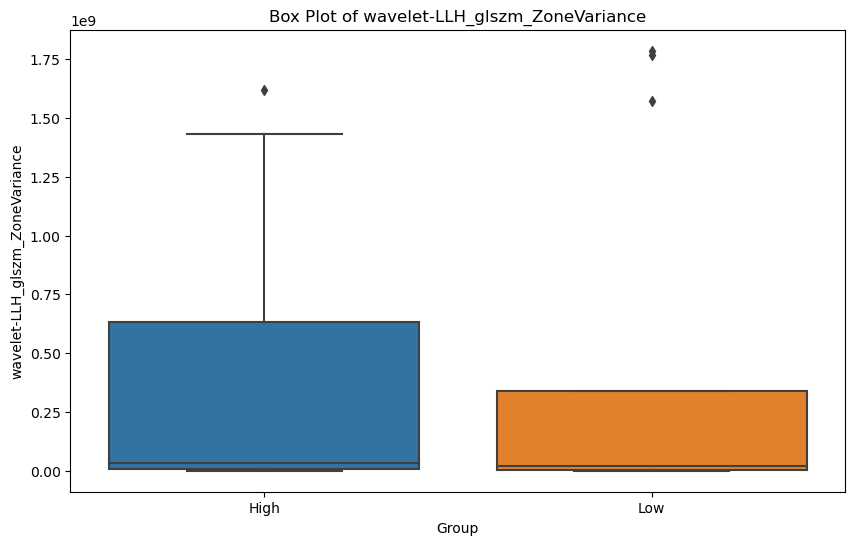

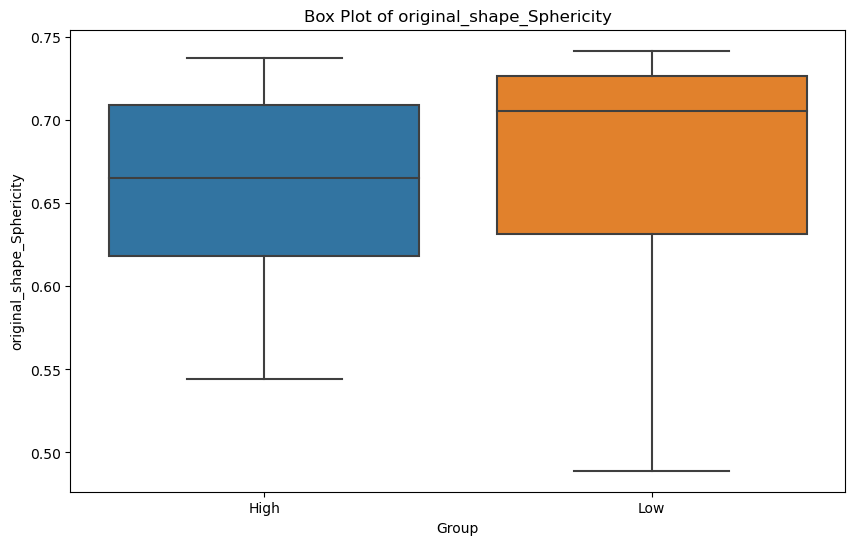

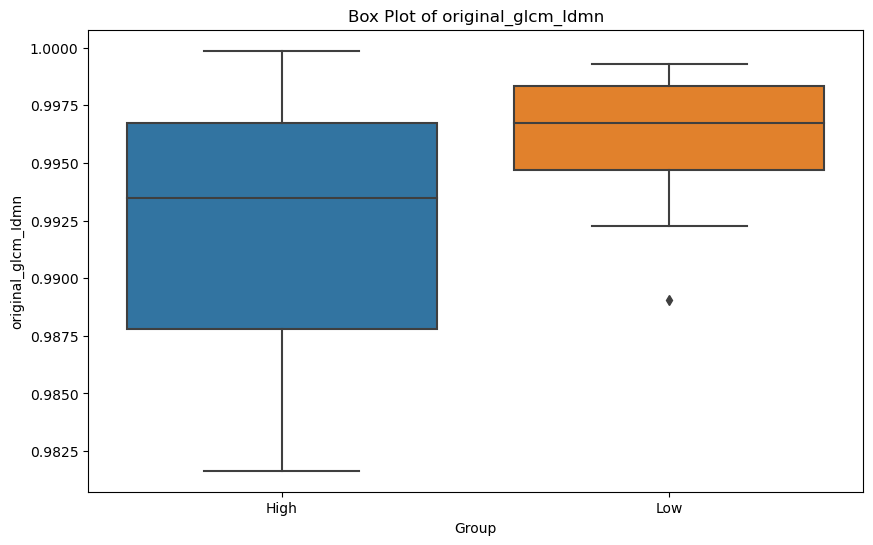

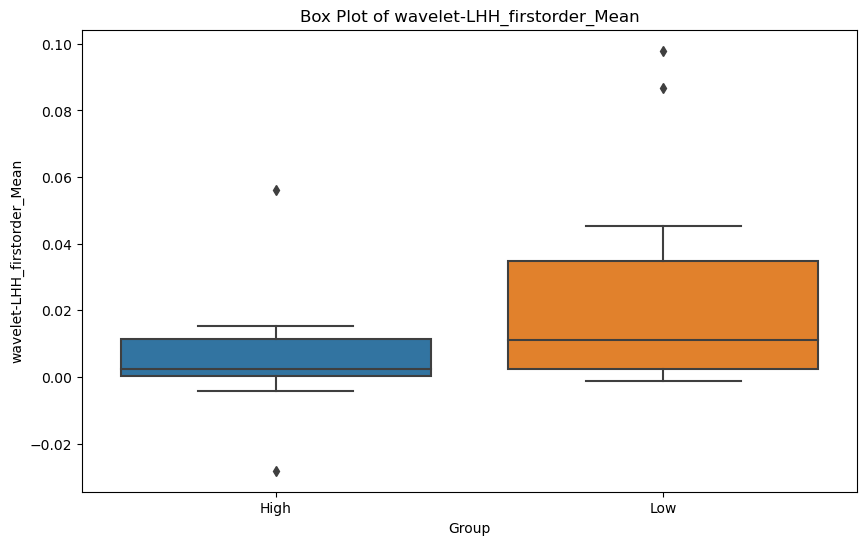

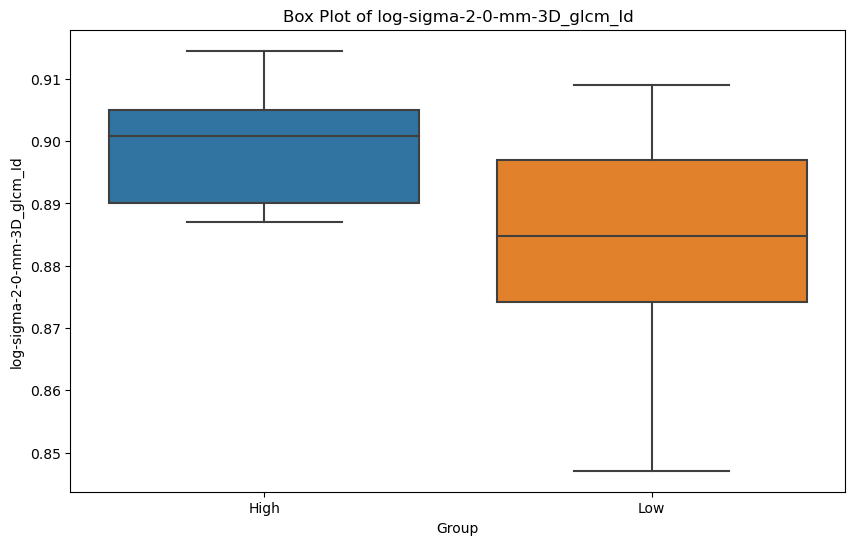

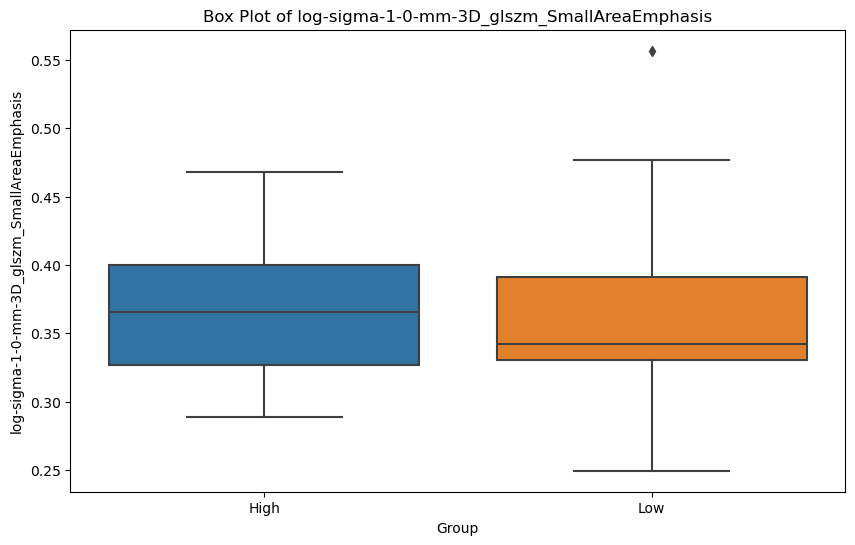

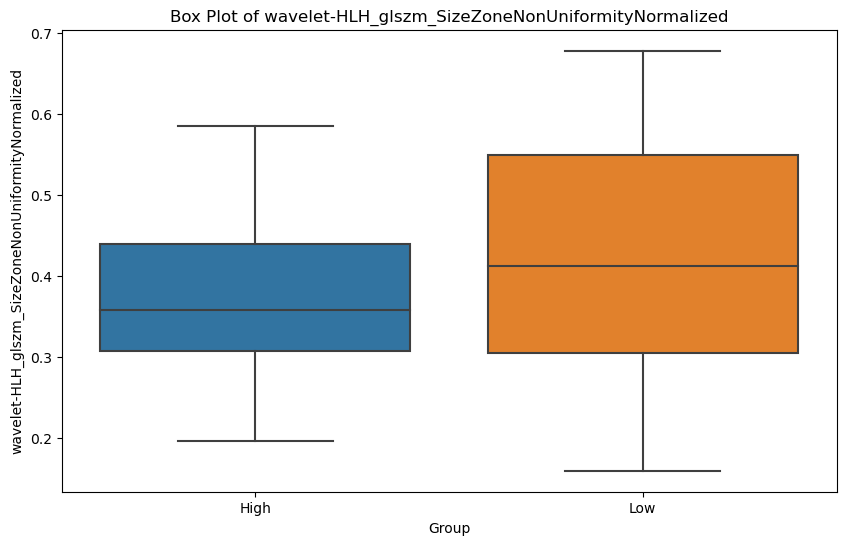

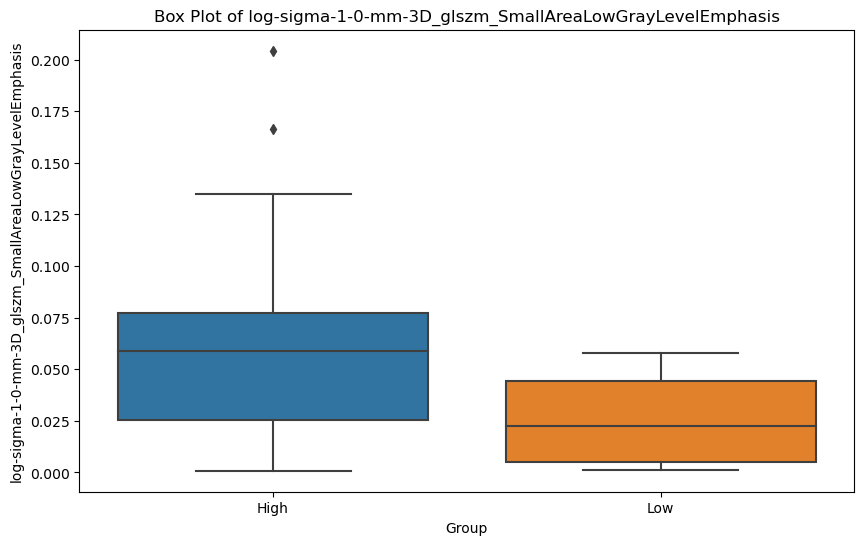

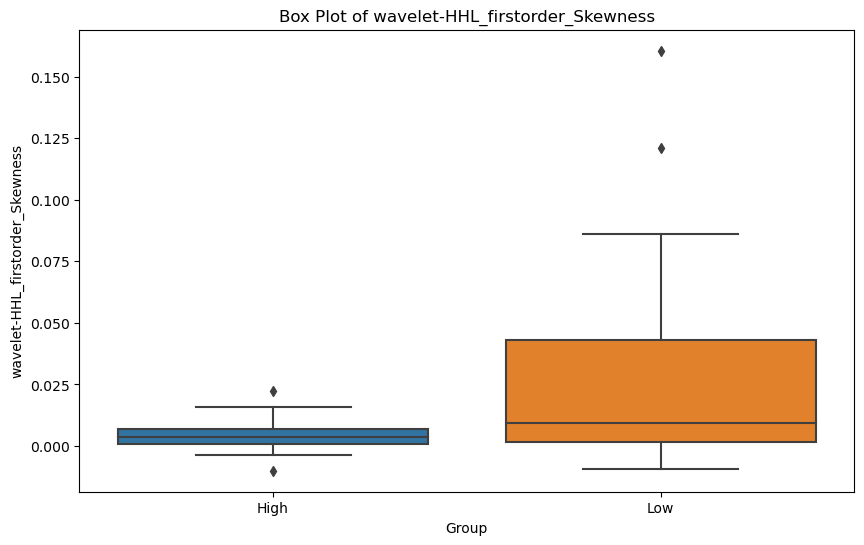

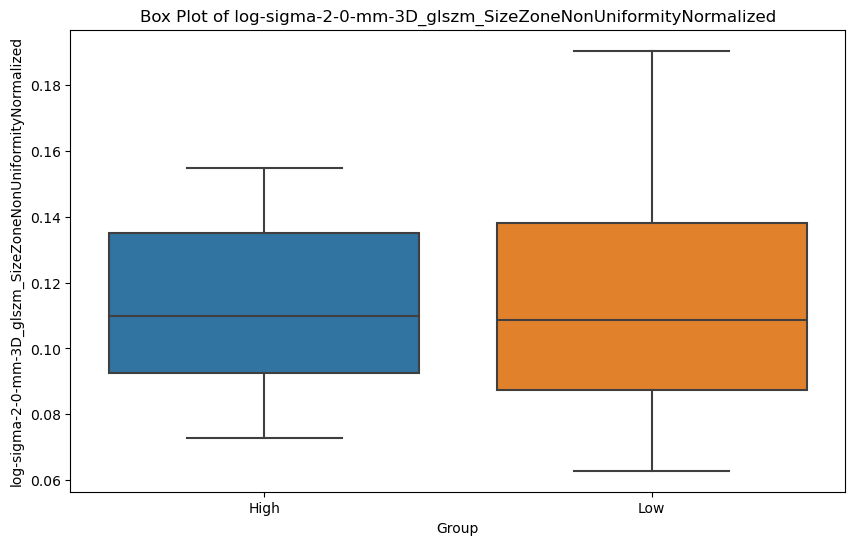

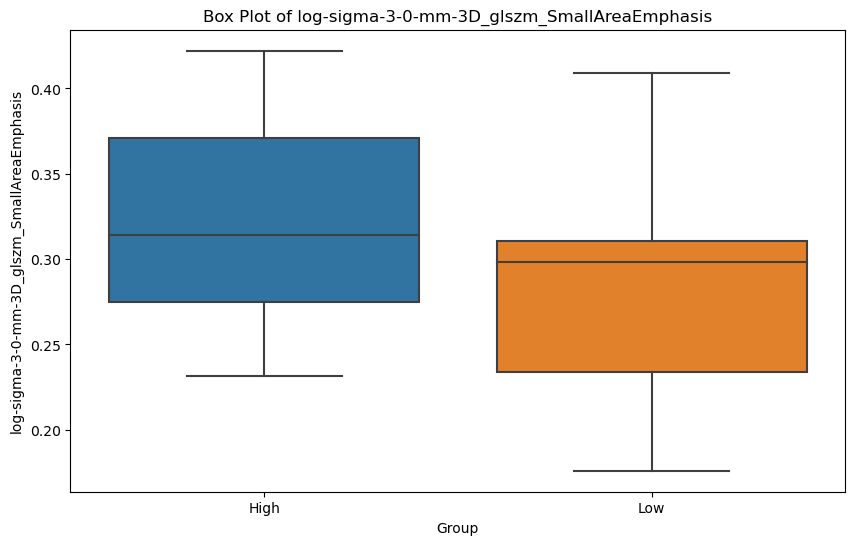

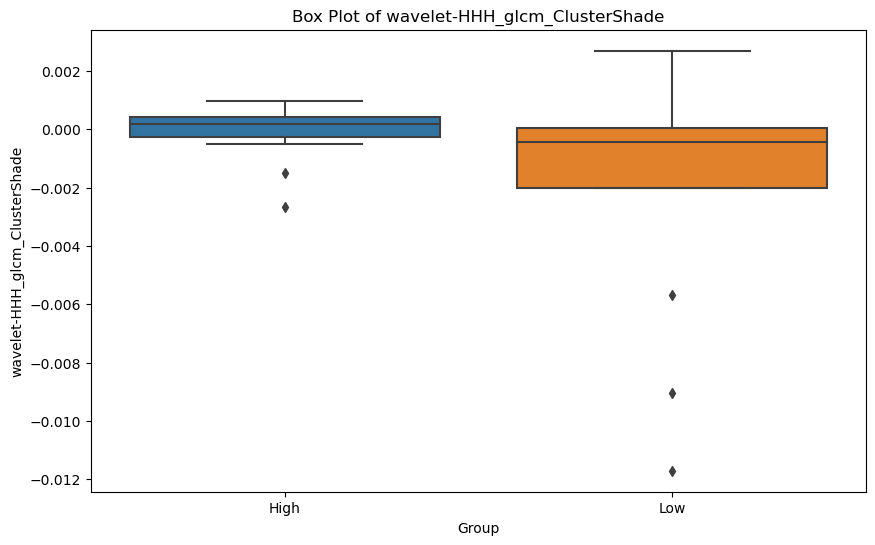

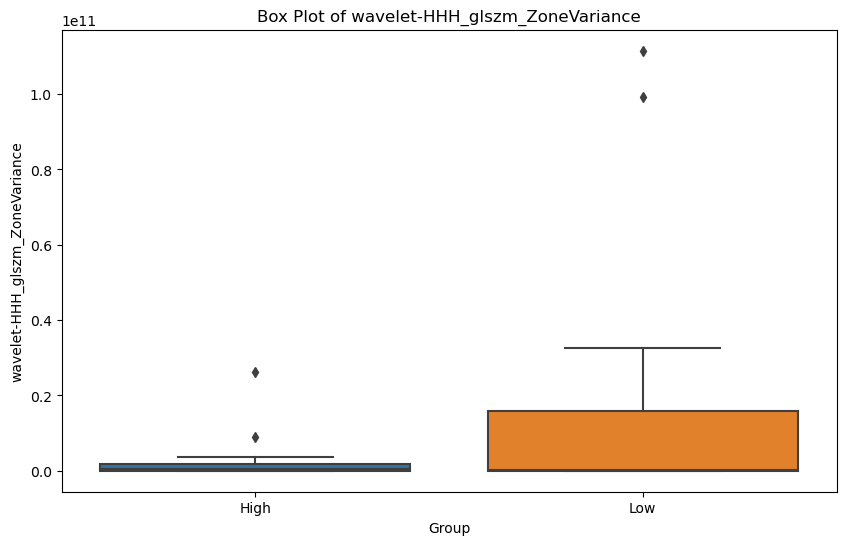

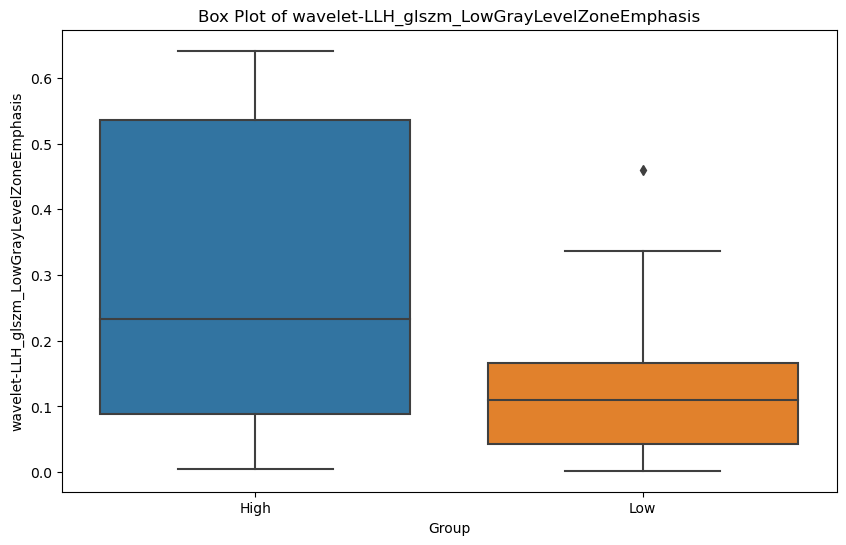

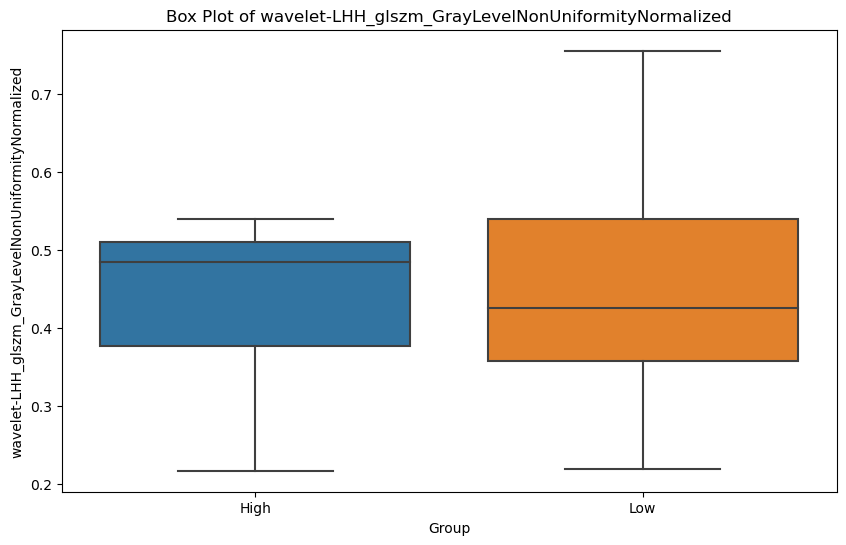

In [175]:
# boxplots of the 20 features chosen by LASSO
plt.figure(figsize=(10, 6))

for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Group', y=feature, data=combined_df)
    plt.title(f'Box Plot of {feature}')
    plt.savefig(f'{feature}_boxplot.png')
    plt.show()

In [8]:
# Pearson Correlation matrix for LASSO selected features

# Compute the correlation matrix for the top features
correlation_matrix = combined_df[top_features].corr()

# Display the correlation matrix
plt.figure(figsize=(24, 20))  
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 12}, cmap='coolwarm', fmt='.2f',
            xticklabels=top_features, yticklabels=top_features)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)  
plt.title('LASSO selected Feature Correlation Matrix')
plt.savefig('/home/evannaughton/project/radiomics_code/plots/LASSO_selected_Feature_Correlation_Matrix.png', dpi=250, bbox_inches='tight')  
plt.show()

NameError: name 'top_features' is not defined

The correlation matrix for the top features selected by LASSO shows a mix of positive and negative relationships, with most correlations being moderate to low. Blue shades indicate negative correlations, red shades indicate positive correlations, and white or very light shades represent little to no linear relationship. The numbers in each cell represent Pearson correlation coefficients, with 1 indicating a perfect positive relationship, -1 a perfect negative relationship, and 0 no linear relationship. The diagonal elements are all 1, as each feature is perfectly correlated with itself. This matrix suggests that while some features might be related, many provide unique information, which is beneficial for building robust predictive models by reducing redundancy and potential multicollinearity issues.

Top 20 most significant features:
['log-sigma-1-0-mm-3D_glcm_Correlation', 'log-sigma-1-0-mm-3D_glcm_Imc2', 'log-sigma-3-0-mm-3D_glcm_Contrast', 'log-sigma-3-0-mm-3D_glcm_DifferenceVariance', 'log-sigma-3-0-mm-3D_glcm_DifferenceEntropy', 'wavelet-LLL_glszm_GrayLevelNonUniformityNormalized', 'log-sigma-3-0-mm-3D_glcm_DifferenceAverage', 'log-sigma-3-0-mm-3D_glcm_Idm', 'log-sigma-2-0-mm-3D_glcm_DifferenceEntropy', 'log-sigma-3-0-mm-3D_glcm_Id', 'log-sigma-2-0-mm-3D_glcm_Contrast', 'log-sigma-2-0-mm-3D_firstorder_Variance', 'log-sigma-2-0-mm-3D_glcm_SumSquares', 'log-sigma-2-0-mm-3D_glcm_ClusterTendency', 'log-sigma-2-0-mm-3D_glcm_JointEntropy', 'log-sigma-2-0-mm-3D_gldm_GrayLevelVariance', 'log-sigma-2-0-mm-3D_glcm_DifferenceAverage', 'log-sigma-3-0-mm-3D_glcm_InverseVariance', 'log-sigma-2-0-mm-3D_firstorder_Entropy', 'log-sigma-2-0-mm-3D_glcm_SumEntropy']
Top 20 features and box plots saved to 'top_20_features.txt' and respective image files.


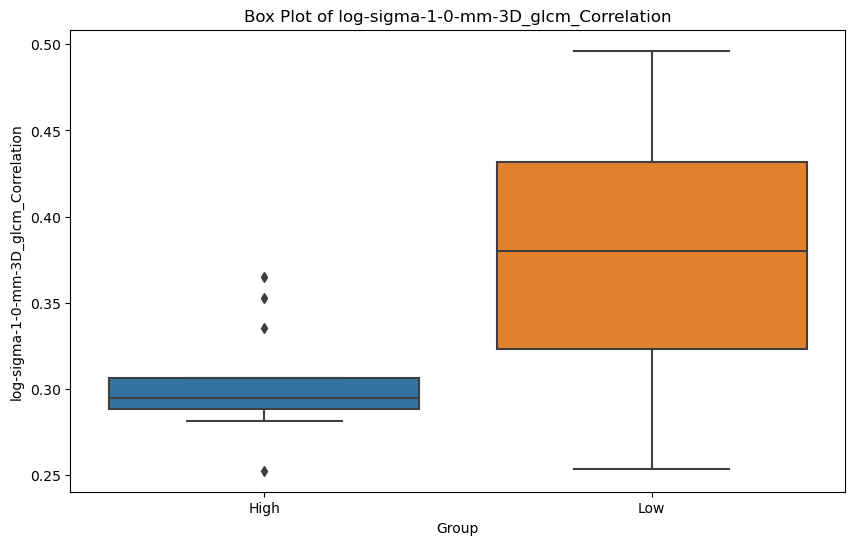

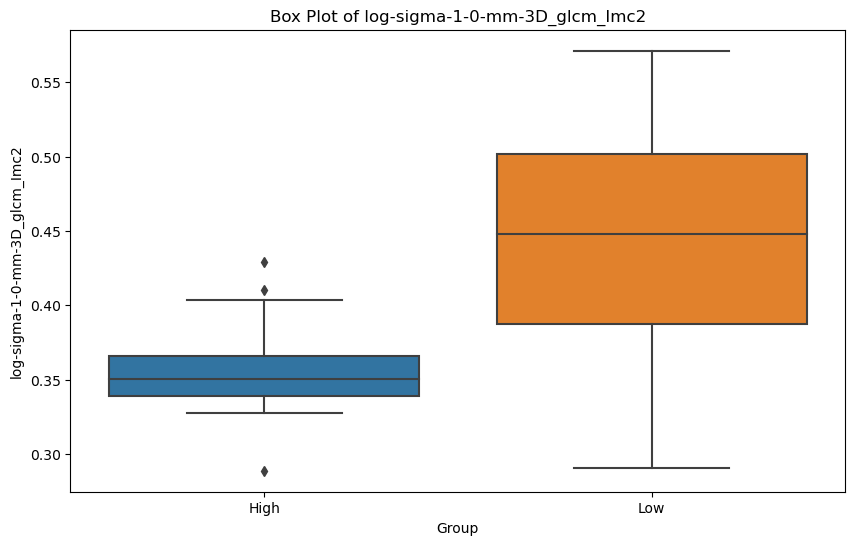

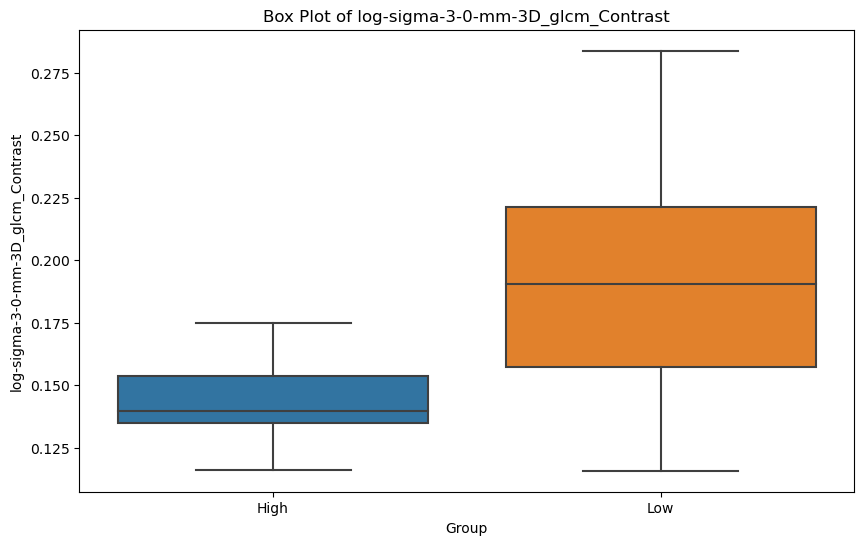

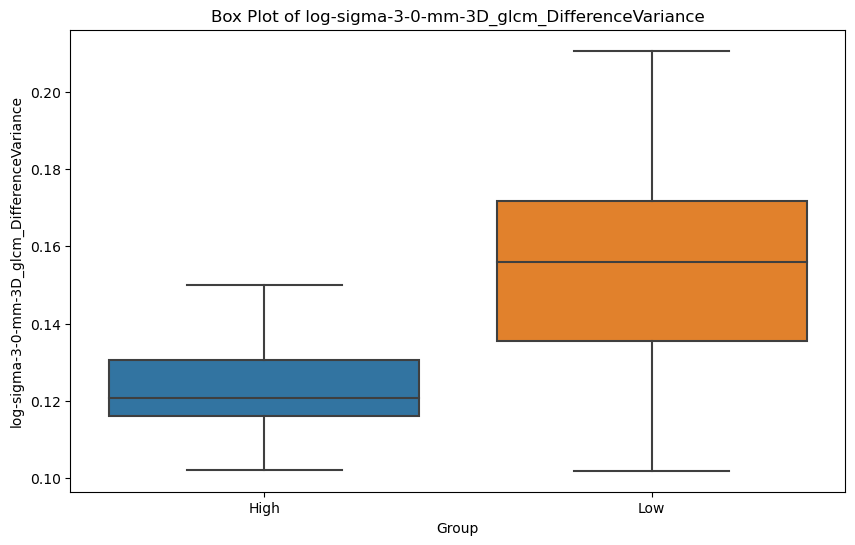

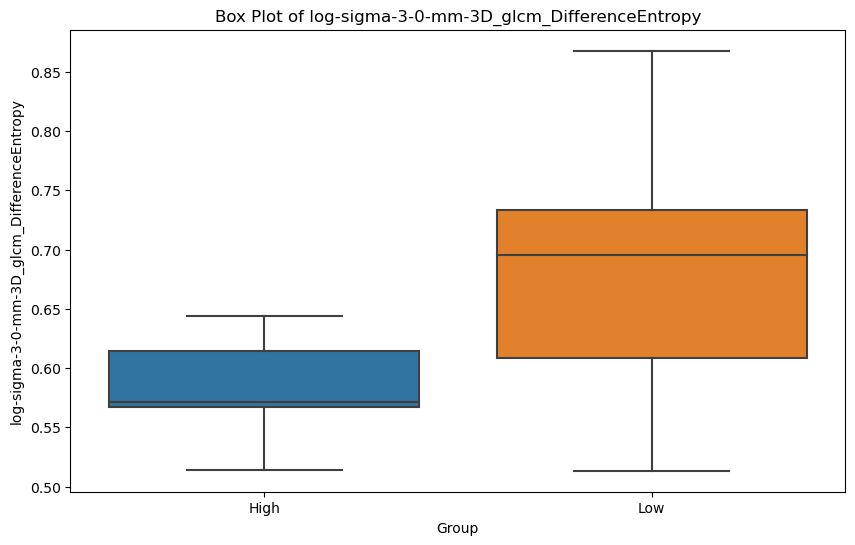

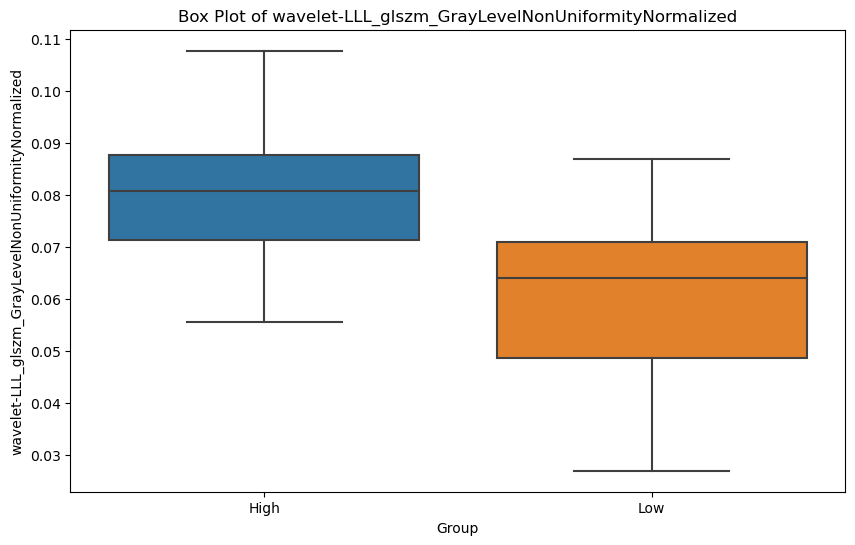

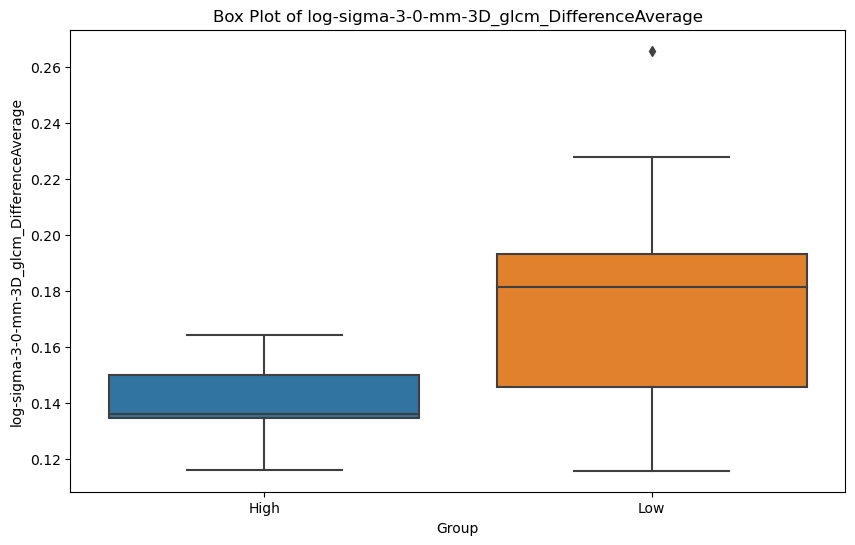

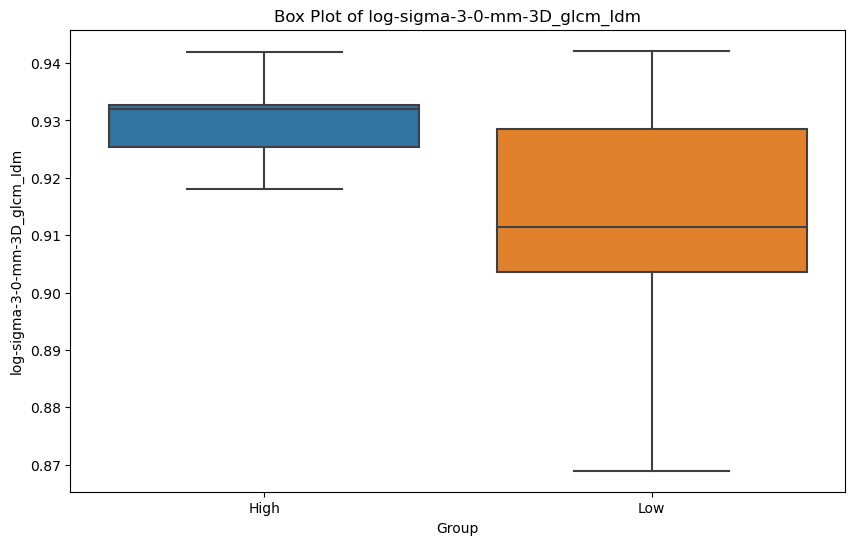

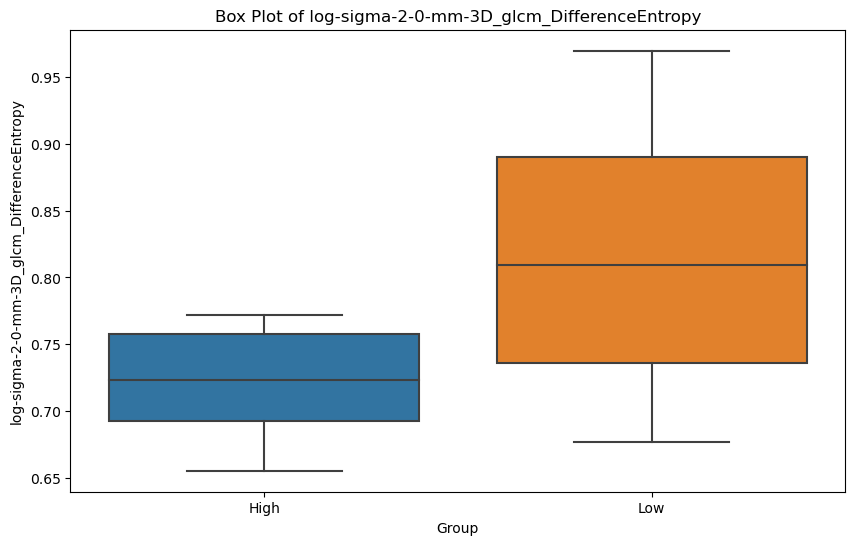

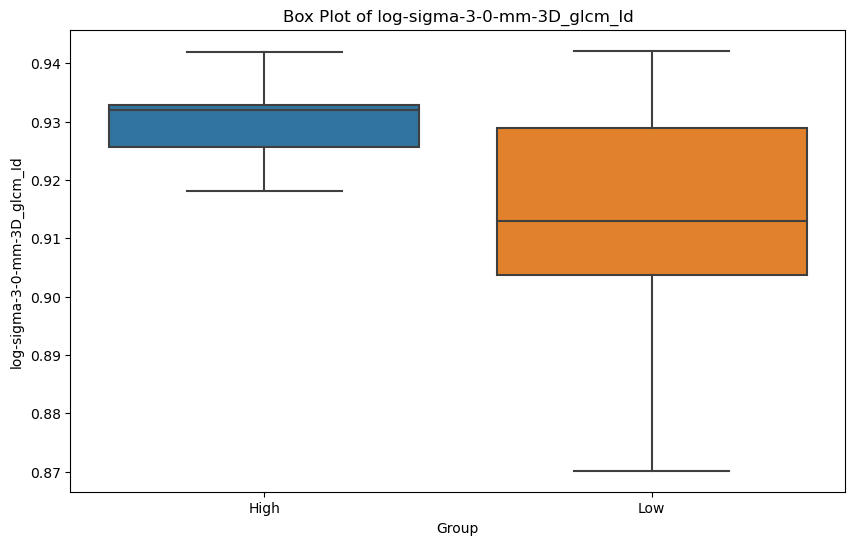

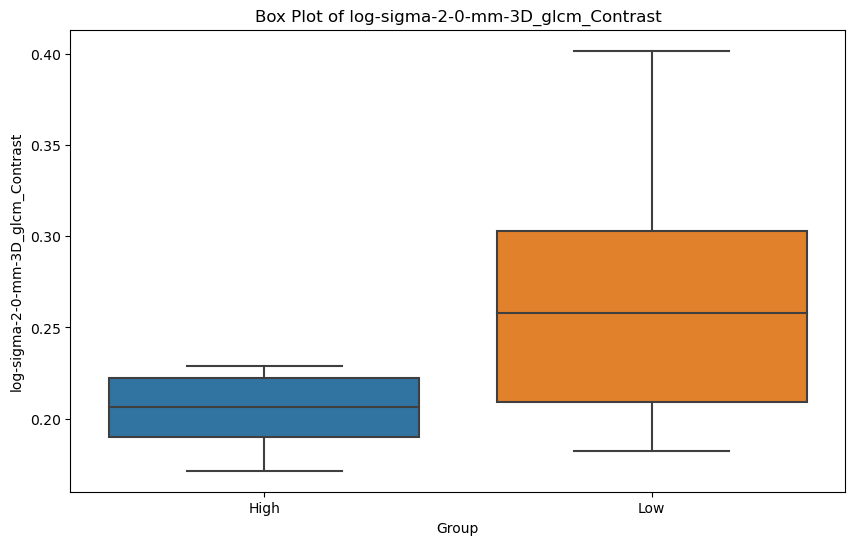

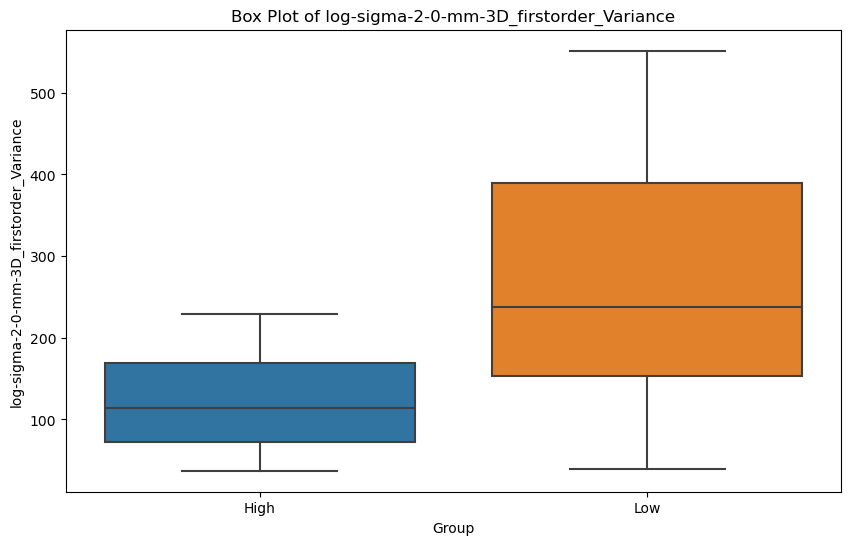

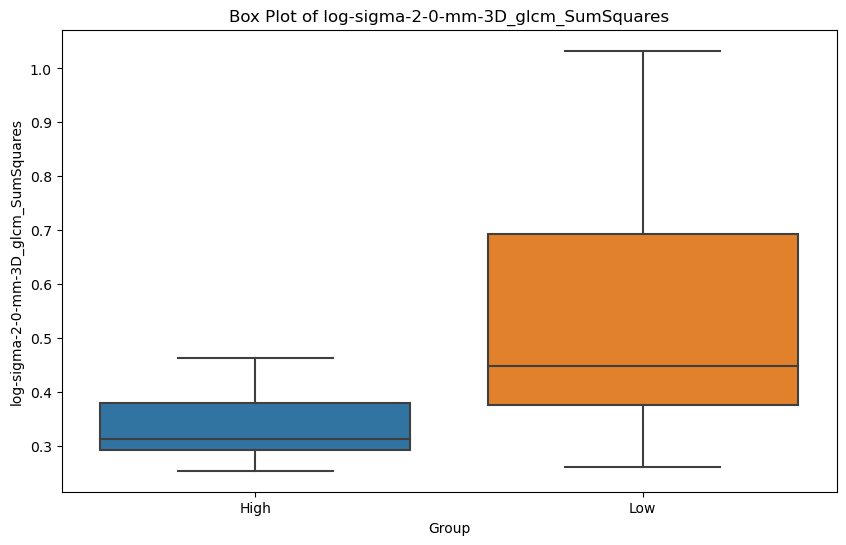

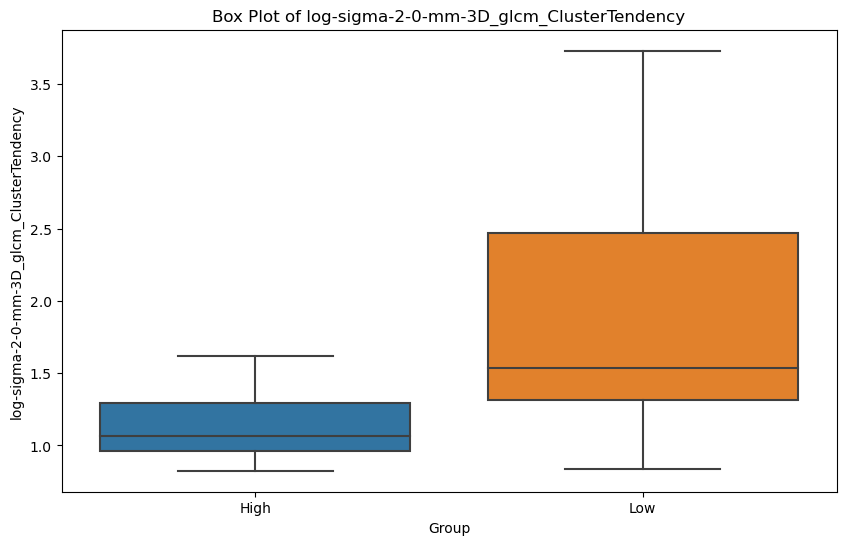

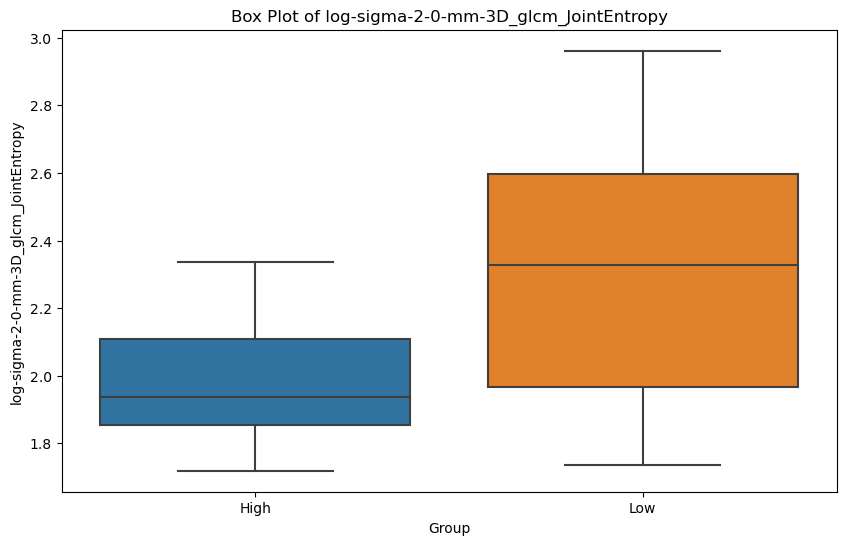

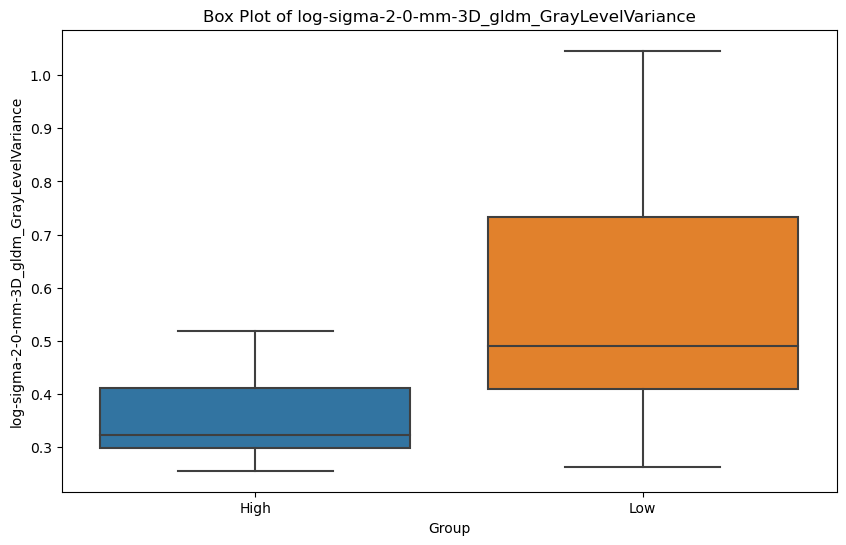

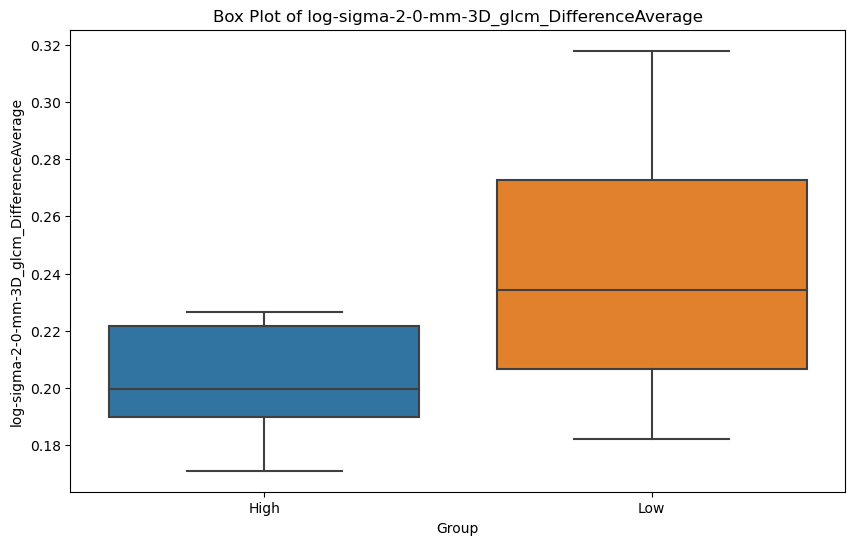

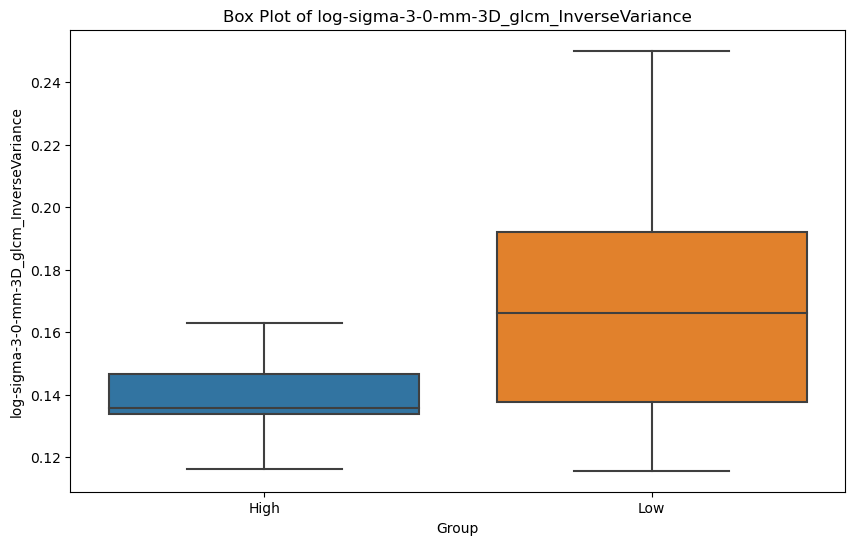

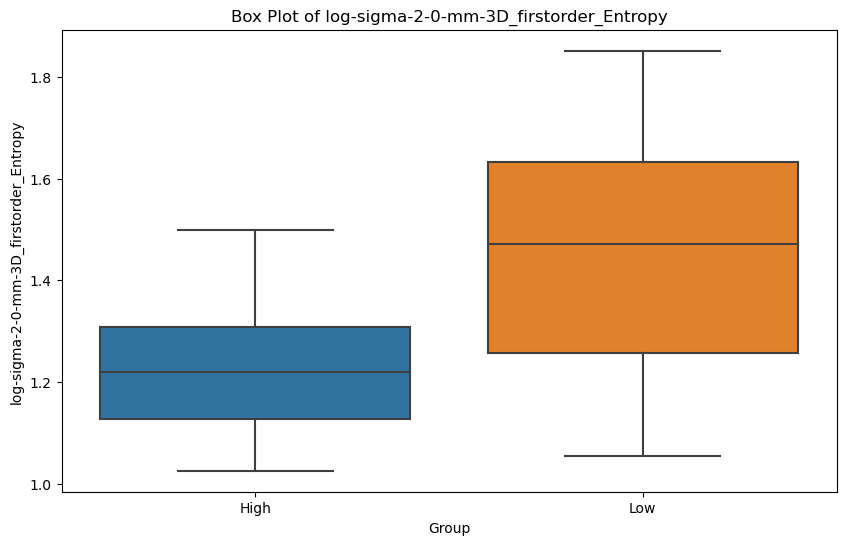

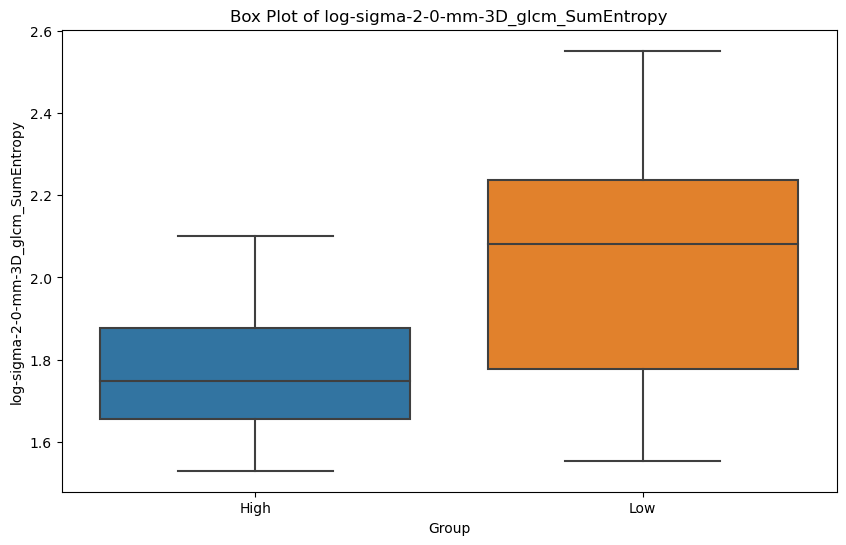

In [8]:
# Sort the features by p-value and select the top 20 most significant features
top_20_features = significant_features.sort_values(by='P-Value').head(20)
top_20_features_list = top_20_features['Feature'].tolist()
print("Top 20 most significant features:")
print(top_20_features_list)

with open('top_20_features.txt', 'w') as f:
    for feature in top_20_features_list:
        f.write(f'{feature}\n')
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Group', y=feature, data=combined_df)
        plt.title(f'Box Plot of {feature}')
        plt.savefig(f'{feature}_boxplot.png')
        f.write(f'Saved box plot for {feature}\n')

print("Top 20 features and box plots saved to 'top_20_features.txt' and respective image files.")

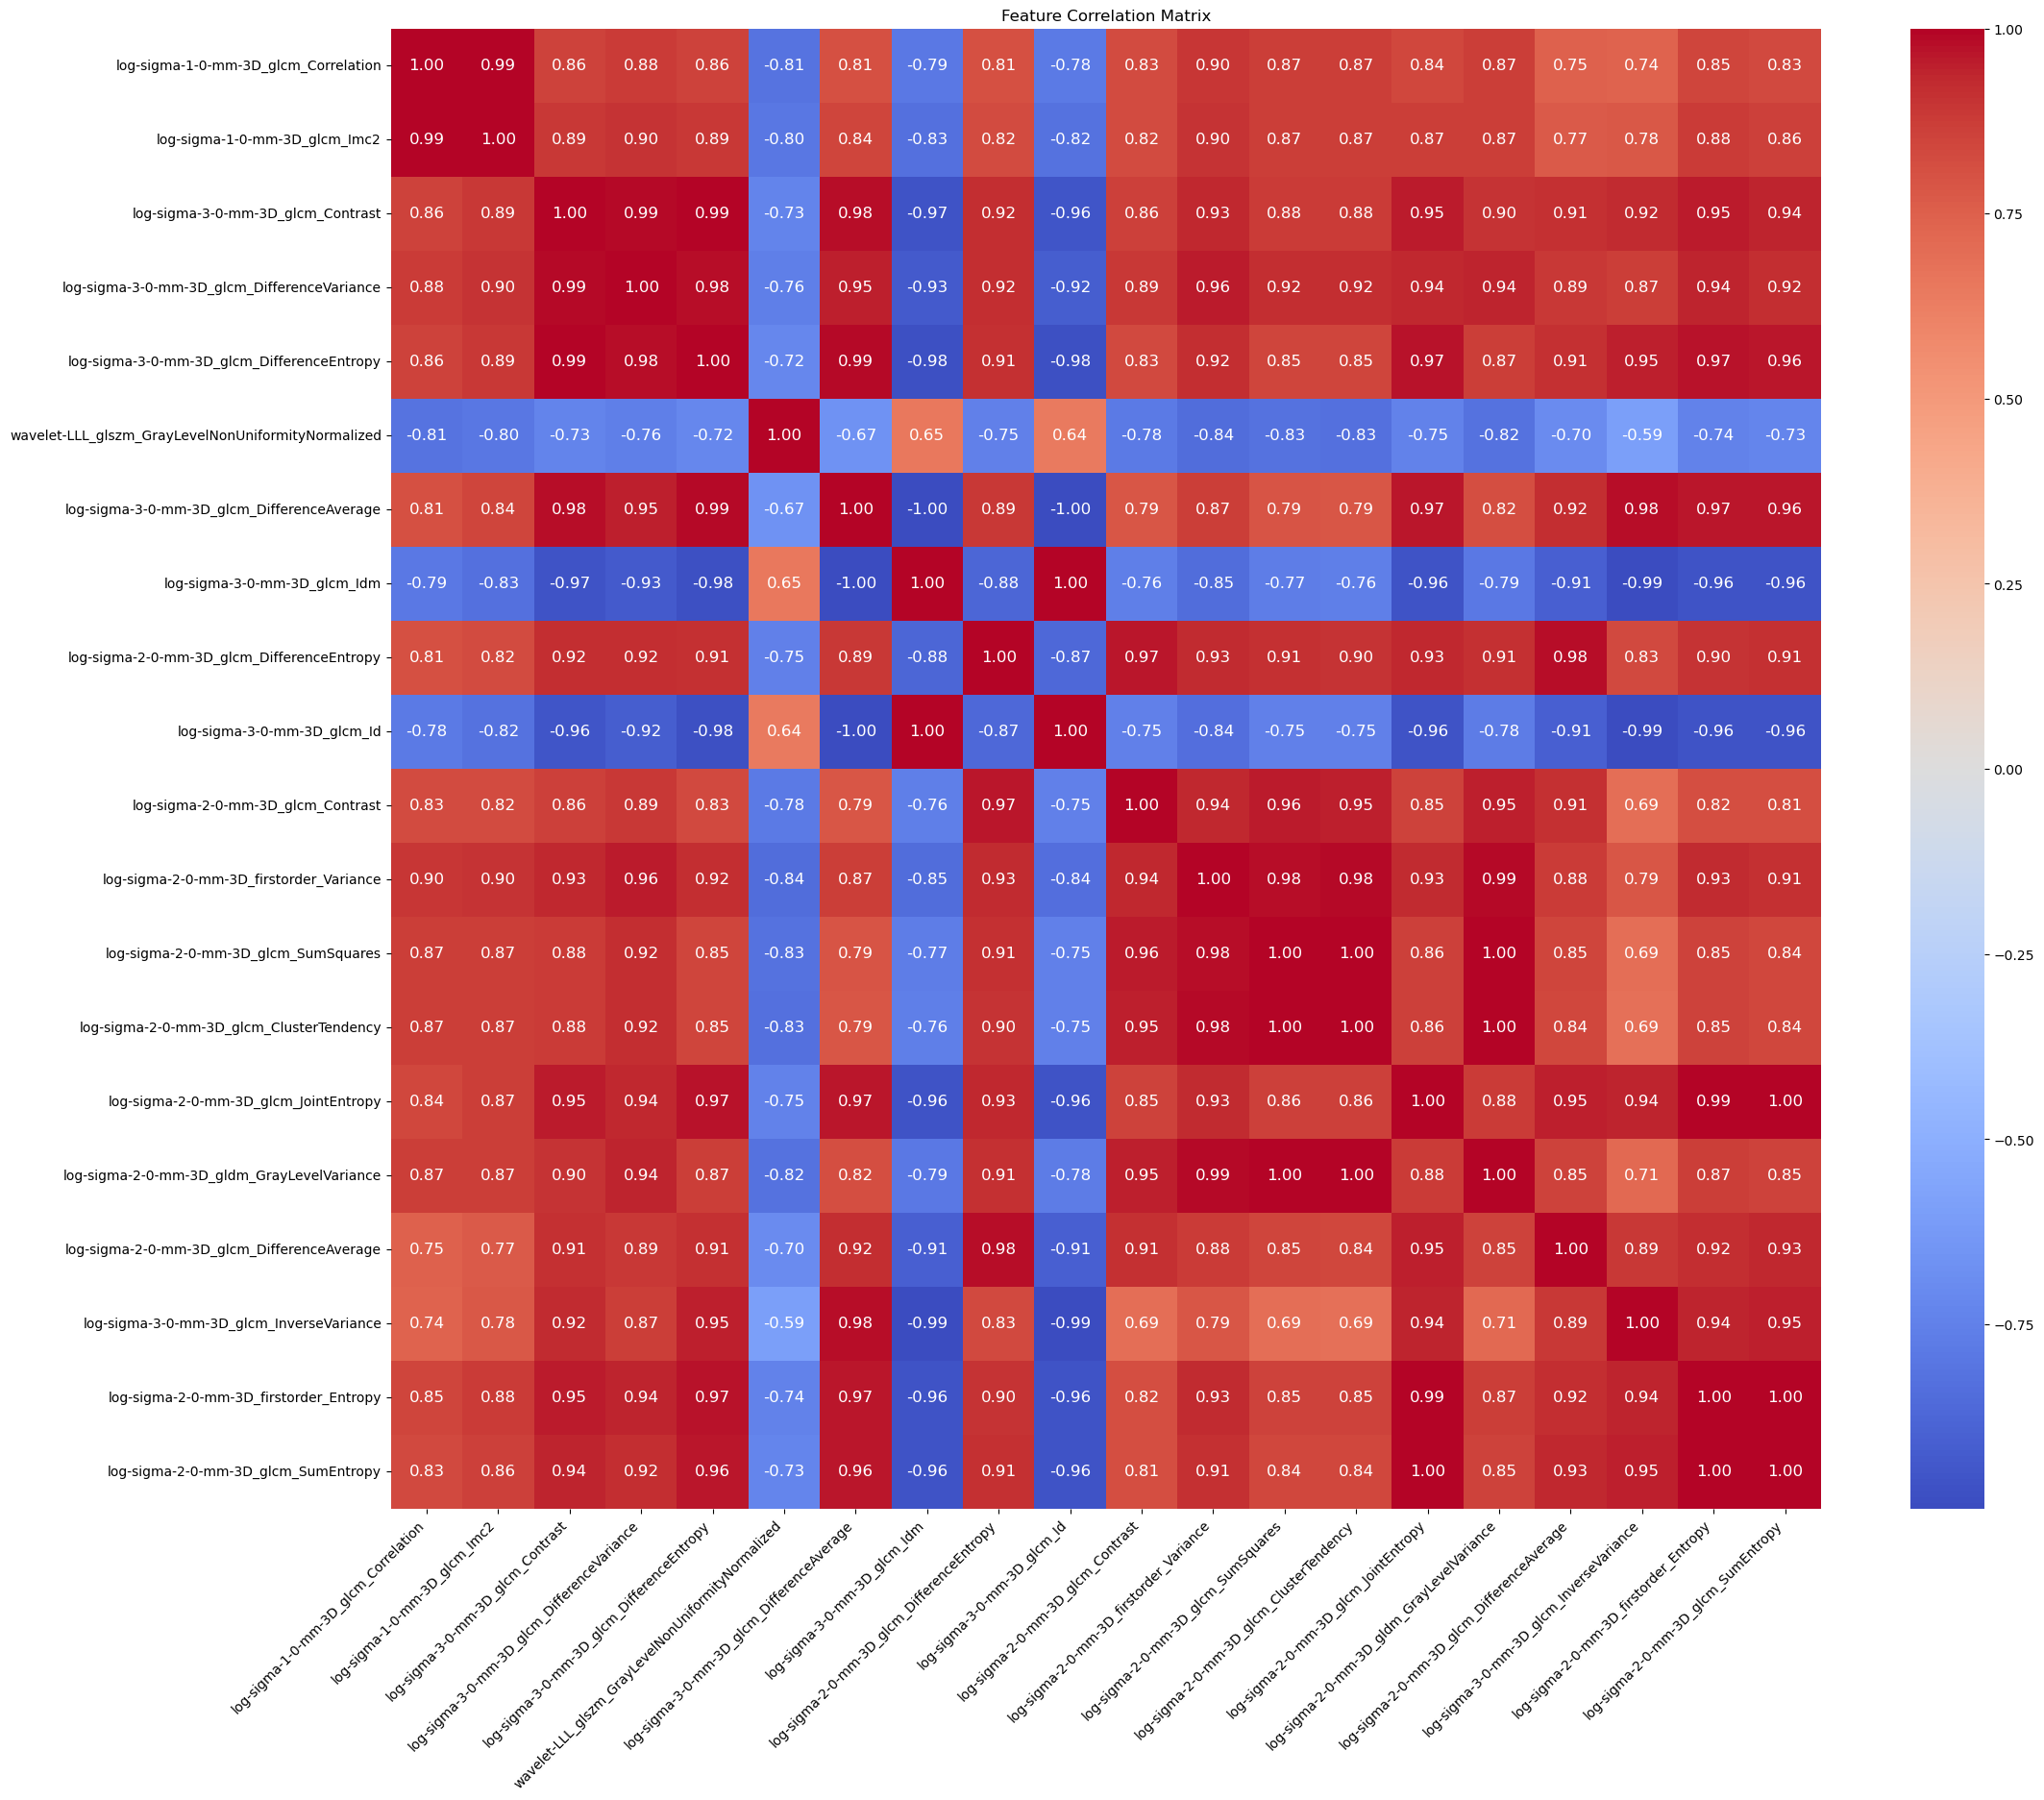

In [30]:
# Pearson Correlation matrix for t-test selected features

# Compute the correlation matrix for the top features
correlation_matrix = combined_df[top_20_features_list].corr()

# Display the correlation matrix
plt.figure(figsize=(24, 20))  
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 12}, cmap='coolwarm', fmt='.2f',
            xticklabels=top_20_features_list, yticklabels=top_20_features_list)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)  
plt.title('Feature Correlation Matrix')
plt.savefig('/home/evannaughton/project/radiomics_code/plots/Feature_Correlation_Matrix.png', dpi=250, bbox_inches='tight')  
plt.show()

Based on the Pearson correlation matrix:

High correlations indicate redundancy. Redundant features provide similar information, and retaining all of them doesn't add value to the model. Instead, it increases complexity and can lead to overfitting.
Therefore, blocks of red (high positive correlation) or blue (high negative correlation) mean that many features are providing overlapping information. The next step would be to choose representative features to represent these blocks.

We are only interested in those features that are just statistically significant in the high group with regards to the low group. We can select these features and make a correlation matrix / boxplots from these also.

In [184]:
# LASSO regression for features that have a higher value in the high group only

# Encode the target variable
combined_df['Group'] = combined_df['Group'].map({'High': 1, 'Low': 0})

# Separate features and target
X = combined_df.drop(columns=['ID', 'Group'])
y = combined_df['Group']

# Calculate the mean values for each feature in 'High' and 'Low' groups
high_means = combined_df[combined_df['Group'] == 1][X.columns].mean()
low_means = combined_df[combined_df['Group'] == 0][X.columns].mean()

# Filter features to include only those with higher mean values in 'High' group
higher_mean_features = high_means[high_means > low_means].index
X_filtered = X[higher_mean_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Perform LASSO regression with cross-validation
lasso = LassoCV(cv=10, random_state=0, max_iter=10000).fit(X_scaled, y)

# Extract coefficients
lasso_coef = lasso.coef_

# Identify significant features (non-zero coefficients)
significant_features = X_filtered.columns[lasso_coef != 0]

# Create a DataFrame to show the coefficients of significant features
significant_features_df = pd.DataFrame({'Feature': significant_features, 'Coefficient': lasso_coef[lasso_coef != 0]})
print(significant_features_df)

                                             Feature   Coefficient
0  wavelet-LLL_glszm_GrayLevelNonUniformityNormal...  3.416071e-17


In [187]:
# Perform initial LASSO regression to get feature importance
lasso = Lasso(alpha=0.01, max_iter=10000).fit(X_scaled, y)
lasso_coef = lasso.coef_

# Get the absolute values of coefficients to determine importance
coef_magnitude = np.abs(lasso_coef)

# Get the indices of the top 20 features
top_features_idx = np.argsort(coef_magnitude)[-20:]  
top_features = X.columns[top_features_idx]
print("Top features:", top_features)

Top features: Index(['original_shape_MajorAxisLength', 'original_glszm_LargeAreaEmphasis',
       'original_shape_Maximum2DDiameterSlice', 'original_ngtdm_Busyness',
       'diagnostics_Image-original_Mean', 'original_firstorder_Variance',
       'original_glcm_Idn', 'diagnostics_Image-interpolated_Mean',
       'original_glcm_ClusterTendency', 'log-sigma-1-0-mm-3D_glcm_Idm',
       'log-sigma-1-0-mm-3D_glszm_GrayLevelVariance',
       'log-sigma-1-0-mm-3D_glszm_GrayLevelNonUniformity',
       'log-sigma-3-0-mm-3D_glrlm_LongRunEmphasis',
       'original_glcm_ClusterShade', 'log-sigma-1-0-mm-3D_glcm_Idn',
       'original_glrlm_GrayLevelNonUniformityNormalized',
       'log-sigma-3-0-mm-3D_glcm_JointEnergy',
       'log-sigma-1-0-mm-3D_ngtdm_Strength',
       'log-sigma-1-0-mm-3D_gldm_SmallDependenceEmphasis',
       'diagnostics_Image-interpolated_Minimum'],
      dtype='object')


<Figure size 1000x600 with 0 Axes>

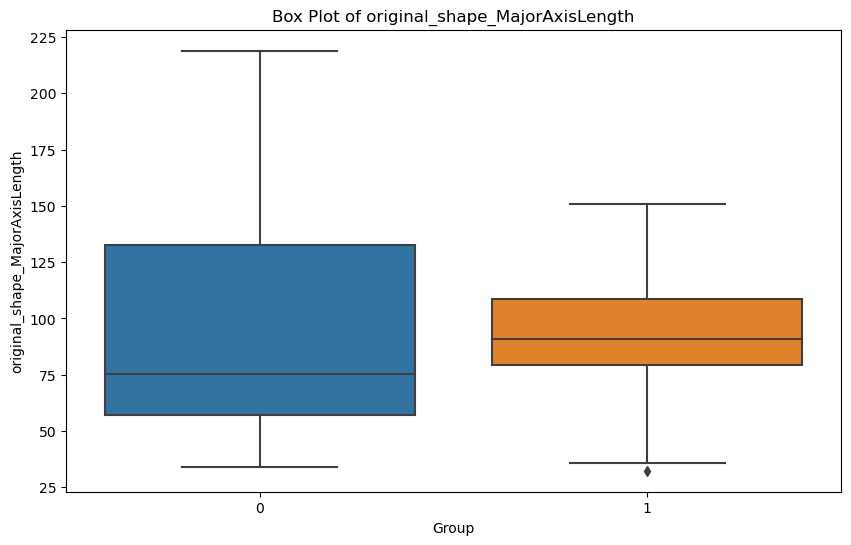

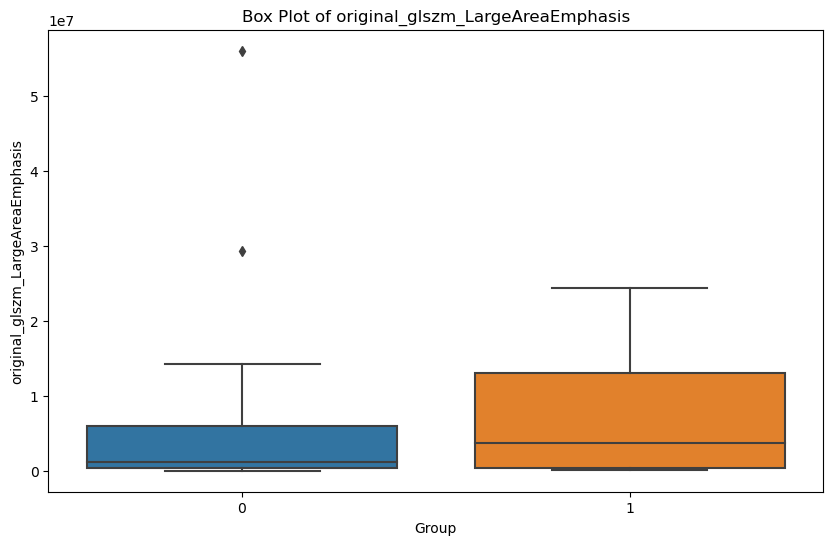

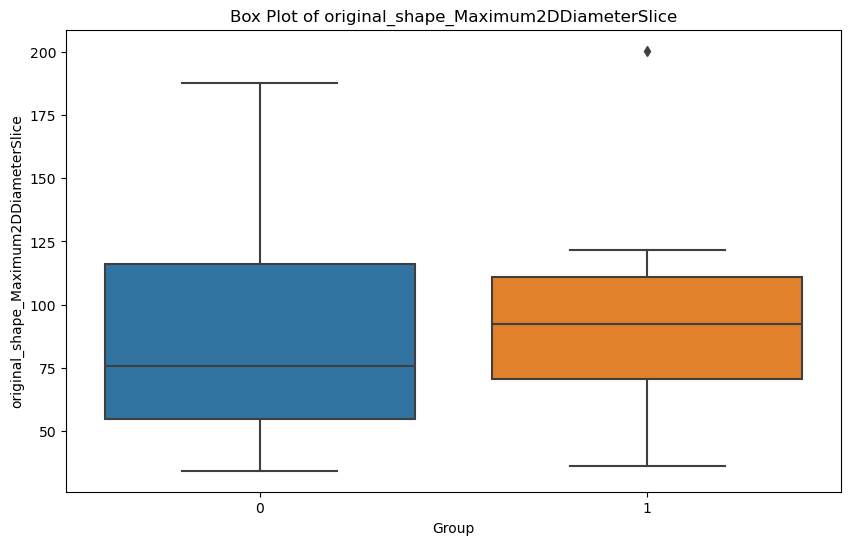

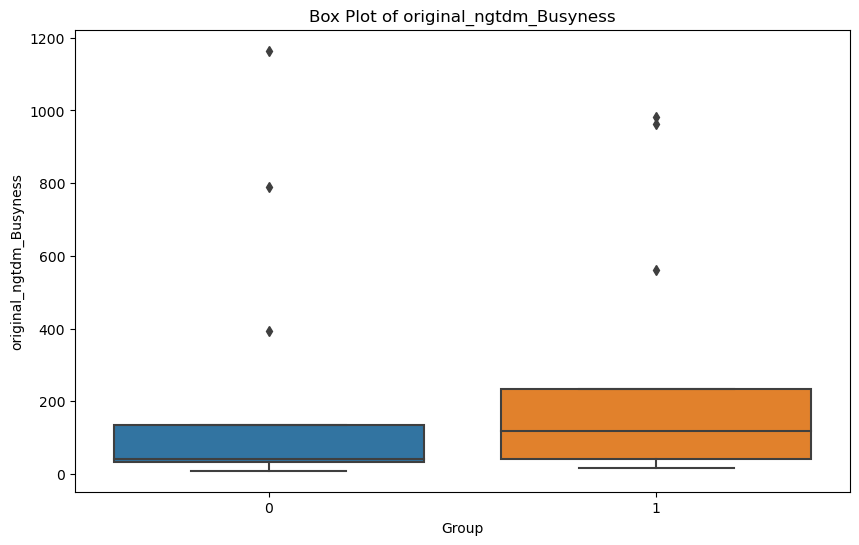

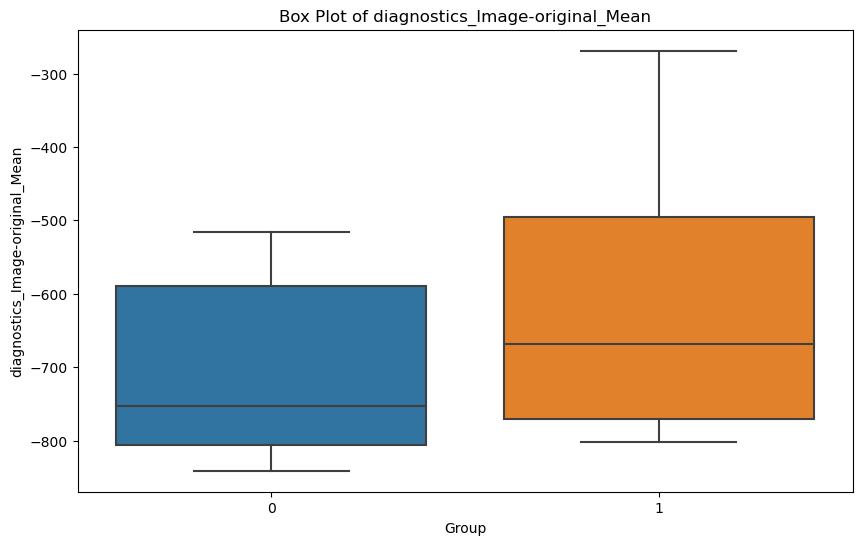

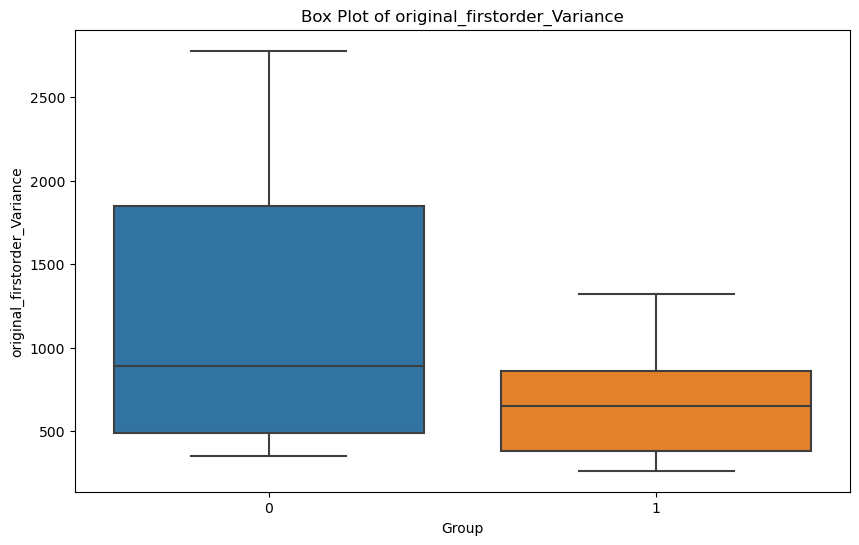

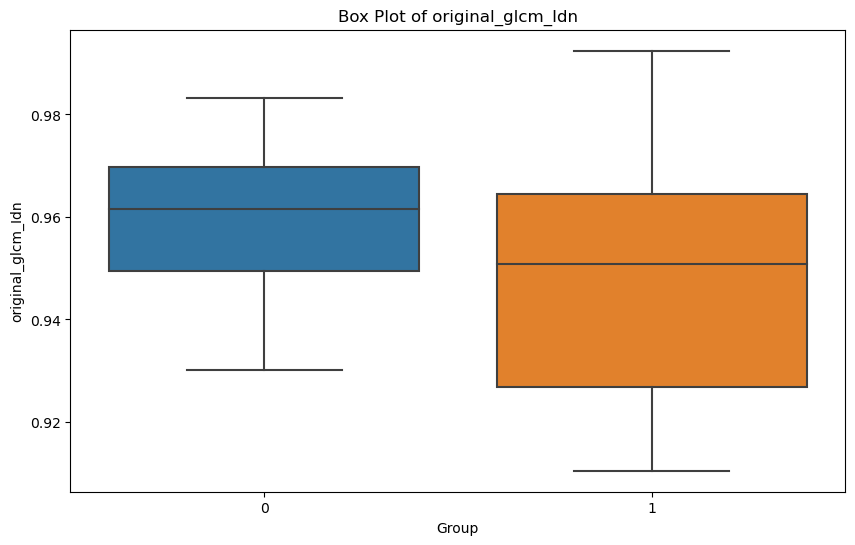

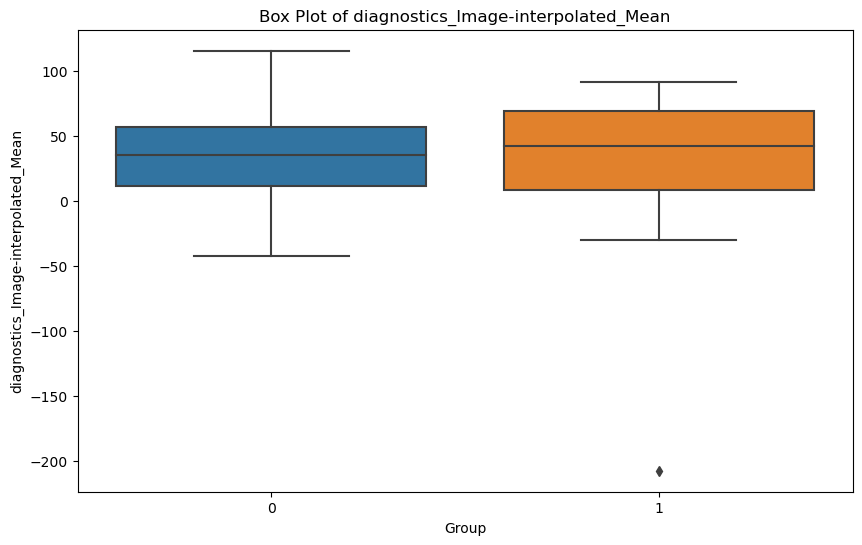

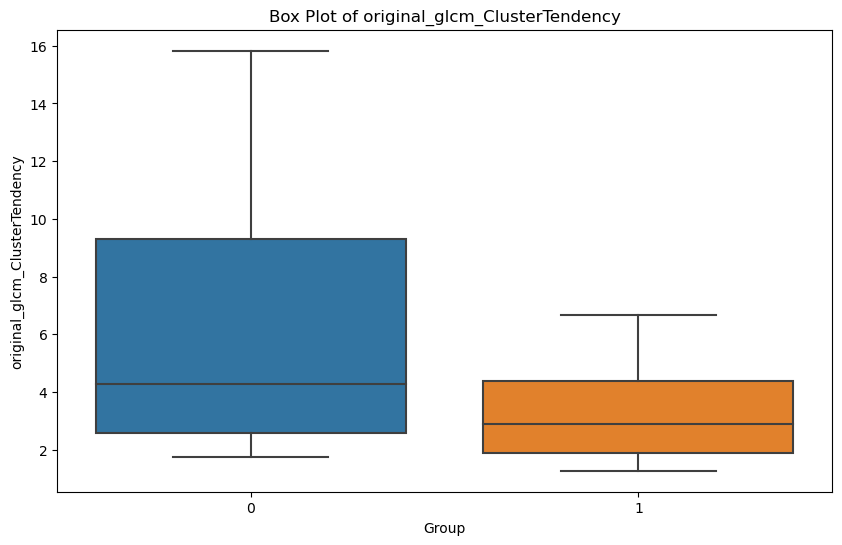

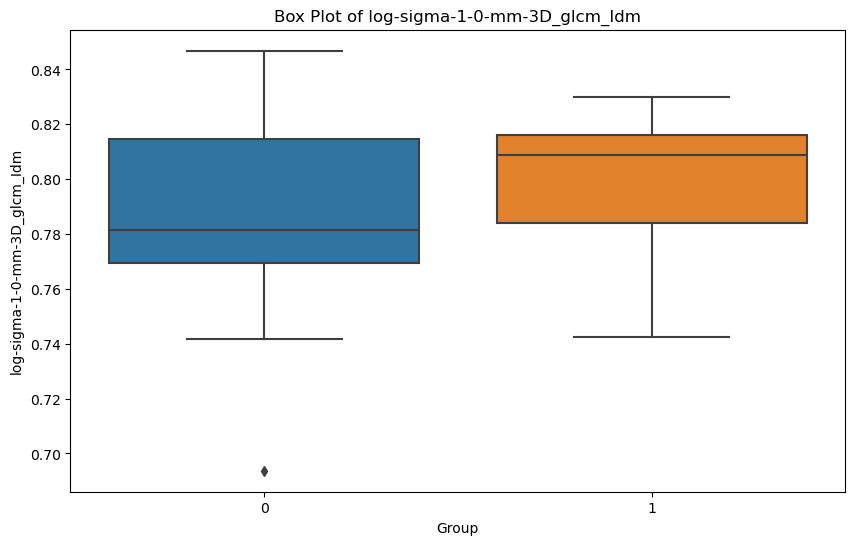

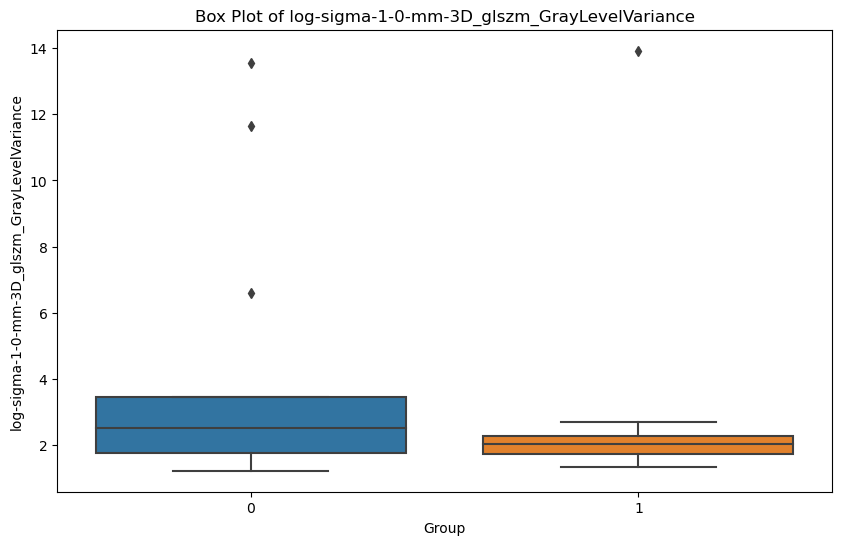

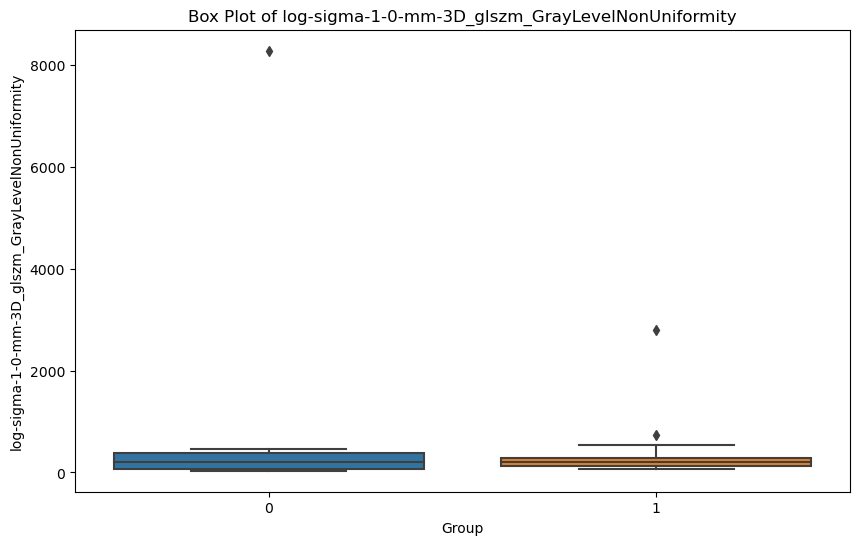

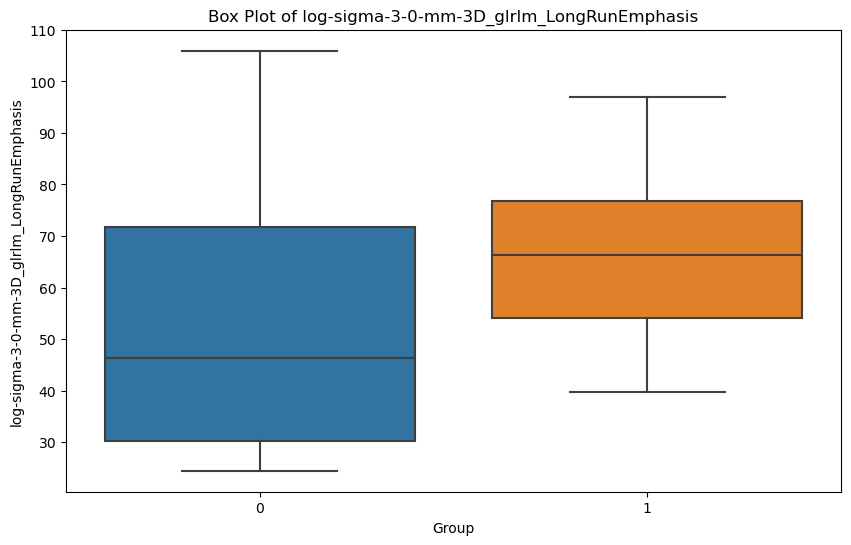

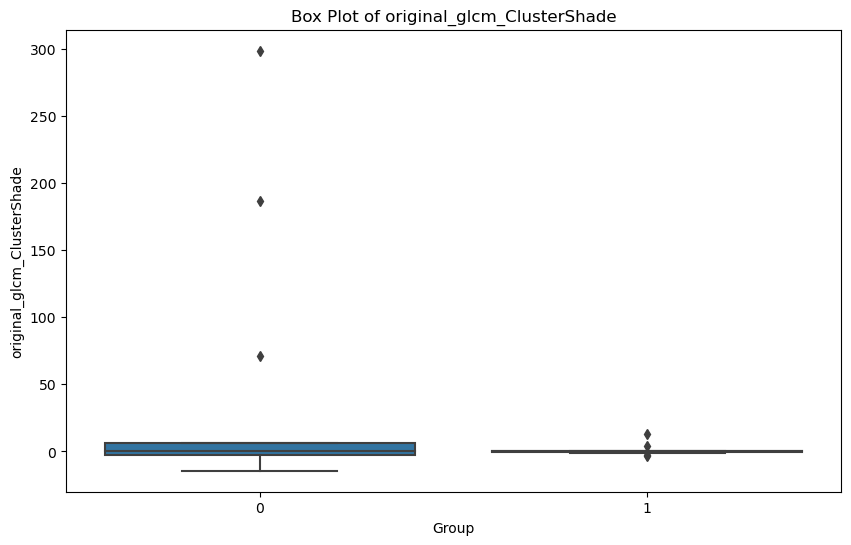

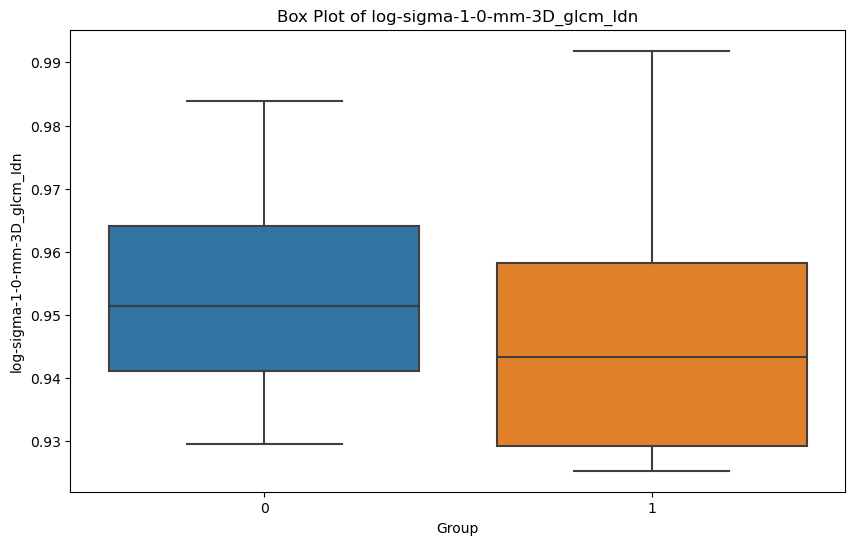

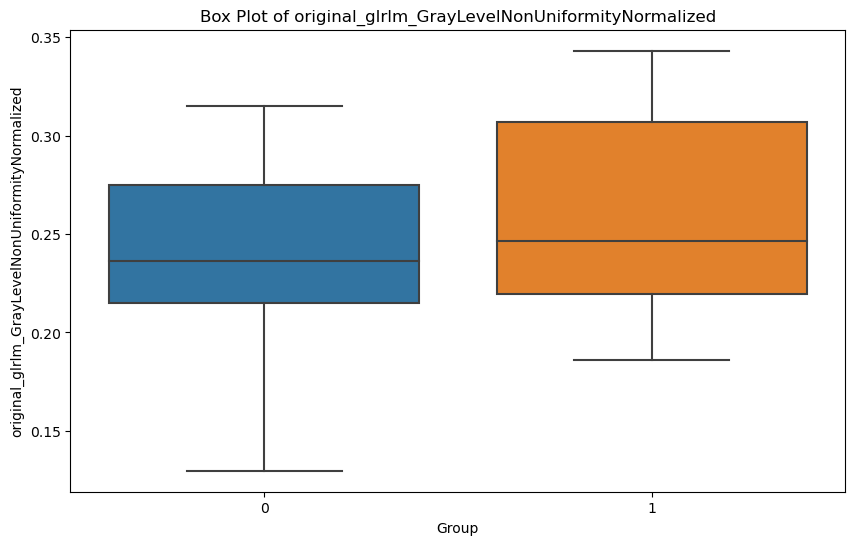

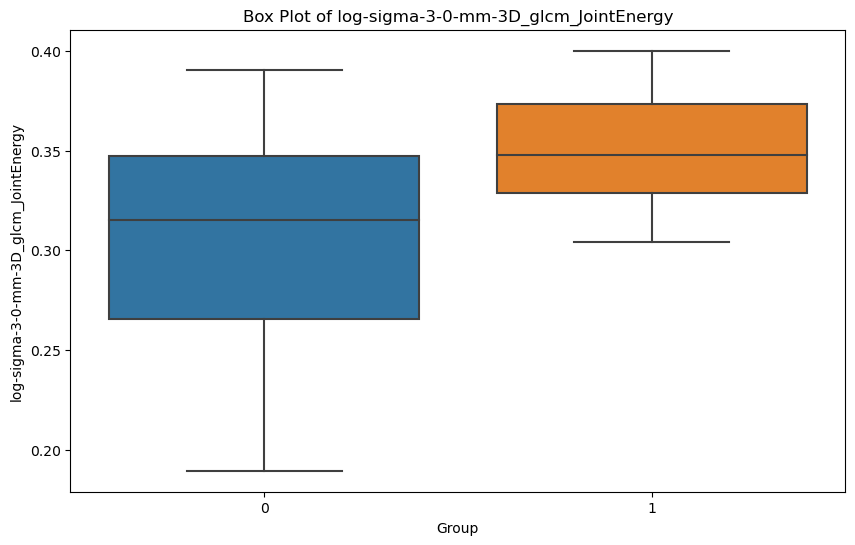

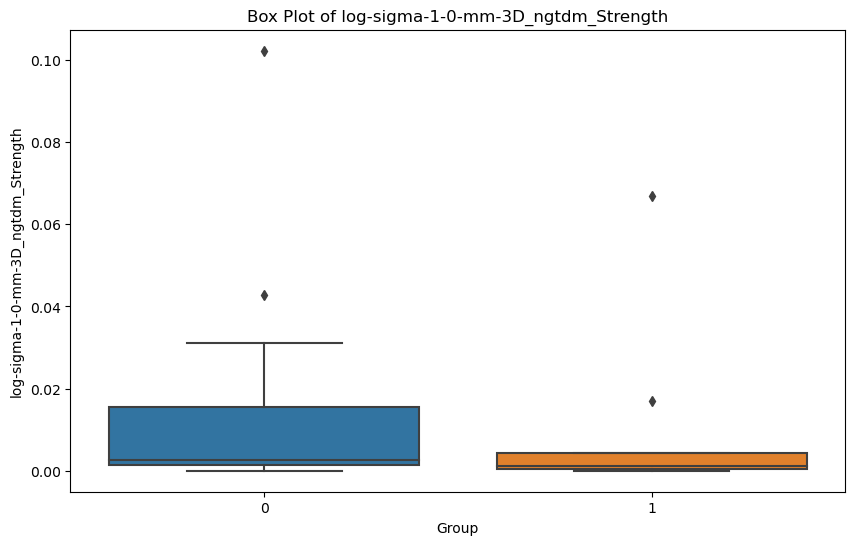

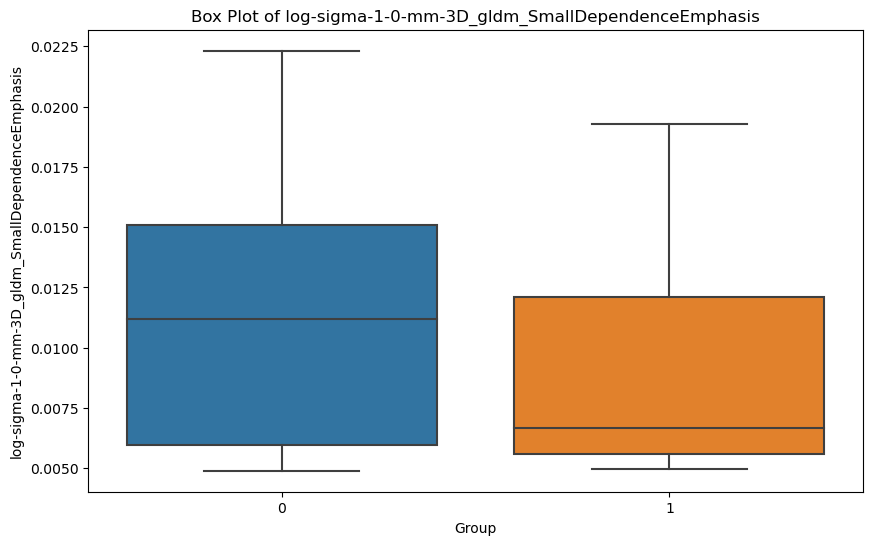

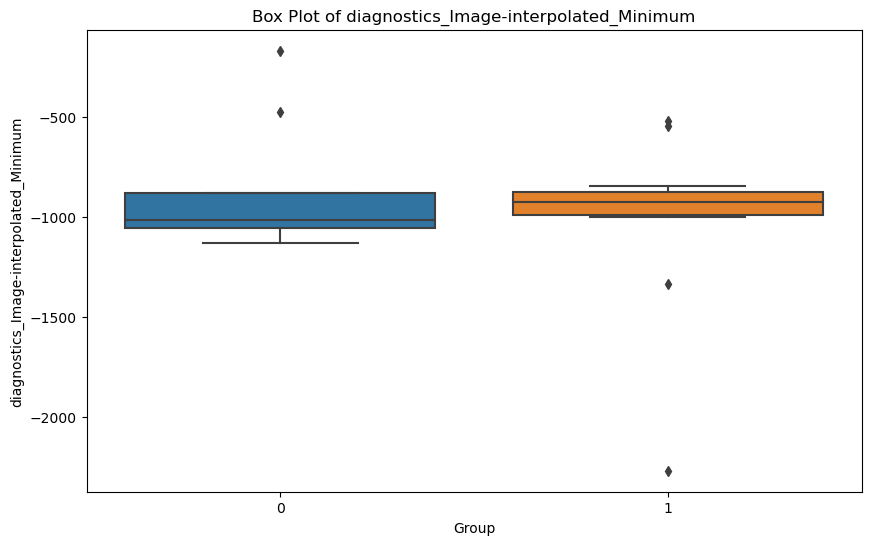

In [190]:
# boxplots of the 20 features chosen by LASSO
plt.figure(figsize=(10, 6))

for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Group', y=feature, data=combined_df)
    plt.title(f'Box Plot of {feature}')
    plt.savefig(f'{feature}_boxplot.png')
    plt.show()

LASSO seems to not have successfully chosen for features with higher means in the high group. Reverting back to features that are statistically significant in the high group (t-test) and have higher values in the high group.

In [9]:
# Calculate mean values for each feature in both groups
high_group_means = combined_df[combined_df['Group'] == 'High'][feature_columns].mean()
low_group_means = combined_df[combined_df['Group'] == 'Low'][feature_columns].mean()

# Filter significant features based on higher mean in the high group
higher_in_high_group = [
    feature for feature in significant_features['Feature']
    if high_group_means[feature] > low_group_means[feature]
]

print("Features that are statistically significant and higher in the high group:")
print(higher_in_high_group)

Features that are statistically significant and higher in the high group:
['original_glszm_GrayLevelNonUniformityNormalized', 'log-sigma-1-0-mm-3D_glcm_Imc1', 'log-sigma-1-0-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis', 'log-sigma-1-0-mm-3D_glszm_GrayLevelNonUniformityNormalized', 'log-sigma-1-0-mm-3D_glszm_LowGrayLevelZoneEmphasis', 'log-sigma-1-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_firstorder_Uniformity', 'log-sigma-2-0-mm-3D_glcm_Id', 'log-sigma-2-0-mm-3D_glcm_Idm', 'log-sigma-2-0-mm-3D_glcm_JointEnergy', 'log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized', 'log-sigma-3-0-mm-3D_firstorder_Uniformity', 'log-sigma-3-0-mm-3D_glcm_Id', 'log-sigma-3-0-mm-3D_glcm_Idm', 'log-sigma-3-0-mm-3D_glcm_JointEnergy', 'log-sigma-3-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized', 'log-sigma-3-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_gldm_LargeDependenceEmphasis', 'wavelet-LLH_glszm_LowGrayLevelZoneEmphasis', 'wavelet-LLH_glszm_SmallAreaLow

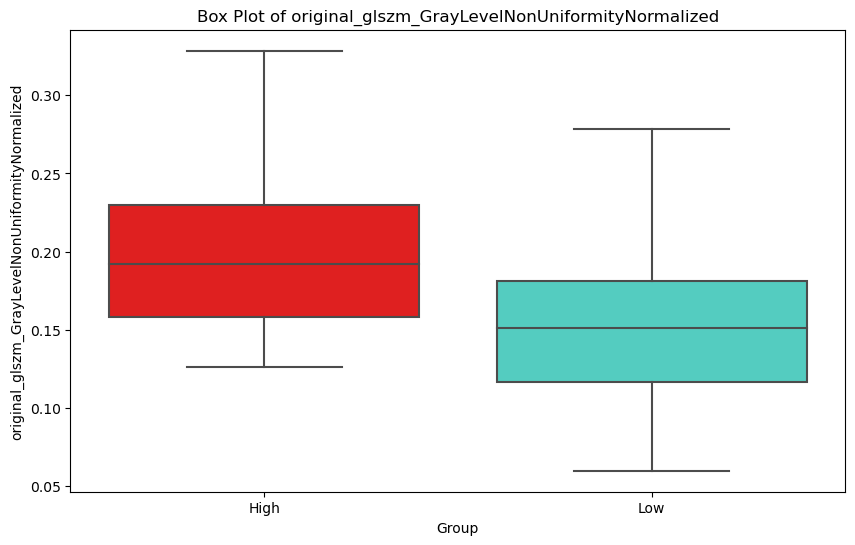

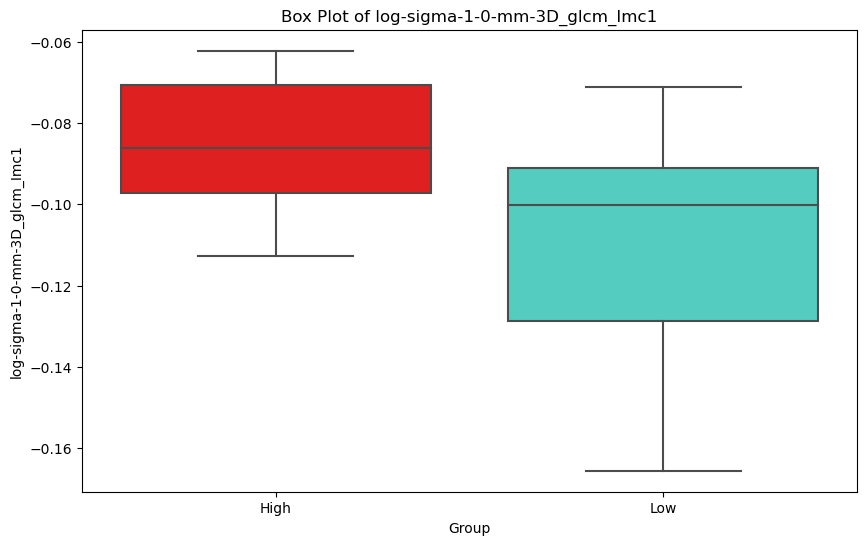

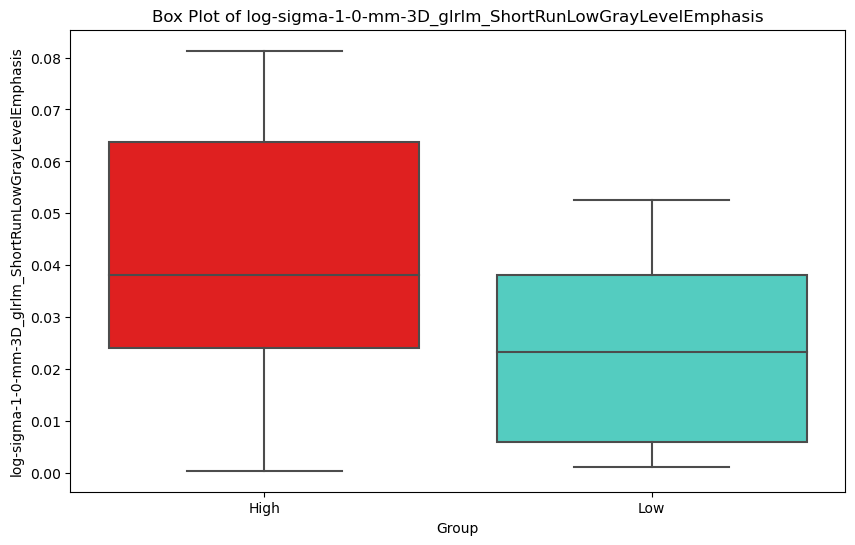

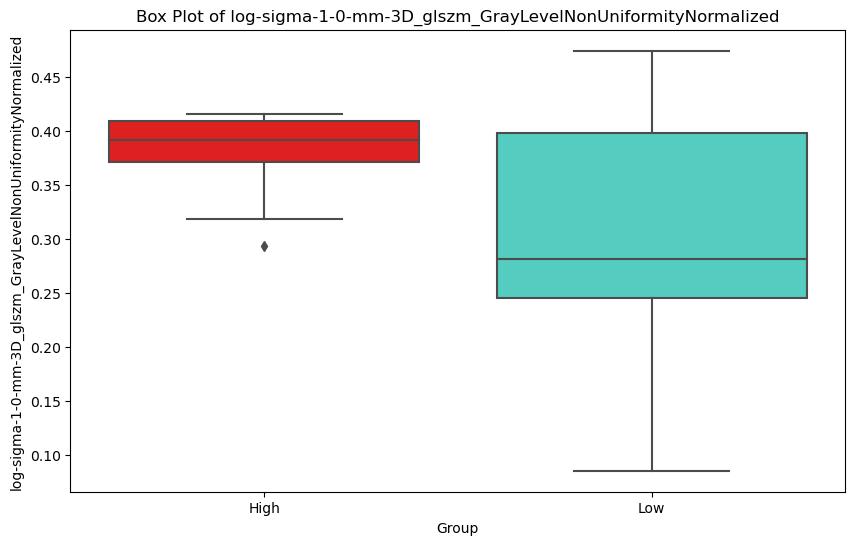

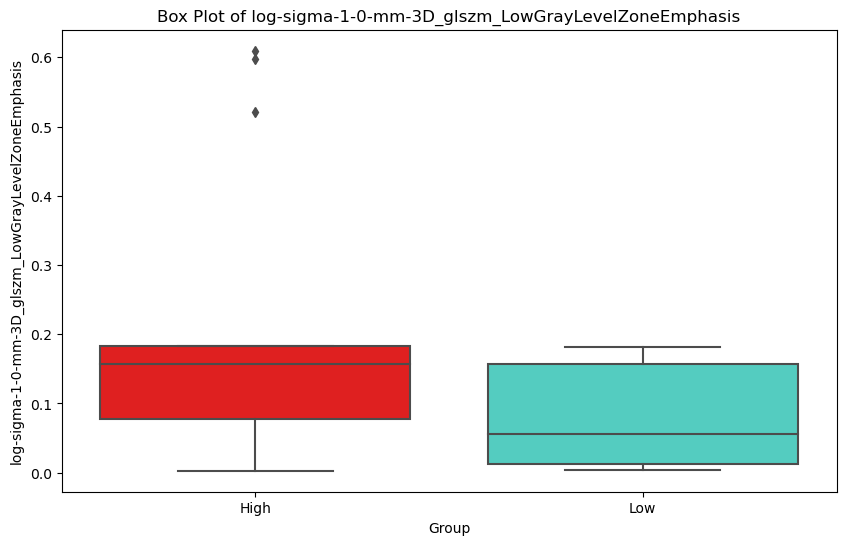

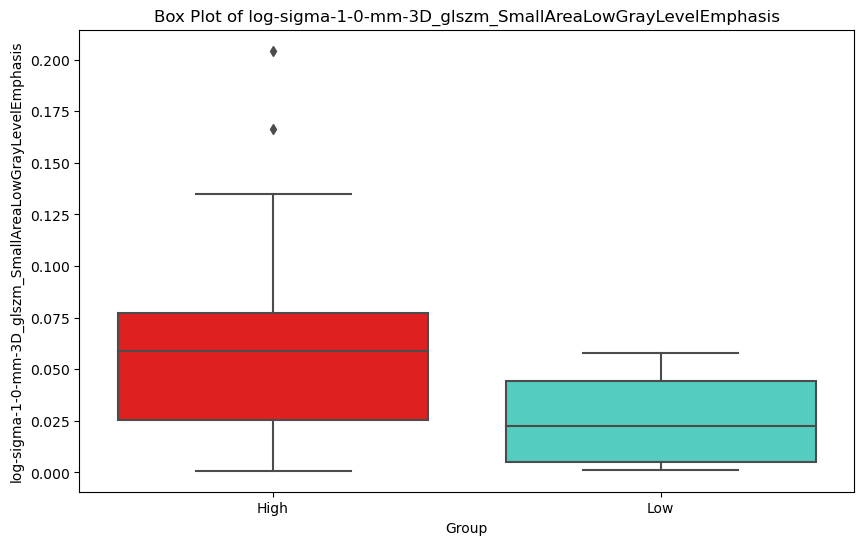

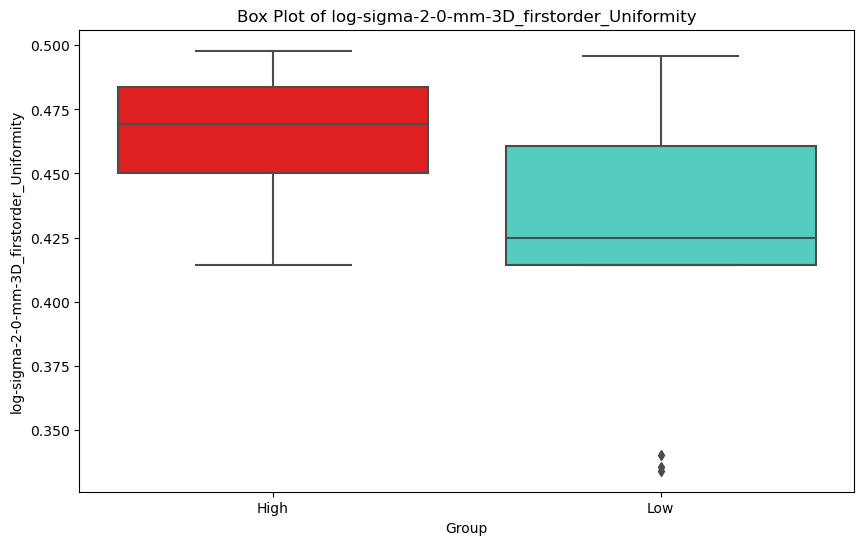

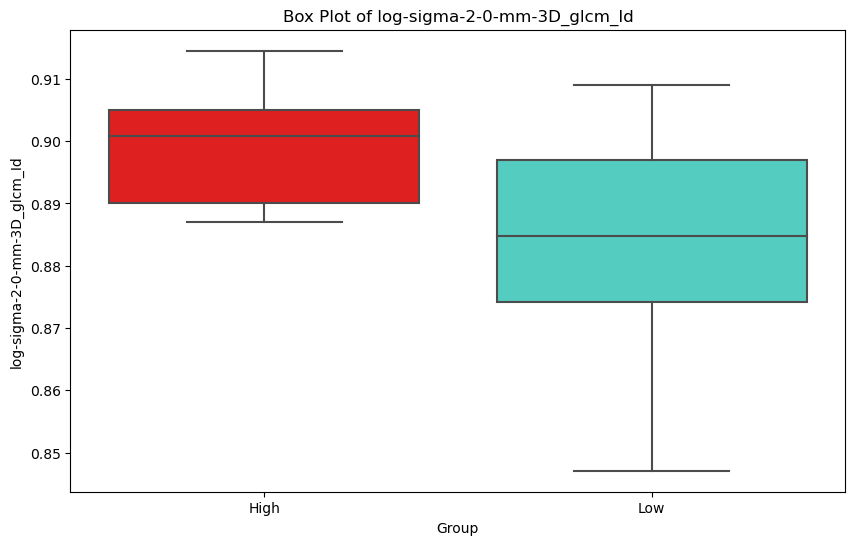

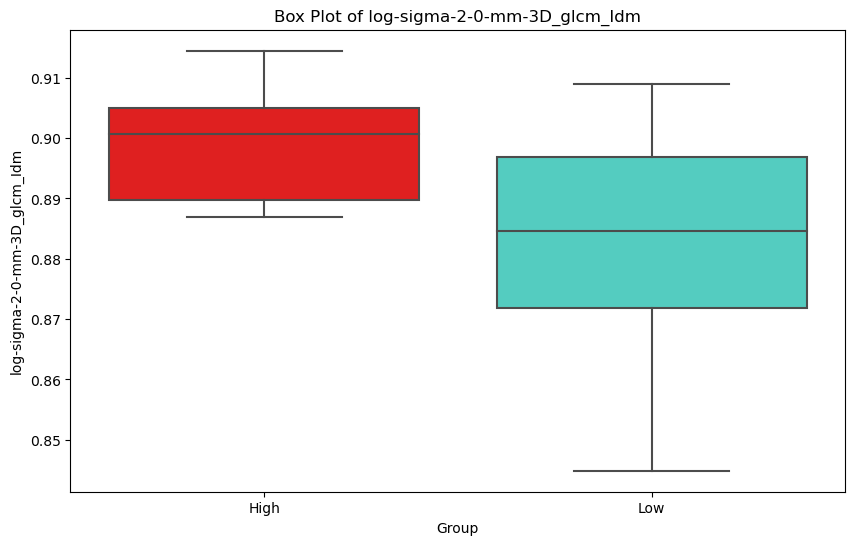

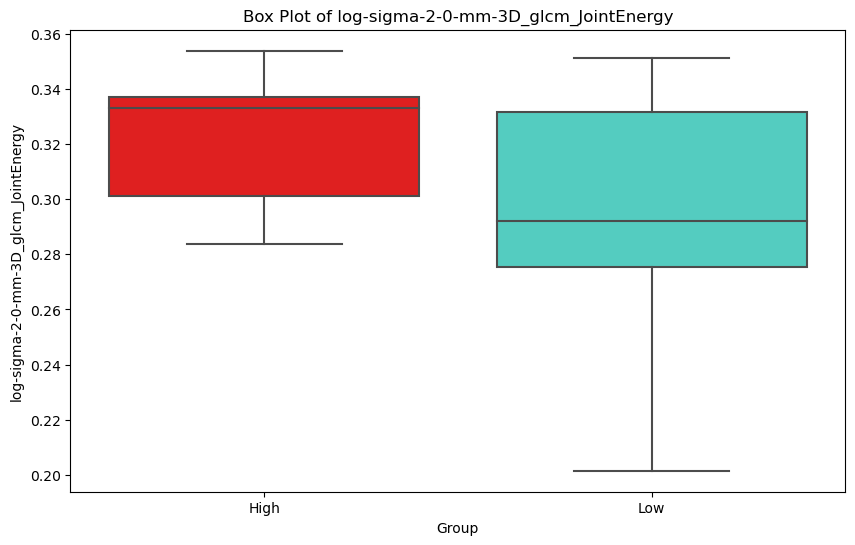

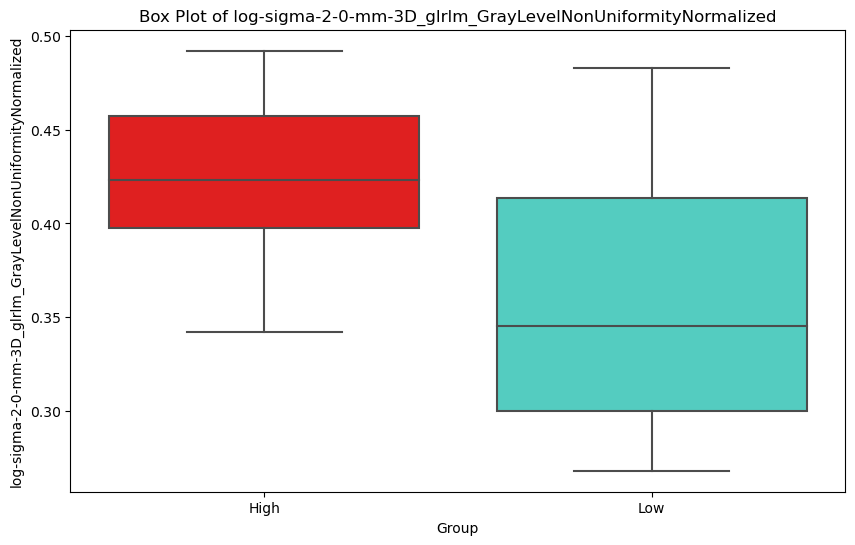

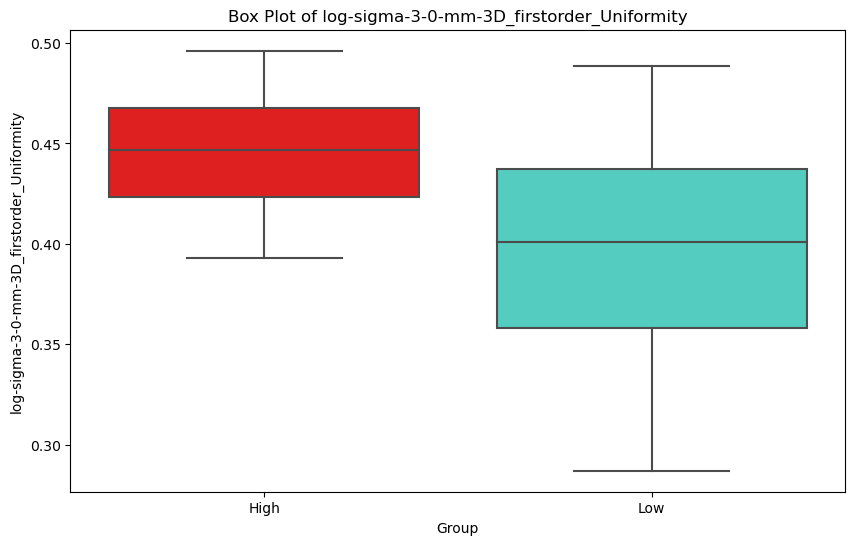

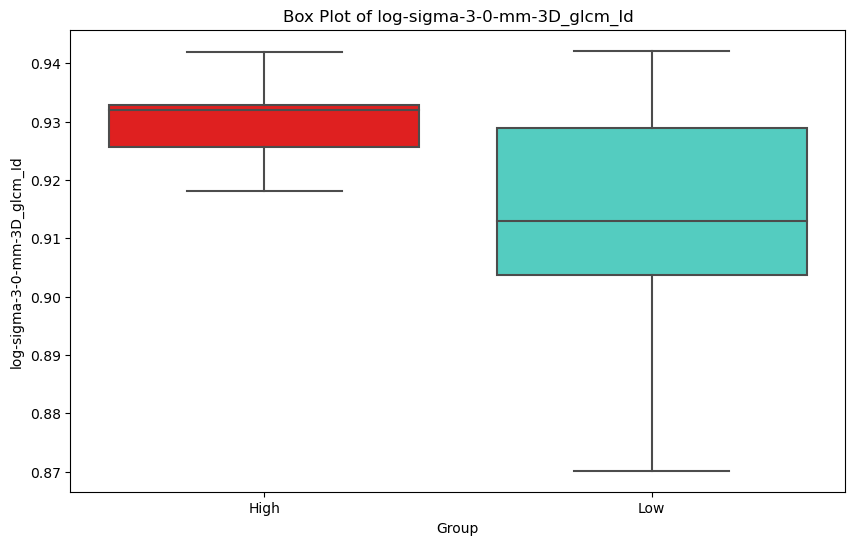

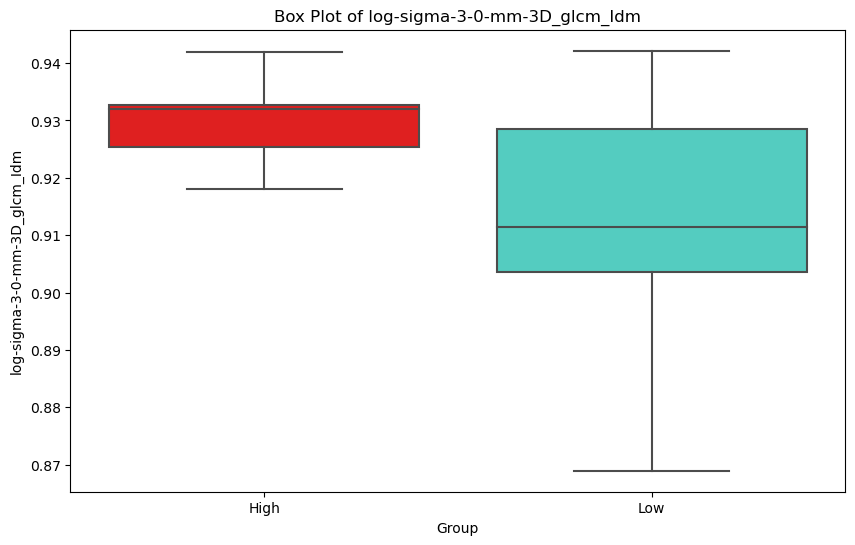

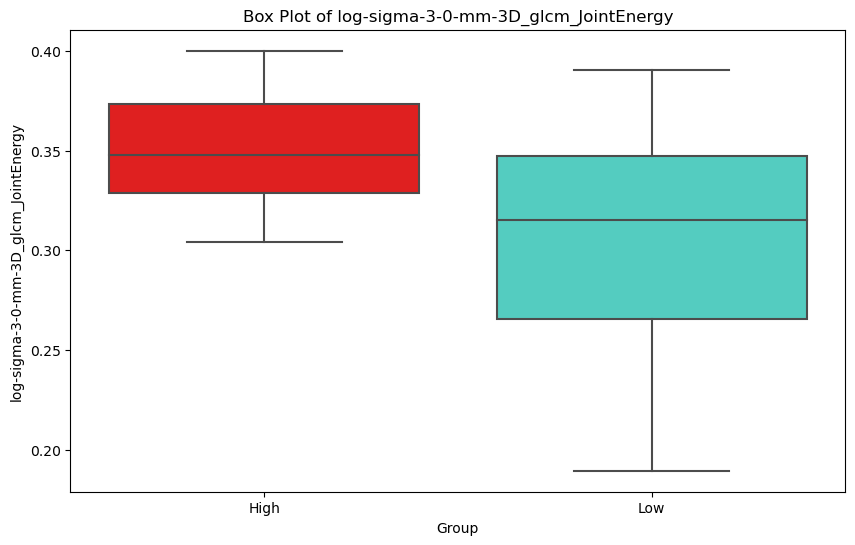

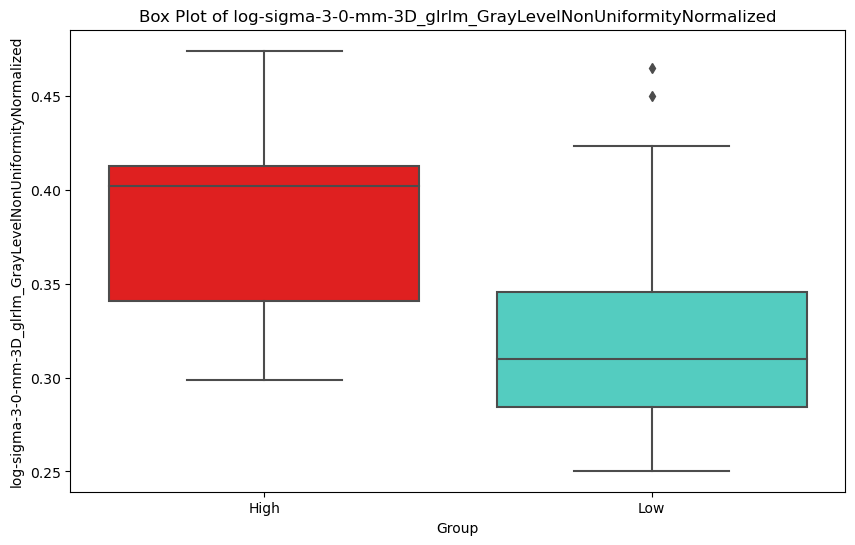

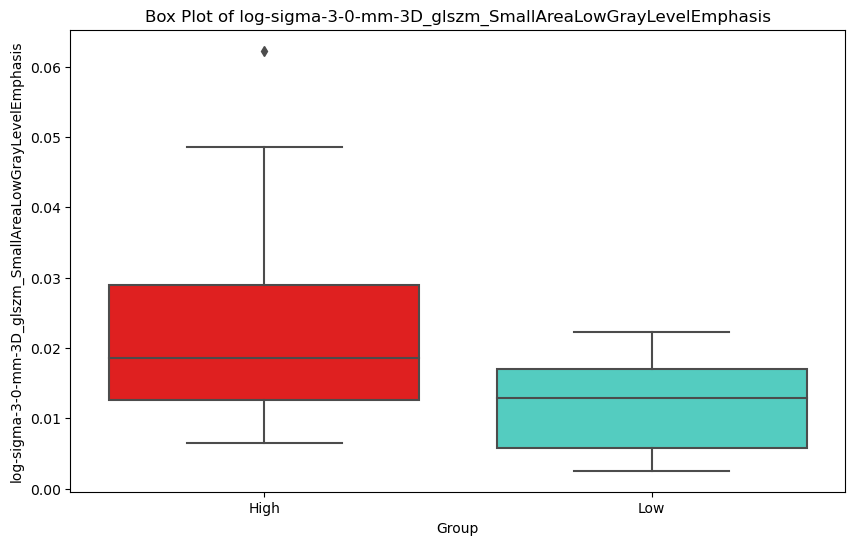

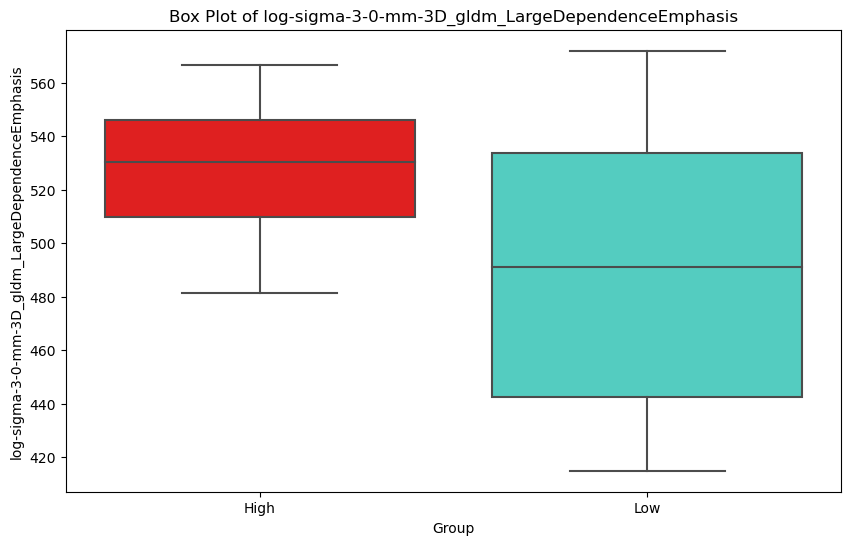

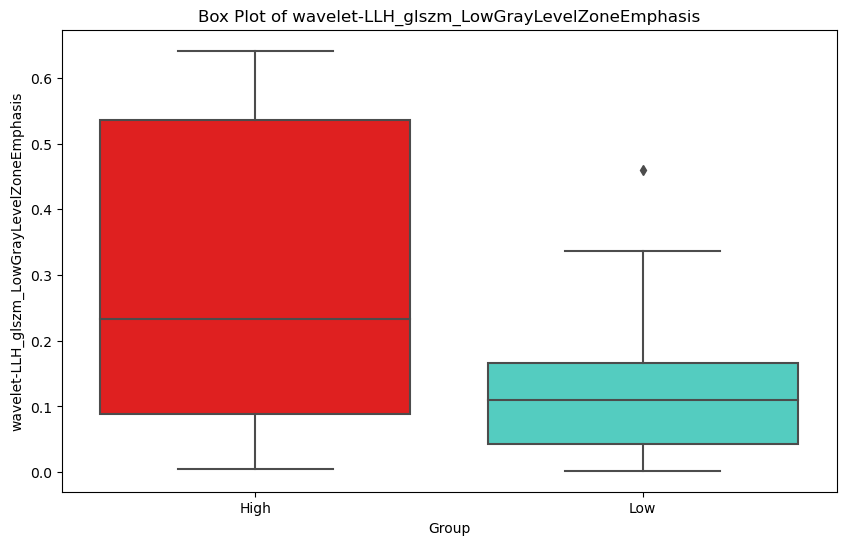

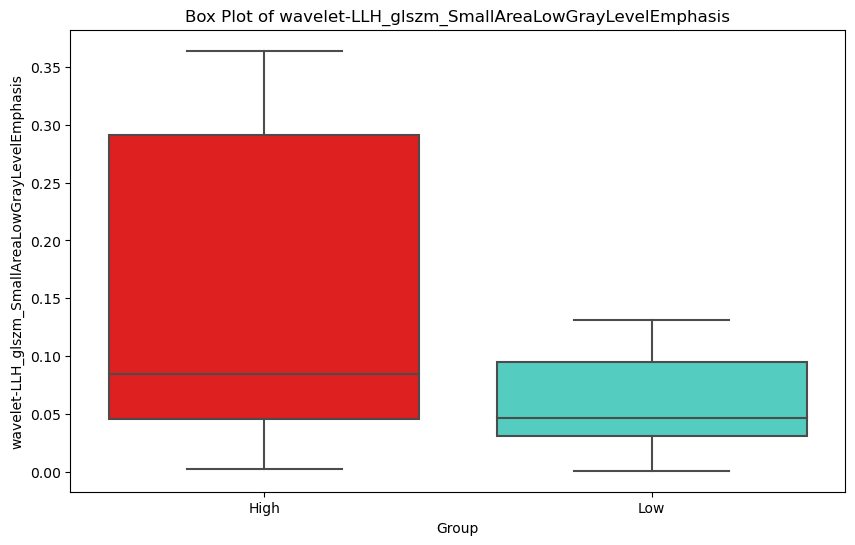

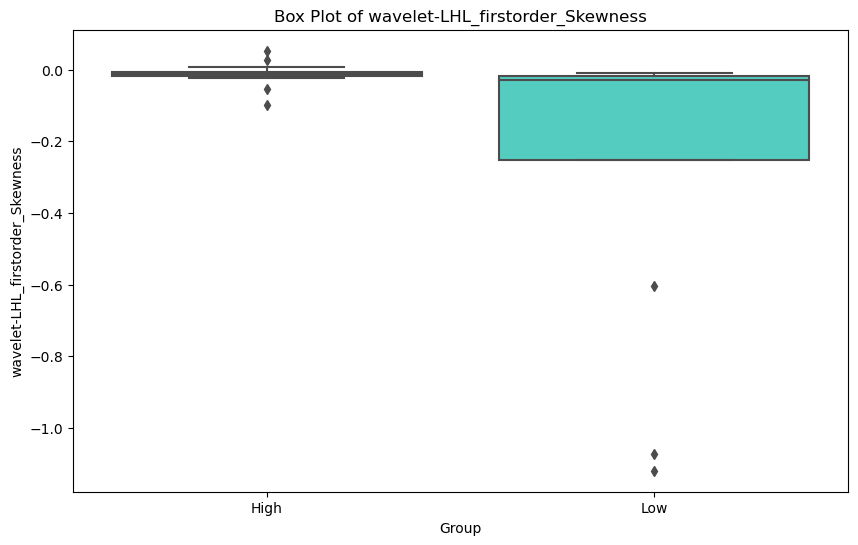

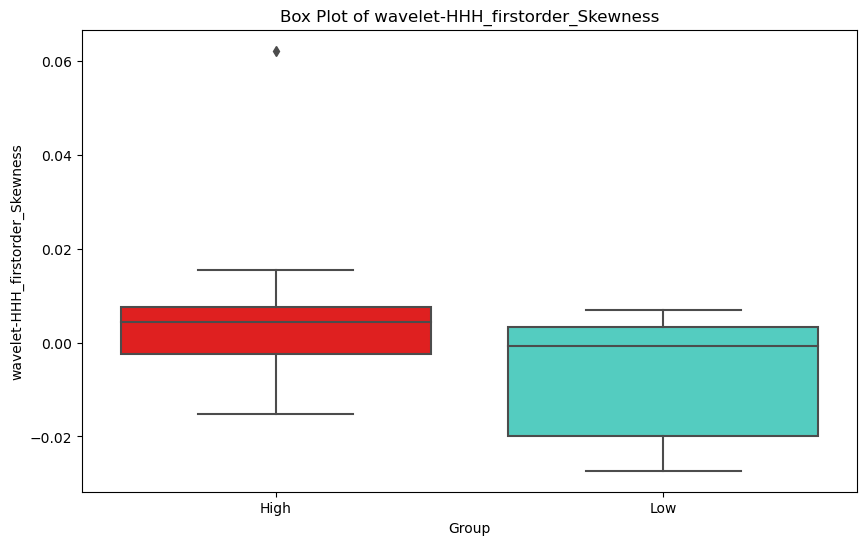

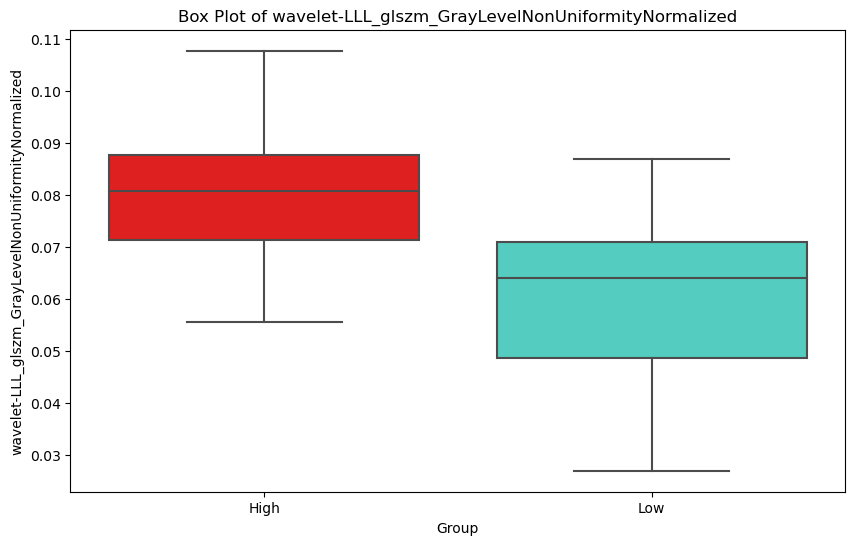

In [198]:
# Boxplots

# Define a custom color palette
custom_palette = {'High': 'red', 'Low': 'turquoise'}

# Create box plots for the selected features
for i, feature in enumerate(higher_in_high_group):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Group', y=feature, data=combined_df, palette=custom_palette)
    plt.title(f'Box Plot of {feature}')
    #plt.savefig(f'/home/evannaughton/project/radiomics_code/plots/BoxPlot_{i}_{feature}.png')
    plt.show()

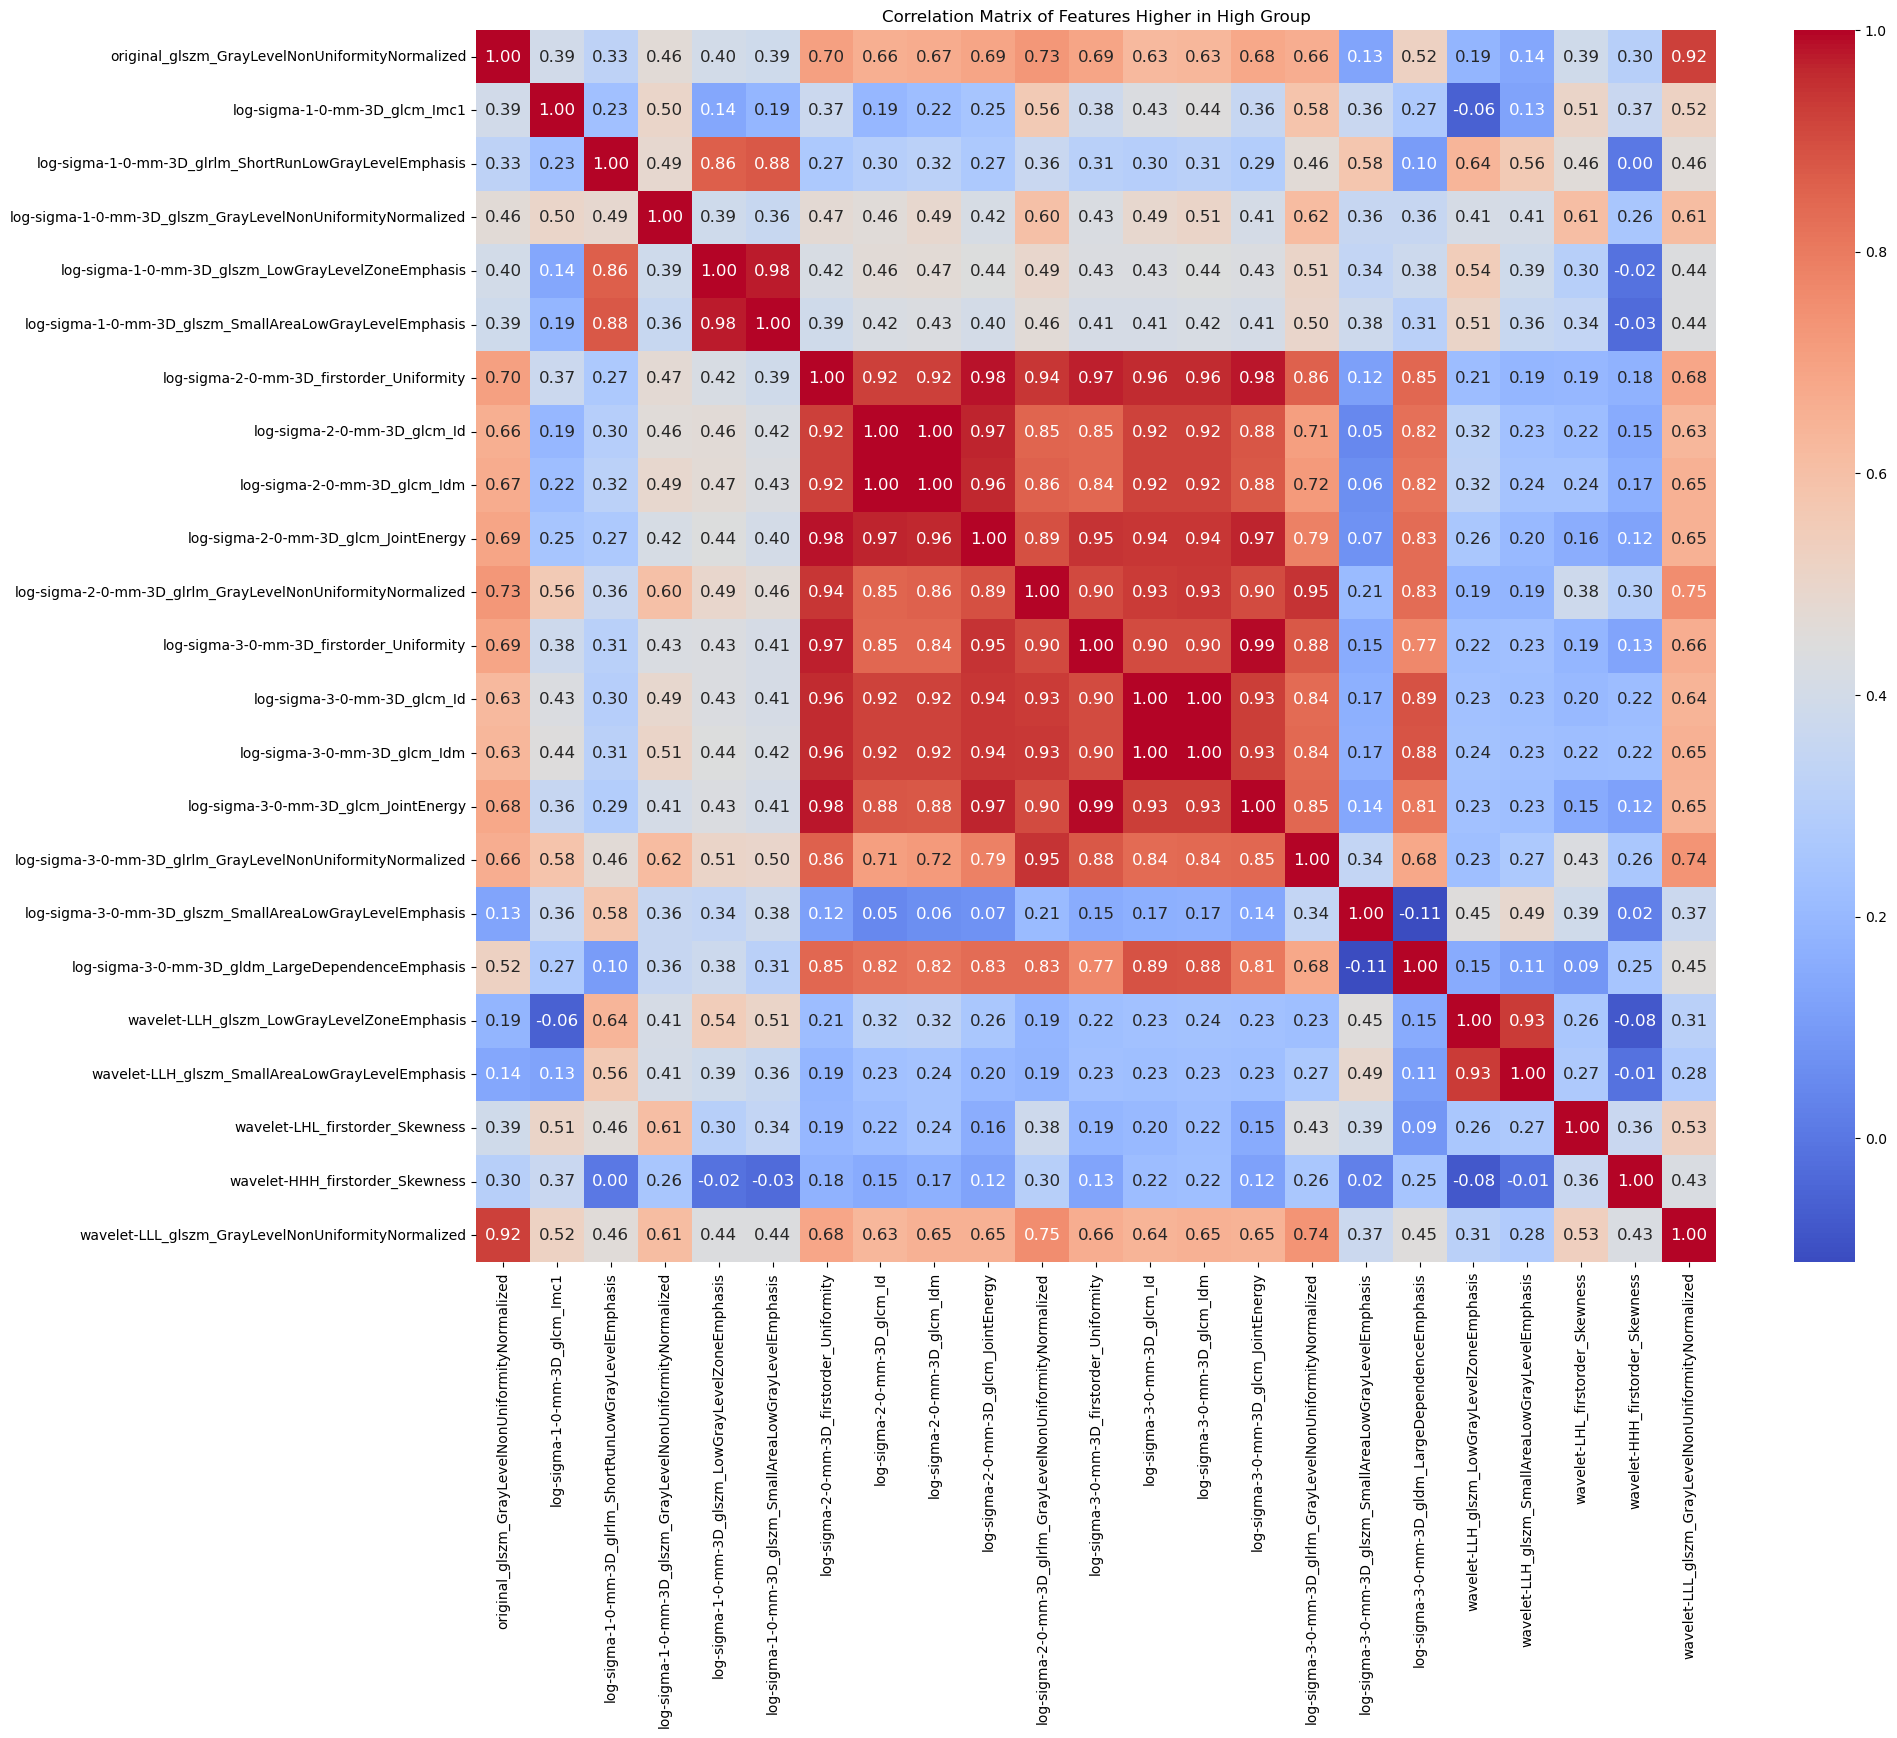

In [10]:
# Compute Pearson correlation matrix for the selected features
correlation_matrix = combined_df[higher_in_high_group].corr()

# Display the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 12})
plt.title('Correlation Matrix of Features Higher in High Group')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('/home/evannaughton/project/radiomics_code/plots/High_Group_Feature_Correlation_Matrix.png', dpi=250, bbox_inches='tight')
plt.show()

Based on the Pearson correlation matrix:

Strong Positive Correlations:

There is a distinct block of redness right in the centre of the matrix indicating redundancy between this set of features
Features with high correlations should be reviewed, and one representative feature should be selected from each correlated group to reduce redundancy and model complexity.

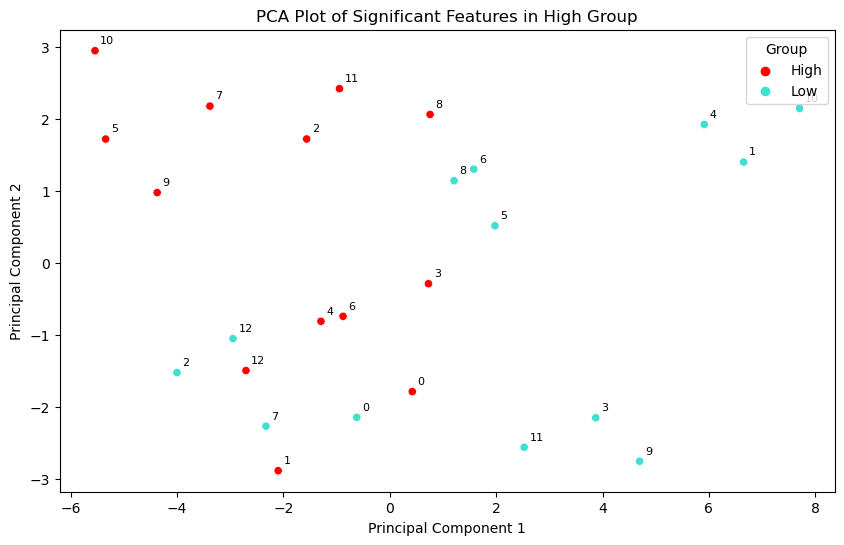

In [46]:
# Creating a PCA plot to view clustering before removing highly correlated features

# Select significant features higher in the high group 
combined_df_high = combined_df[higher_in_high_group]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_df_high)

# Define a custom color palette
custom_palette = {'High': 'red', 'Low': 'turquoise'}

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Group'] = combined_df['Group']
pca_df['ID'] = combined_df['ID']

# Create a scatter plot for the PCA results
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='PC1', y='PC2', hue='Group', data=pca_df, palette=custom_palette)
plt.title('PCA Plot of Significant Features in High Group')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Label each point with the sample ID
for i in range(pca_df.shape[0]):
    plt.text(x=pca_df.PC1[i]+0.1, y=pca_df.PC2[i]+0.1, s=str(pca_df.ID[i]), 
             fontdict=dict(color='black', size=8),
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0))

plt.savefig('/home/evannaughton/project/radiomics_code/plots/pca_plot_labeled.png')
plt.show()

The PCA plot above shows how the significant features in the high group (statistically significantly higher in the high group compared to the low group) separate the samples overall. The two colors (blue for high and orange for low) represent the group labels assigned to each sample.

The aim is to see if the selected features (again, higher in the high group) can still distinguish between the high and low groups when visualized in a reduced dimension. If these features are good discriminators, you would expect some degree of separation between the two groups in the PCA plot.

The features selected are those that are significantly higher in the high group. This means they are important in distinguishing between high and low groups. PCA then reduces the dimensions to visualize how these features behave across all samples, including both high and low groups. The PCA plot shows how these features collectively contribute to the variance in the data.

I can now remove some of the highly correlated features and then visualise them again via correlation matrix and another PCA plot.

Dropped features due to high correlation: ['log-sigma-1-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis', 'log-sigma-2-0-mm-3D_glcm_Id', 'log-sigma-2-0-mm-3D_glcm_Idm', 'log-sigma-2-0-mm-3D_glcm_JointEnergy', 'log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized', 'log-sigma-3-0-mm-3D_firstorder_Uniformity', 'log-sigma-3-0-mm-3D_glcm_Id', 'log-sigma-3-0-mm-3D_glcm_Idm', 'log-sigma-3-0-mm-3D_glcm_JointEnergy', 'log-sigma-3-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized', 'wavelet-LLH_glszm_SmallAreaLowGrayLevelEmphasis', 'wavelet-LLL_glszm_GrayLevelNonUniformityNormalized']
Remaining features after dropping highly correlated ones:


original_glszm_GrayLevelNonUniformityNormalized  \
0                                         0.137722   
1                                         0.243797   
2                                         0.190897   
3                                         0.126528   
4                                         0.140131   

   log-sigma-1-0-mm-3D_glcm_Imc1  \
0                      -0.063684   
1                      -0.086159   
2                      -0.062173   
3                      -0.099410   
4                      -0.112819   

   log-sigma-1-0-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis  \
0                                           0.008293        
1                                           0.000472        
2                                           0.063716        
3                                           0.028022        
4                                           0.038072        

   log-sigma-1-0-mm-3D_glszm_GrayLevelNonUniformityNormalized  \
0                                           0.415152            
1                                           0.293555            
2                                           0.391310            
3                                           0.409303            
4                                           0.324968            

   log-sigma-1-0-mm-3D_glszm_LowGrayLevelZoneEmphasis  \
0                                           0.016035    
1                                           0.002899    
2                                           0.172027    
3                                           0.077114    
4                                           0.156988    

   log-sigma-2-0-mm-3D_firstorder_Uniformity  \
0                                   0.450108   
1                                   0.483763   
2                                   0.452858   
3                                   0.433773   
4                                   0.469126   

   log-sigma-3-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis  \
0                                           0.006489         
1                                           0.007034         
2                                           0.062269         
3                                           0.013698         
4                                           0.012586         

   log-sigma-3-0-mm-3D_gldm_LargeDependenceEmphasis  \
0                                        530.446753   
1                                        546.091167   
2                                        481.452827   
3                                        509.993496   
4                                        524.903207   

   wavelet-LLH_glszm_LowGrayLevelZoneEmphasis  \
0                                    0.004016   
1                                    0.056130   
2                                    0.088389   
3                                    0.156548   
4                                    0.197013   

   wavelet-LHL_firstorder_Skewness  wavelet-HHH_firstorder_Skewness  
0                        -0.016916                         0.001795  
1                        -0.100021                         0.062172  
2                         0.052631                         0.015390  
3                        -0.023155                         0.006380  
4                        -0.013500                         0.000656

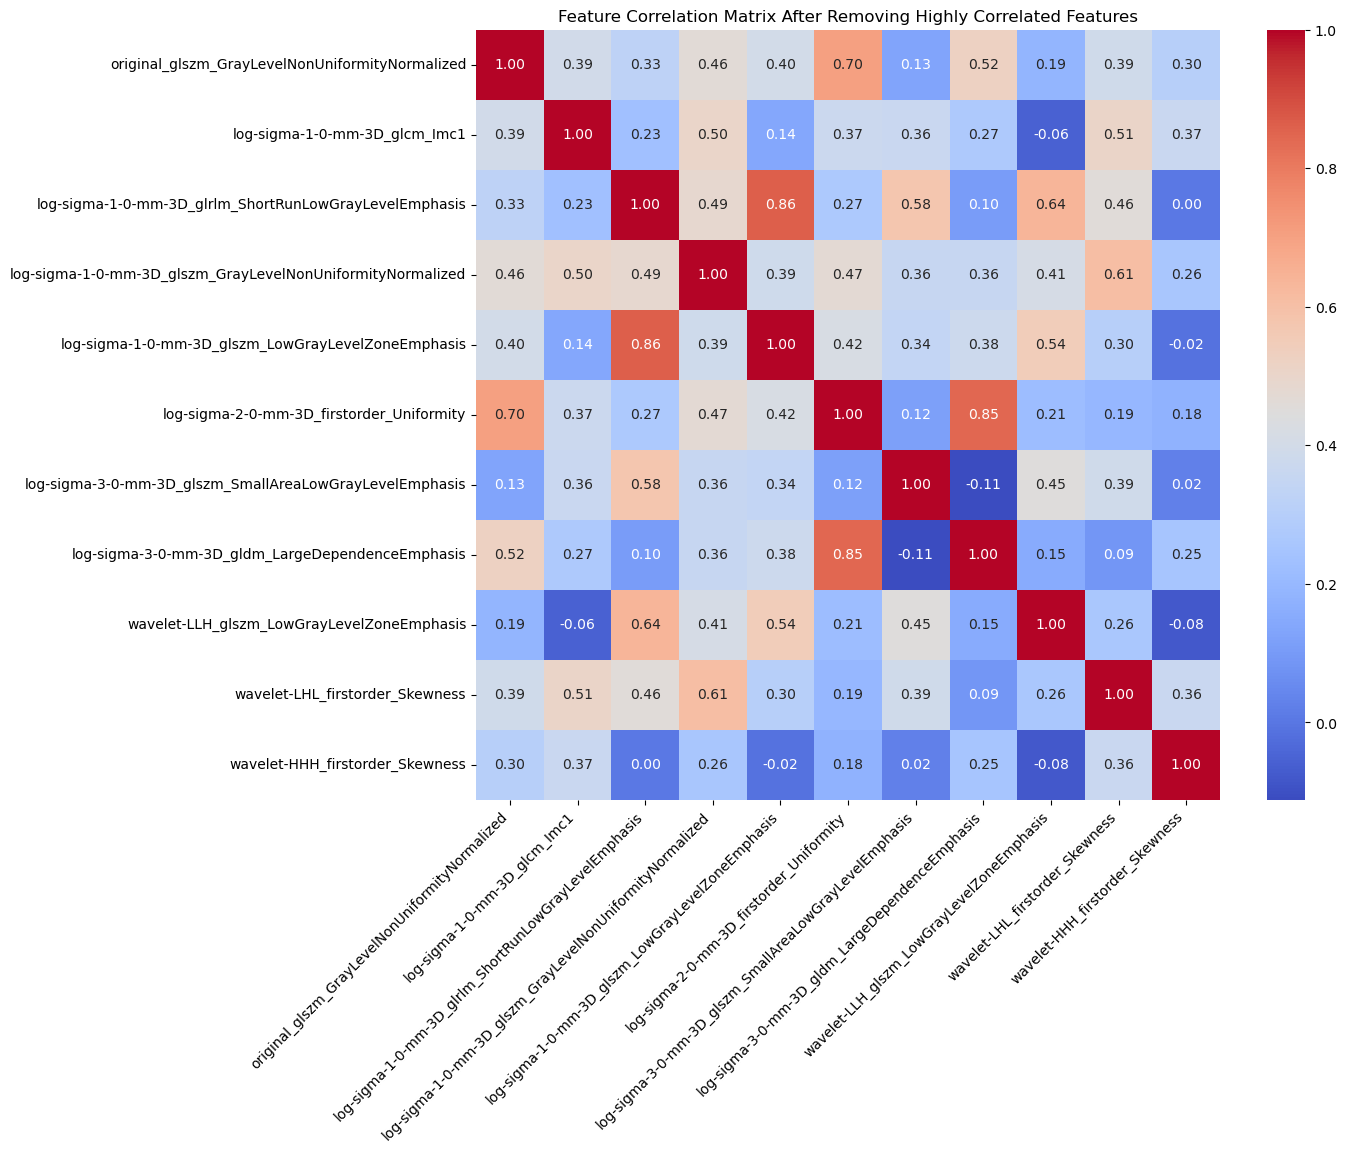

In [11]:
# Creating a function to remove highly correlated features (dimensionality reduction)

def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    reduced_df = df.drop(columns=to_drop)
    return reduced_df, to_drop

# Use the function on combined DF (excluding non-feature columns)
combined_df_cleaned, dropped_features = remove_highly_correlated_features(combined_df[higher_in_high_group])

print("Dropped features due to high correlation:", dropped_features)
print("Remaining features after dropping highly correlated ones:")
display(combined_df_cleaned.head())

# Correlation matrix for the cleaned DataFrame
correlation_matrix_cleaned = combined_df_cleaned.corr()

# Cleaned correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_cleaned, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0) 
plt.title('Feature Correlation Matrix After Removing Highly Correlated Features')

# Save plot 
plt.savefig('/home/evannaughton/project/radiomics_code/plots/correlation_matrix_cleaned.png', format='png', dpi=250, bbox_inches='tight')

plt.show()

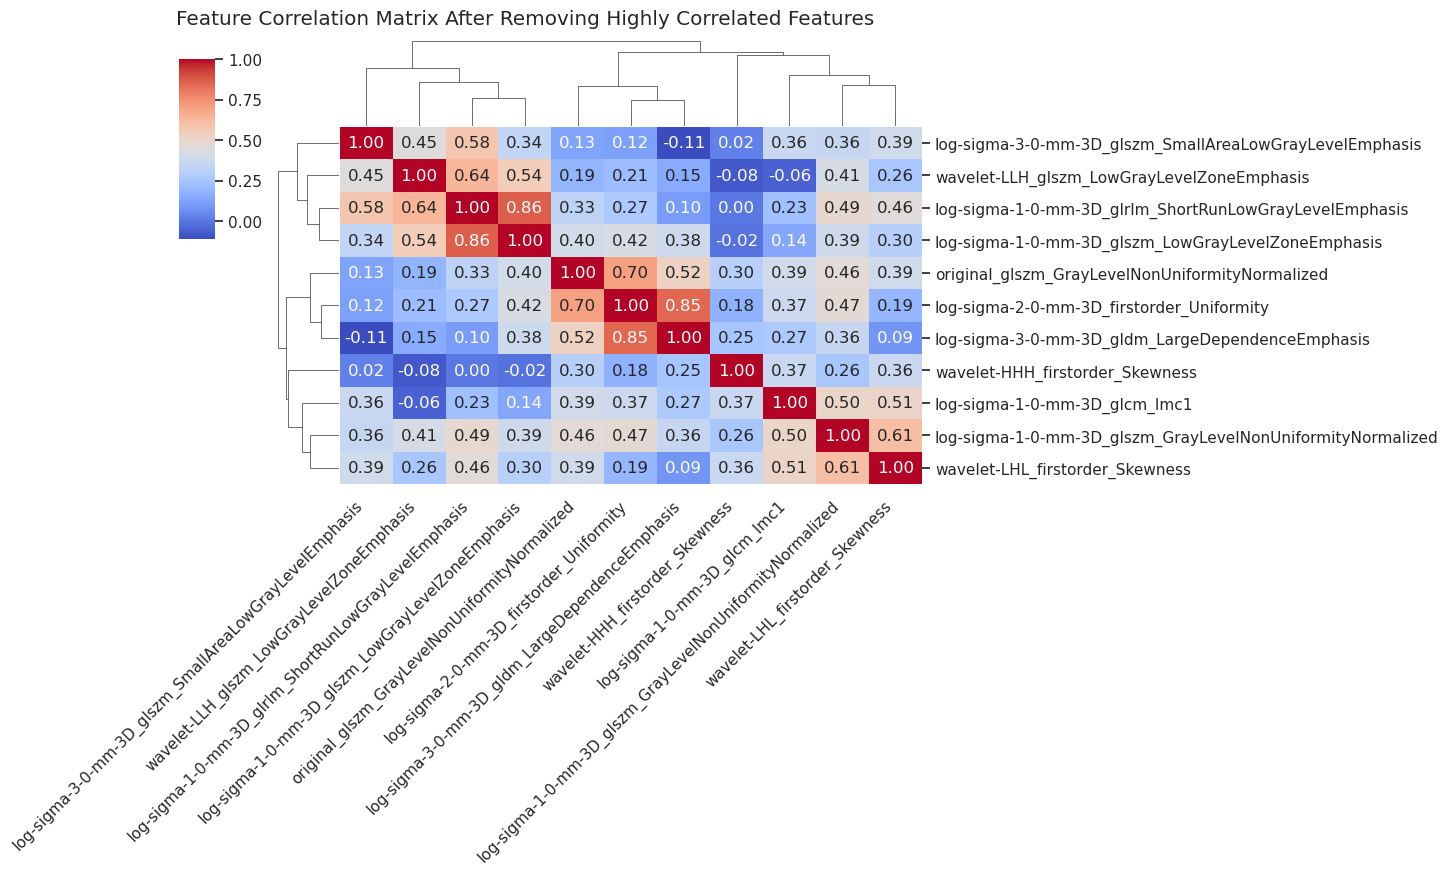

In [47]:
# Cleaned correlation matrix with hierarchical clustering
sns.set(context="notebook", font_scale=1.0)
g = sns.clustermap(correlation_matrix_cleaned, annot=True, cmap='coolwarm', fmt='.2f', figsize=(12, 10), 
                   dendrogram_ratio=(.1, .2), cbar_pos=(-0.065, 0.78, .03, .18), xticklabels=1, yticklabels=1)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.suptitle('Feature Correlation Matrix After Removing Highly Correlated Features', x=0.515, y=1.01, ha='right')
plt.savefig('/home/evannaughton/project/radiomics_code/plots/correlation_matrix_cleaned_clustermap.png', format='png', dpi=250)
plt.show()

This updated correlation matrix above looks better, as it shows a wider variety of correlation values and fewer high correlations, indicating reduced redundancy among the features. I can now visualise a PCA of the samples again based on these features.

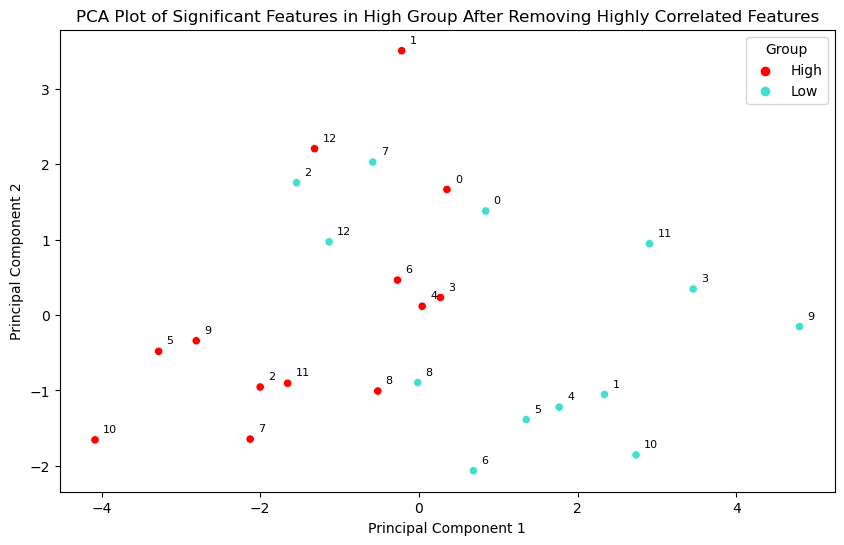

In [49]:
# Standardize cleaned data
scaler = StandardScaler()
scaled_data_cleaned = scaler.fit_transform(combined_df_cleaned)

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data_cleaned)

# Create a DataFrame with the principal components
pca_df_cleaned = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df_cleaned['Group'] = combined_df['Group']
pca_df_cleaned['ID'] = combined_df['ID']  

# custom color palette
custom_palette = {'High': 'red', 'Low': 'turquoise'}

# scatter plot for PCA results
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='PC1', y='PC2', hue='Group', data=pca_df_cleaned, palette=custom_palette)
plt.title('PCA Plot of Significant Features in High Group After Removing Highly Correlated Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Annotate each point with sample ID
for i in range(pca_df_cleaned.shape[0]):
    plt.text(x=pca_df_cleaned.PC1[i]+0.1, y=pca_df_cleaned.PC2[i]+0.1, s=str(pca_df_cleaned.ID[i]), 
             fontdict=dict(color='black', size=8),
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0))

plt.savefig('/home/evannaughton/project/radiomics_code/plots/pca_plot2_labeled.png')
plt.show()

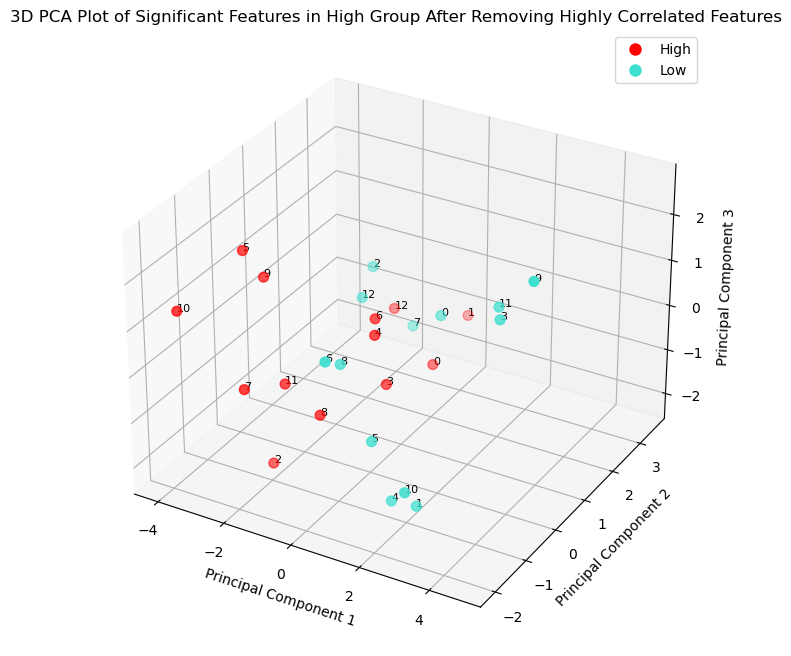

In [53]:
# 3D PCA plot for enhanced visualisation

# Apply PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data_cleaned)

# Create a df with the principal components
pca_df_cleaned = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df_cleaned['Group'] = combined_df['Group']
pca_df_cleaned['ID'] = combined_df['ID']

# Define a custom color palette
custom_palette = {'High': 'red', 'Low': 'turquoise'}
colors = pca_df_cleaned['Group'].map(custom_palette)

# Create a 3D scatter plot for PCA results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_df_cleaned['PC1'], pca_df_cleaned['PC2'], pca_df_cleaned['PC3'], 
                     c=colors, s=50)

# Annotate each point with the sample ID
for i in range(pca_df_cleaned.shape[0]):
    ax.text(pca_df_cleaned.PC1[i], pca_df_cleaned.PC2[i], pca_df_cleaned.PC3[i], 
            s=str(pca_df_cleaned.ID[i]), 
            color='black', size=8, zorder=1)

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Plot of Significant Features in High Group After Removing Highly Correlated Features')

# Legend
high_patch = plt.Line2D([0], [0], marker='o', color='w', label='High', markerfacecolor='red', markersize=10)
low_patch = plt.Line2D([0], [0], marker='o', color='w', label='Low', markerfacecolor='turquoise', markersize=10)
ax.legend(handles=[high_patch, low_patch])


plt.savefig('/home/evannaughton/project/radiomics_code/plots/3d_pca_plot_labeled.png')
plt.show()

In [56]:
# Interactive 3D PCA 

# Apply PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_data_cleaned)

# Create a df with the principal components
pca_df_cleaned = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df_cleaned['Group'] = combined_df['Group']
pca_df_cleaned['ID'] = combined_df['ID']

# Create an interactive 3D scatter plot for the PCA results
fig = px.scatter_3d(pca_df_cleaned, x='PC1', y='PC2', z='PC3', color='Group', text='ID',
                    color_discrete_map={'High': 'red', 'Low': 'turquoise'},
                    title='3D PCA Plot of Significant Features in High Group After Removing Highly Correlated Features')

# Update the layout for better visualization
fig.update_layout(scene=dict(
                    xaxis_title='Principal Component 1',
                    yaxis_title='Principal Component 2',
                    zaxis_title='Principal Component 3'))

fig.show()

Interpretation of PCA plots: 

In the original PCA plot (before removing highly correlated features), there is some degree of separation between the high and low groups, but the clustering is not very distinct.

In the updated PCA plot (after removing highly correlated features), there appears to be better separation and clustering between the high and low groups, although there is still some overlap. This overlap is being caused primarily by the same 4 samples; 2, 7, 12, and 0. It will be interesting to view these samples using other visualisation methods like t-SNE.

Given the small sample size, the updated PCA plot shows a decent amount of clustering. The high and low groups are more distinct, indicating that the removal of highly correlated features has improved the separation of the two groups.

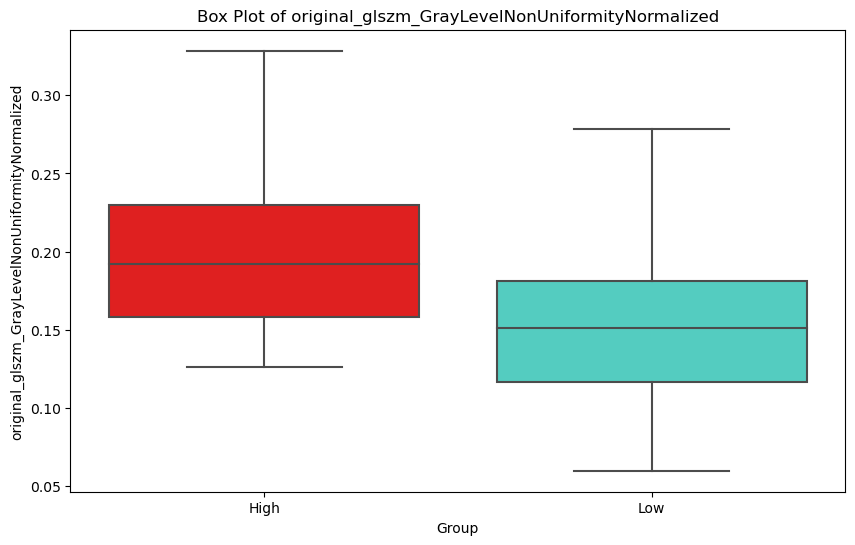

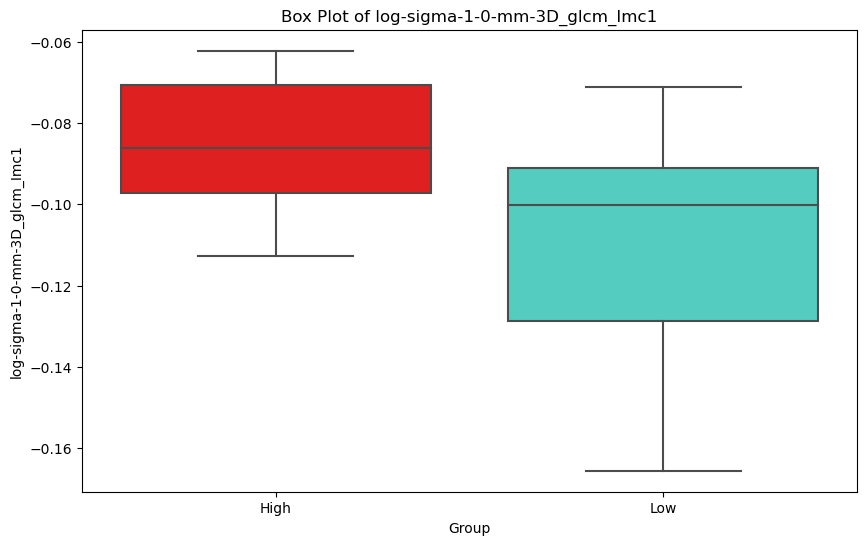

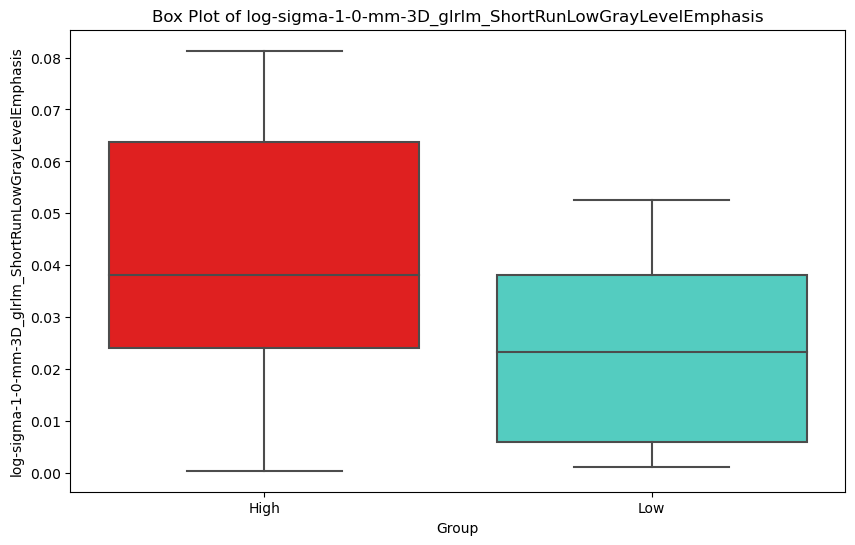

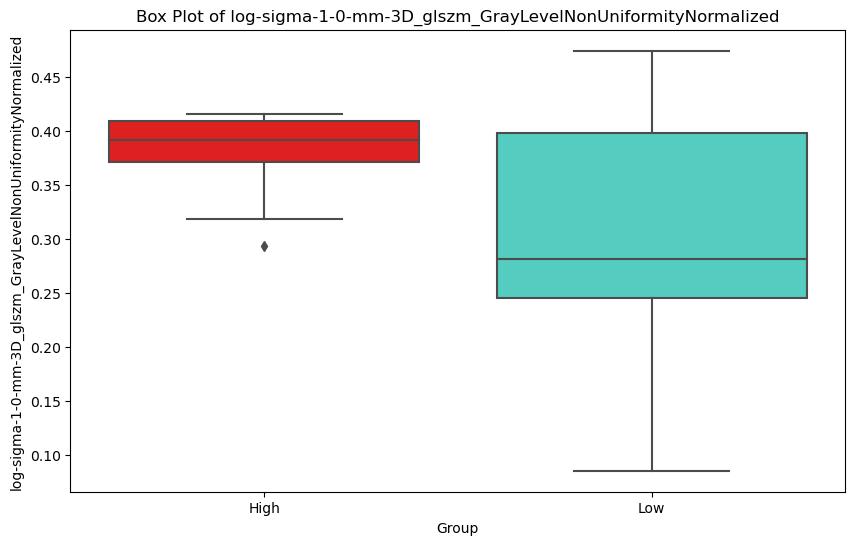

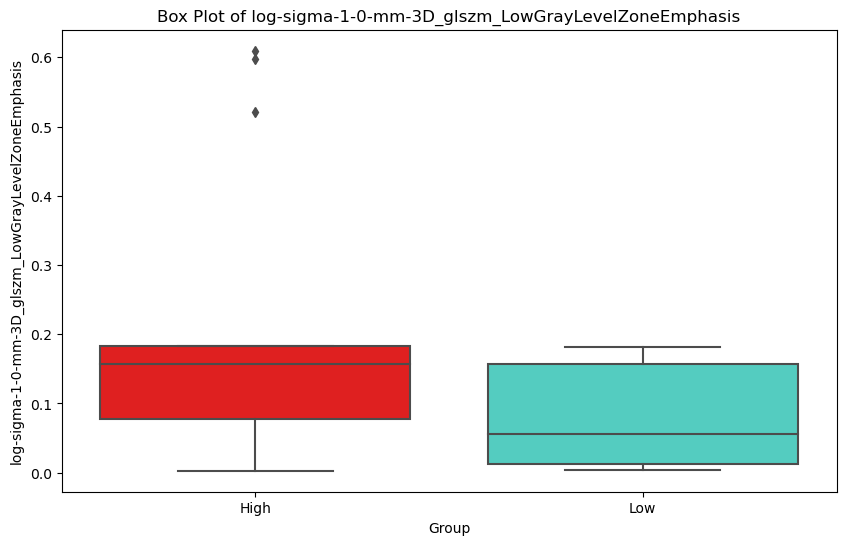

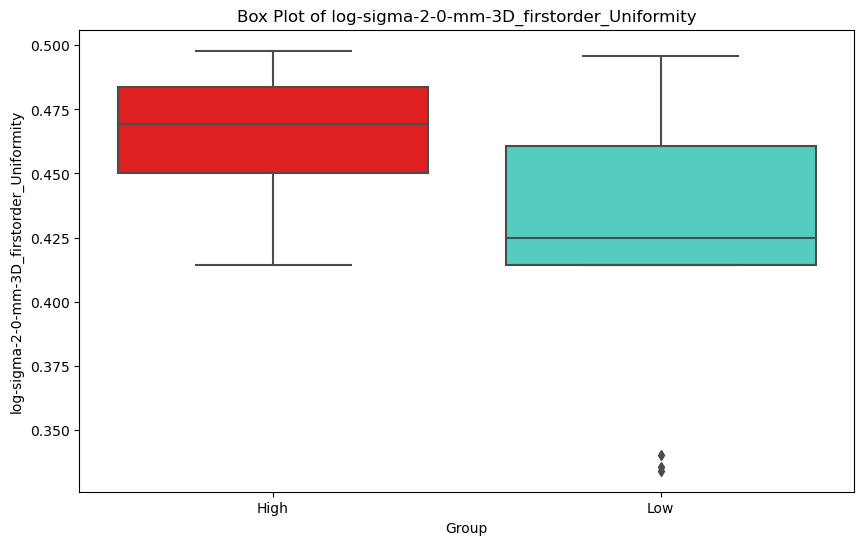

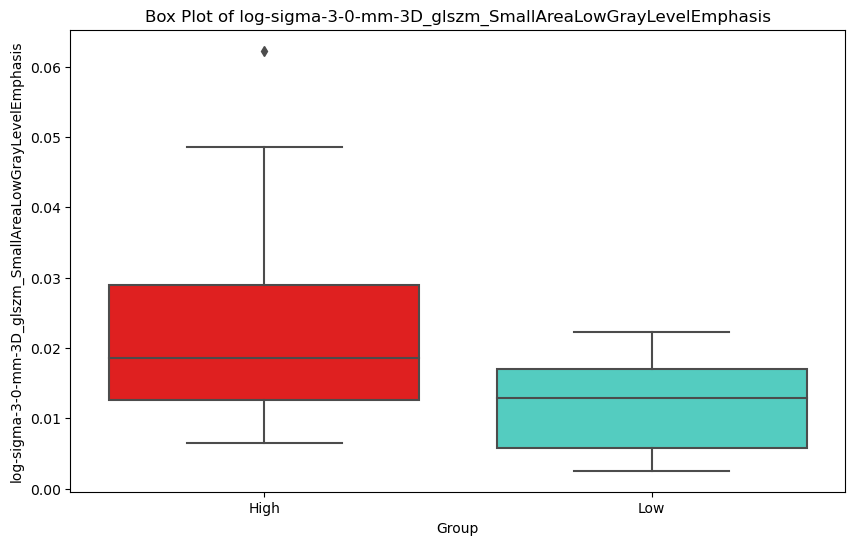

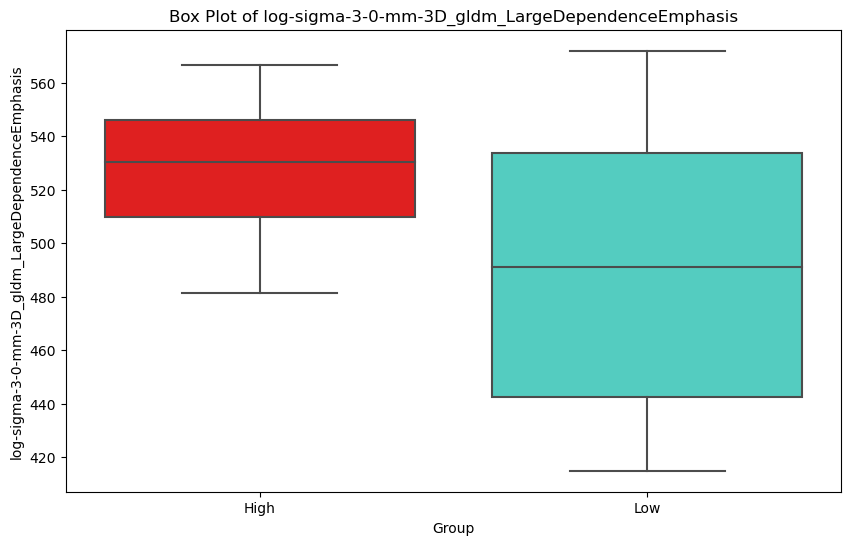

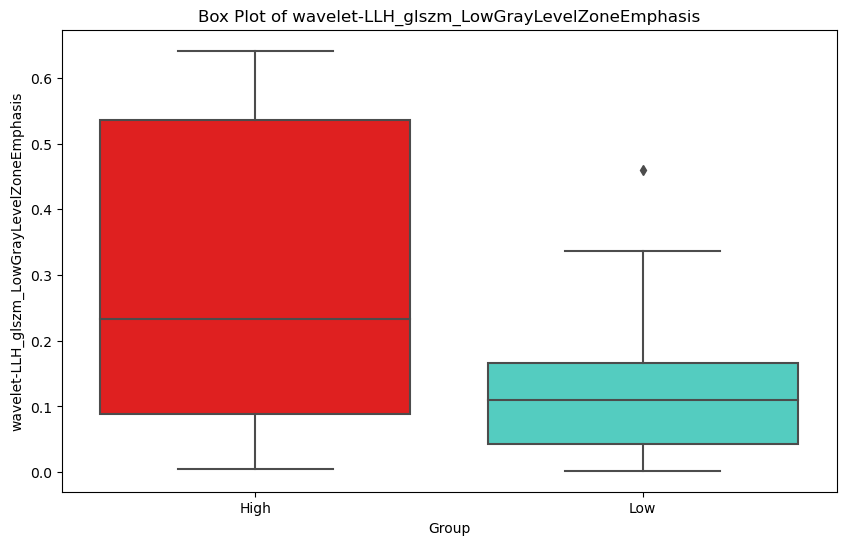

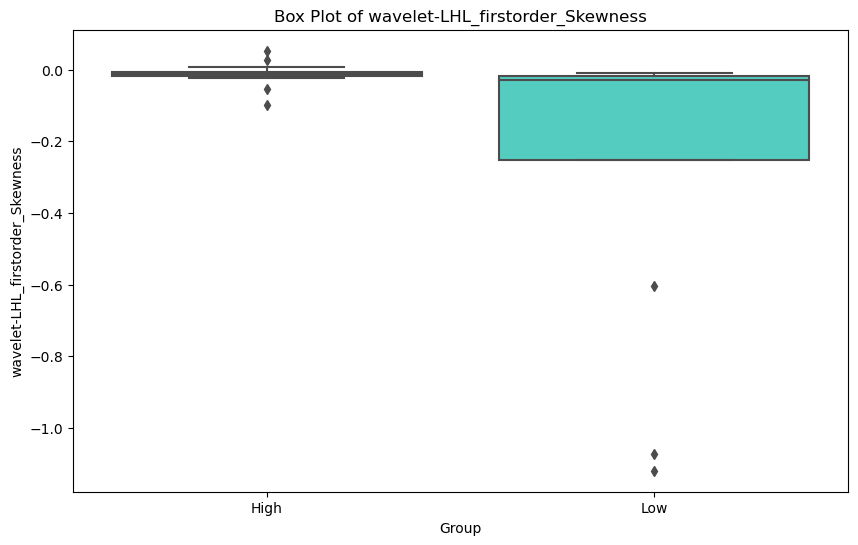

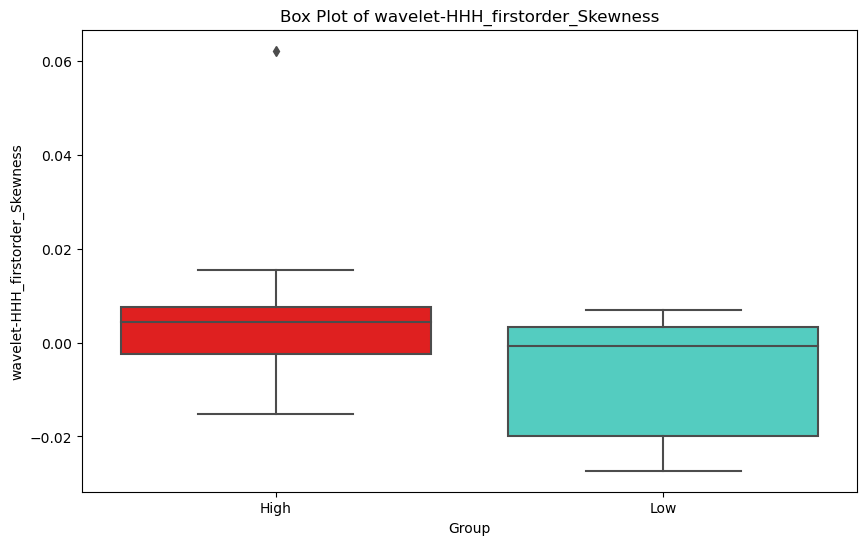

In [52]:
# Boxplots

# Define a custom color palette
custom_palette = {'High': 'red', 'Low': 'turquoise'}

# Create box plots for the remaining features
for feature in combined_df_cleaned.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Group', y=feature, data=combined_df, palette=custom_palette)
    plt.title(f'Box Plot of {feature}')
    plt.show()

Can also try other dimensionality reduction techniques like t-SNE or UMAP for better visualization of clusters, especially with small sample sizes. 

t-SNE (t-distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique used to visualize high-dimensional data by mapping it into two or three dimensions while preserving local relationships. In terms of this study on high-Ki67 index adrenocortical carcinoma, t-SNE helps visualize complex radiomic features, making patterns easier to identify, and revealing clusters and separations between high and low Ki67 index groups. This indicates distinct radiomic signatures, validating whether selected features effectively distinguish between the groups. Complementing PCA, t-SNE provides a non-linear perspective, preserving local structures better. The perplexity parameter in the code influences the balance between the local and global aspects of the data when constructing the lower-dimensional embedding. For the amount of data here, a perplexity value of between 5 and 10 is generally recommended for small datasets.

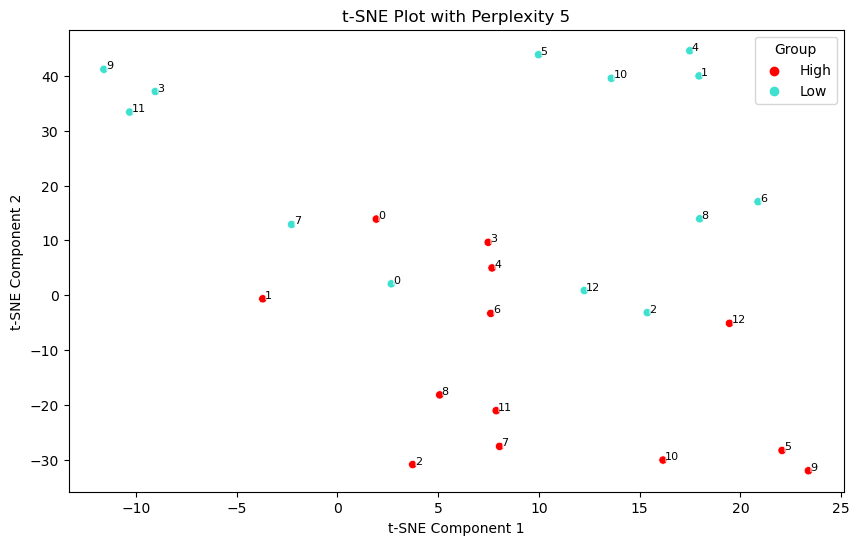

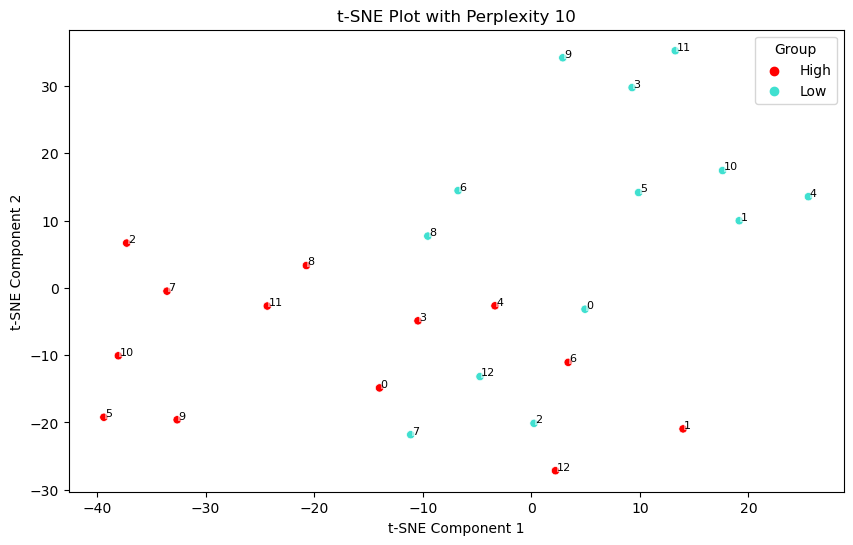

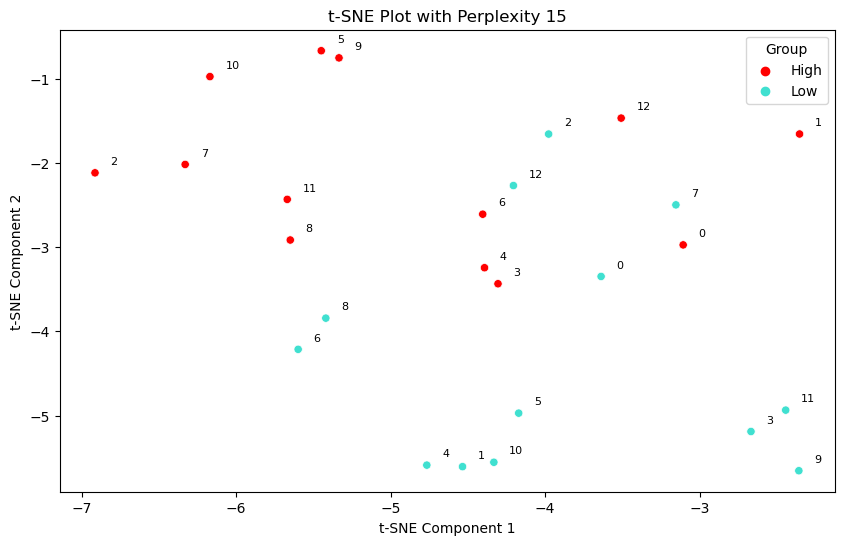

In [57]:
# Define a list of perplexities to try out
perplexities = [5, 10, 15]

# Custom color palette
custom_palette = {'High': 'red', 'Low': 'turquoise'}

# Standardize the cleaned data
scaler = StandardScaler()
scaled_data_cleaned = scaler.fit_transform(combined_df_cleaned)

for perplexity in perplexities:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_components = tsne.fit_transform(scaled_data_cleaned)
    
    # Create a DF with the t-SNE components
    tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2'])
    tsne_df['Group'] = combined_df['Group']
    tsne_df['ID'] = combined_df['ID']  
    
    # scatter plot for the t-SNE results
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(x='TSNE1', y='TSNE2', hue='Group', data=tsne_df, palette=custom_palette)
    plt.title(f't-SNE Plot with Perplexity {perplexity}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    
    # Annotate each point with the sample ID
    for i in range(tsne_df.shape[0]):
        plt.text(x=tsne_df.TSNE1[i]+0.1, y=tsne_df.TSNE2[i]+0.1, s=str(tsne_df.ID[i]), 
                 fontdict=dict(color='black', size=8),
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0))
    
    plt.savefig(f'/home/evannaughton/project/radiomics_code/plots/tsne_plot_perplexity_{perplexity}.png')
    plt.show()

In [58]:
# Define list of perplexities to try
perplexities = [5, 10, 15]

for perplexity in perplexities:
    # 3D t-SNE with the current perplexity
    tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
    tsne_components = tsne.fit_transform(scaled_data_cleaned)
    
    # Create a df with the t-SNE components
    tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2', 'TSNE3'])
    tsne_df['Group'] = combined_df['Group']
    tsne_df['ID'] = combined_df['ID']  
    
    # Create an interactive 3D scatter plot for the t-SNE results
    fig = px.scatter_3d(tsne_df, x='TSNE1', y='TSNE2', z='TSNE3', color='Group', text='ID',
                        color_discrete_map={'High': 'red', 'Low': 'turquoise'},
                        title=f'3D t-SNE Plot with Perplexity {perplexity}')
    
    # Update the layout for better visualization
    fig.update_layout(scene=dict(
                        xaxis_title='t-SNE Component 1',
                        yaxis_title='t-SNE Component 2',
                        zaxis_title='t-SNE Component 3'))

    fig.show()

Perplexity 10 offers better separation of the groups compared to perplexity 5 and perplexity 15.
More distinct clusters are forming, which might indicate a better balance between local and global structure.

Based on the plots, perplexity 10 seems to offer the best balance between local and global structure, providing a clearer separation between the high and low groups. 

An interesting point here is that samples 2, 7, 12 are deeply embedded in the high samples once again, similarly to PCA. This poses questions about the ki-67 histopathological labelling that was carried out on these particular samples and could warrant further analysis. According to the paper by Ahmed et al; "Sections of all resected tissues had been immunostained for the Ki-67 proliferation marker using the MIB-1 antibody clone. Areas with brown nuclear staining were considered positive, while unstained areas were considered negative. The three to four areas with highest positive staining were selected for examination. The Ki-67 index was reported as the percentage of the positively stained nuclei in each area."

We can now incorporate this analysis with some of the clinical variables in the clinical data file.

In [229]:
# Load clinical data
clinical_data_path = '/media/evannaughton/STORE N GO1/project/tcia_data/Adrenal-ACC-Ki67-Seg_SupportingData_20230522.xlsx'
clinical_df = pd.read_excel(clinical_data_path)

# Display the clinical data to check
print(clinical_df.head())

             Patient_ID   Age SEX  studydate                Race PreContrast  \
0  Adrenal_Ki67_Seg_001  58.0   M   20000822  Hispanic or Latino           Y   
1  Adrenal_Ki67_Seg_002  59.0   F   20010925               White           Y   
2  Adrenal_Ki67_Seg_003  44.0   F   20031014               White           Y   
3  Adrenal_Ki67_Seg_004  52.0   M   20040628               White           Y   
4  Adrenal_Ki67_Seg_005  57.0   F   20050104               White           Y   

  Venous Delayed Laterality  PathTumorSize  ...  Lymph_node_PATHOLOGY   \
0      Y       N      Right           11.2  ...                     NX   
1      Y       Y      Right            9.0  ...                     NX   
2      Y       N      Right            9.0  ...                     NX   
3      Y       Y       Left           16.5  ...                     NX   
4      Y       Y       Left            8.0  ...                     N0   

  MetsFutureSite FutureMets_Liver FutureMets_Lymph_nodes FutureMets_Bone  

In [230]:
# List of patient IDs in the same order as the extracted features
patient_ids_high = ['Adrenal_Ki67_Seg_012', 'Adrenal_Ki67_Seg_013', 'Adrenal_Ki67_Seg_016', 'Adrenal_Ki67_Seg_017', 'Adrenal_Ki67_Seg_021', 'Adrenal_Ki67_Seg_024', 'Adrenal_Ki67_Seg_028', 'Adrenal_Ki67_Seg_033', 'Adrenal_Ki67_Seg_035', 'Adrenal_Ki67_Seg_038', 'Adrenal_Ki67_Seg_039', 'Adrenal_Ki67_Seg_044', 'Adrenal_Ki67_Seg_052']  
patient_ids_low = ['Adrenal_Ki67_Seg_001', 'Adrenal_Ki67_Seg_005', 'Adrenal_Ki67_Seg_006', 'Adrenal_Ki67_Seg_009', 'Adrenal_Ki67_Seg_015', 'Adrenal_Ki67_Seg_018', 'Adrenal_Ki67_Seg_029', 'Adrenal_Ki67_Seg_026', 'Adrenal_Ki67_Seg_031', 'Adrenal_Ki67_Seg_034', 'Adrenal_Ki67_Seg_036', 'Adrenal_Ki67_Seg_043', 'Adrenal_Ki67_Seg_048']  

# Adding patient IDs to the high group DataFrame
high_group_df['Patient_ID'] = patient_ids_high

# Adding patient IDs to the low group DataFrame
low_group_df['Patient_ID'] = patient_ids_low

# Combine both DataFrames for further analysis
combined_df = pd.concat([high_group_df, low_group_df], ignore_index=True)

# Merge the radiomics features with clinical data
merged_df = pd.merge(combined_df, clinical_df, on='Patient_ID')

# Display the merged DataFrame to check
print(merged_df)

   diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                            v3.0.1                     1.24.3   
1                            v3.0.1                     1.24.3   
2                            v3.0.1                     1.24.3   
3                            v3.0.1                     1.24.3   
4                            v3.0.1                     1.24.3   
5                            v3.0.1                     1.24.3   
6                            v3.0.1                     1.24.3   
7                            v3.0.1                     1.24.3   
8                            v3.0.1                     1.24.3   
9                            v3.0.1                     1.24.3   
10                           v3.0.1                     1.24.3   
11                           v3.0.1                     1.24.3   
12                           v3.0.1                     1.24.3   
13                           v3.0.1                     1.24.3   
14        

I can now can explore the correlation between the significant radiomic features and clinical parameters by performing statistical tests or calculating correlation coefficients to see if any of the radiomic features are associated with clinical outcomes.

Feature: original_glszm_GrayLevelNonUniformityNormalized, Correlation: 0.3922138700784752, p-value: 0.047504811308989904
Feature: log-sigma-1-0-mm-3D_glcm_Imc1, Correlation: -0.08632401394033859, p-value: 0.6749938889434547
Feature: log-sigma-1-0-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis, Correlation: 0.09666451986324077, p-value: 0.6385294412462272
Feature: log-sigma-1-0-mm-3D_glszm_GrayLevelNonUniformityNormalized, Correlation: 0.05711964620120644, p-value: 0.7816602119072047
Feature: log-sigma-1-0-mm-3D_glszm_LowGrayLevelZoneEmphasis, Correlation: 0.34238635537682244, p-value: 0.08686695159759282
Feature: log-sigma-2-0-mm-3D_firstorder_Uniformity, Correlation: 0.40452177300987846, p-value: 0.04038639978283261
Feature: log-sigma-3-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis, Correlation: -0.1546641189333803, p-value: 0.4506052314808547
Feature: log-sigma-3-0-mm-3D_gldm_LargeDependenceEmphasis, Correlation: 0.6284462098276558, p-value: 0.0005858606012207992
Feature: wavelet-LLH_glszm_L

/home/evannaughton/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_9613/1567461824.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


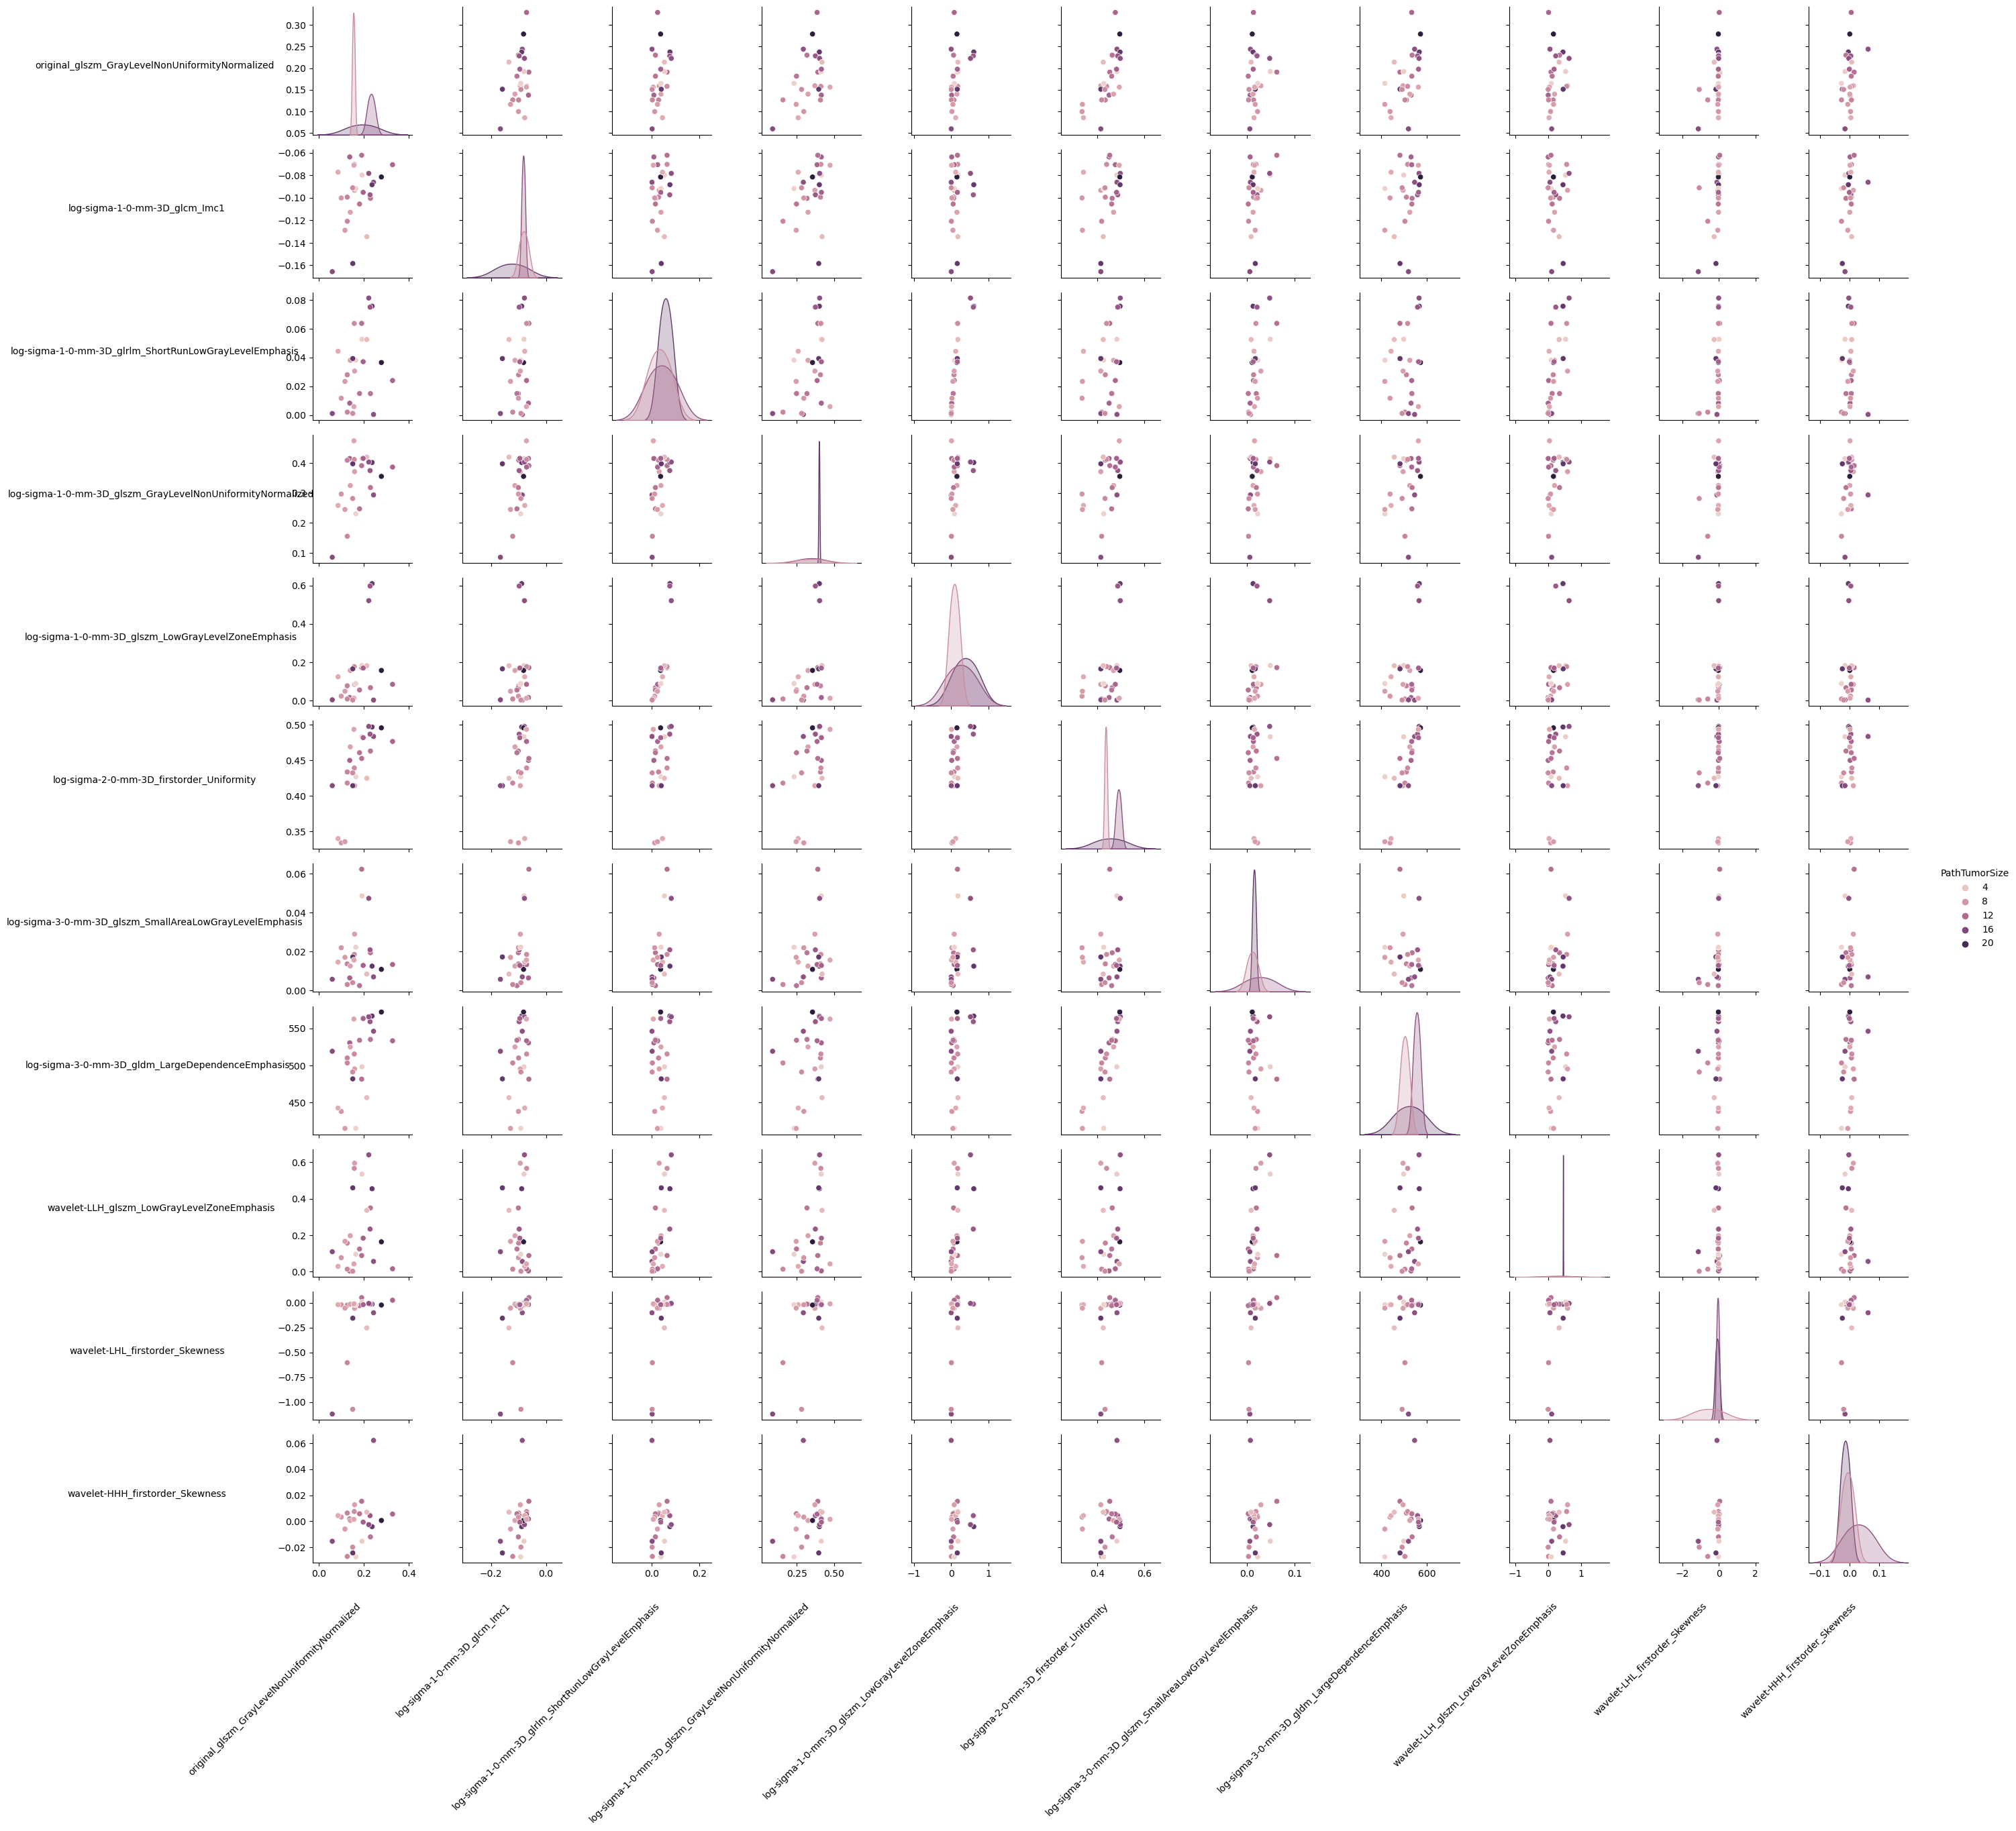

In [231]:
# PathTumorSize is the only continuous variable in the clinical data

# Correlation of radiomic features with PathTumorSize
for feature in combined_df_cleaned.columns:
    correlation, p_value = stats.pearsonr(combined_df_cleaned[feature], merged_df['PathTumorSize'])
    print(f'Feature: {feature}, Correlation: {correlation}, p-value: {p_value}')

# Visualization
pairplot = sns.pairplot(merged_df, vars=combined_df_cleaned.columns, hue='PathTumorSize')

# Adjust y-axis label padding
for ax in pairplot.axes.flatten():
    ax.set_ylabel(ax.get_ylabel(), labelpad=140, rotation=0)  # Adjust labelpad as needed

# Rotate x-axis labels to be at a 45-degree angle and align them with the middle of their respective plots
for ax in pairplot.axes[-1, :]:
    ax.set_xlabel(ax.get_xlabel(), rotation=45, ha='right')
    ax.xaxis.set_label_coords(0.5, -0.3)
    
# Move legend
pairplot._legend.set_bbox_to_anchor((1.05, 0.5))
pairplot._legend.set_title('PathTumorSize')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig(f'/home/evannaughton/project/radiomics_code/plots/significantfeaturesVpathtumorsize.png', format='png', dpi=250, bbox_inches='tight')
plt.show()

This is not wholely useful as radiomic features would not generally be needed to estimate tumour size if tumour size can be clearly determined just by looking at the CT scan. This just shows that if additional continuous variables were available within the clinical data, it would be possible to determine correlations between continuous clinical variables and significant radiomic features.

Feature: wavelet-HHH_firstorder_Skewness, F-statistic: 4.397611757611652, P-value: 0.014379220124015124


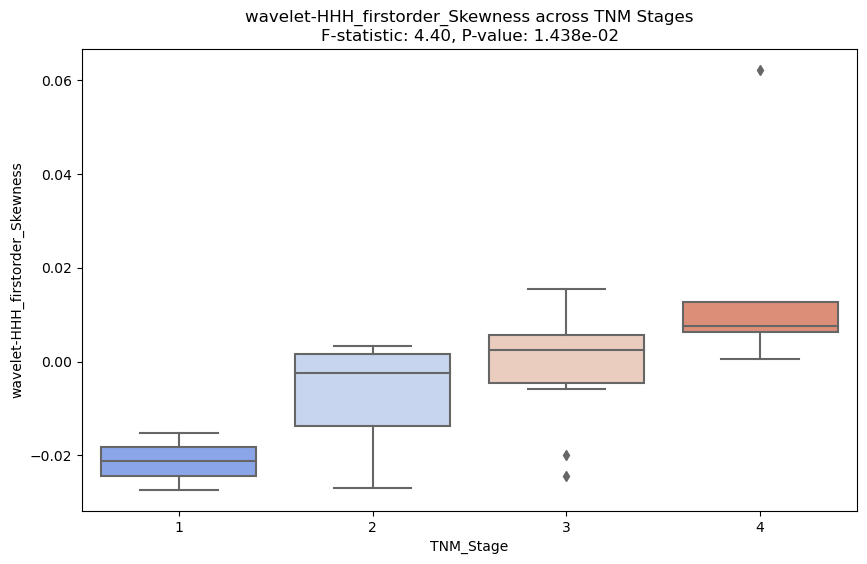

In [232]:
# significant radiomic features vs. TNM Stage

significant_features_anova = []

for feature in combined_df_cleaned.columns:
    if feature not in ['Patient_ID', 'Group']:  
        groups = [merged_df[merged_df['TNM_Stage'] == stage][feature] for stage in merged_df['TNM_Stage'].unique()]
        f_stat, p_val = stats.f_oneway(*groups)
        if p_val < 0.05:  
            significant_features_anova.append((feature, f_stat, p_val))
            print(f'Feature: {feature}, F-statistic: {f_stat}, P-value: {p_val}')

# Visualisation
for feature, f_stat, p_val in significant_features_anova:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='TNM_Stage', y=feature, data=merged_df, palette='coolwarm')
    plt.title(f'{feature} across TNM Stages\nF-statistic: {f_stat:.2f}, P-value: {p_val:.3e}')
    plt.savefig(f'/home/evannaughton/project/radiomics_code/plots/skewnessvsTNMstage.png', format='png', dpi=250)
    plt.show()

'wavelet-HHH_firstorder_Skewness' is the only radiomic feature (statistically significant in the high Ki-67 group) found to be statistically significant (p-value < 0.05) across the TNM stages using the ANOVA test. This means that there is a statistically significant difference in the distribution of this feature among different TNM stages.

Unfortunately there is no survival data within the accompanying clinical data from TCIA. There is only DaysToDiagnosis and TTPCensor.

In [233]:
# Define the order of the T-staging categories
merged_df['TStaging'] = pd.Categorical(merged_df['TStaging'], categories=['T1', 'T2', 'T3', 'T4'], ordered=True)

# Significant features ANOVA for T-staging
significant_features_anova_T = []

for feature in combined_df_cleaned.columns:
    if feature not in ['Patient_ID', 'Group']:
        groups = [merged_df[merged_df['TStaging'] == stage][feature] for stage in merged_df['TStaging'].unique()]
        f_stat, p_val = stats.f_oneway(*groups)
        if p_val < 0.05:
            significant_features_anova_T.append((feature, f_stat, p_val))
            print(f'Feature: {feature}, F-statistic: {f_stat}, P-value: {p_val:.3e}')

# Visualization
for feature, f_stat, p_val in significant_features_anova_T:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='TStaging', y=feature, data=merged_df, palette='coolwarm')
    plt.title(f'{feature} across T Stages\nF-statistic: {f_stat:.2f}, P-value: {p_val:.3e}')
    plt.show()

Feature: wavelet-HHH_firstorder_Skewness, F-statistic: 8.784471837664443, P-value: 6.761e-03


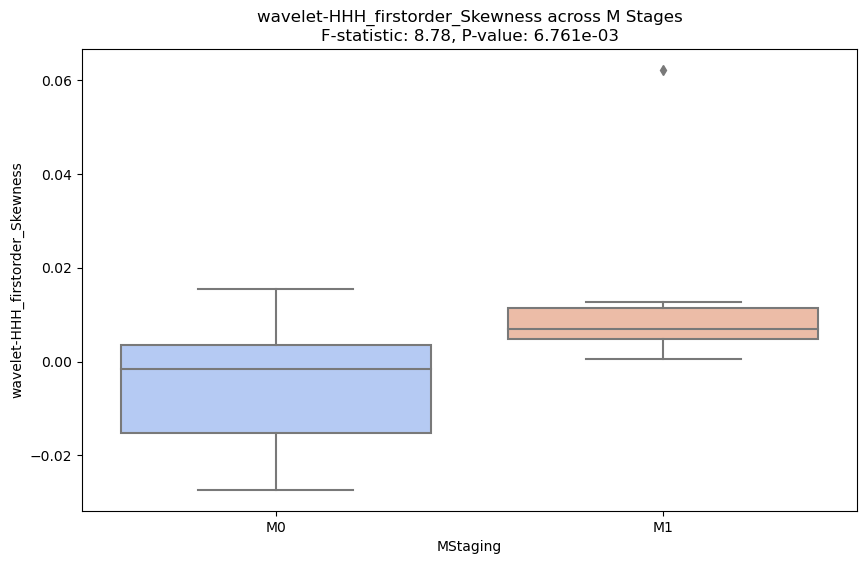

In [234]:
# Perform ANOVA for M Staging
significant_features_anova_M = []

for feature in combined_df_cleaned.columns:
    if feature not in ['Patient_ID', 'Group']:
        groups = [merged_df[merged_df['MStaging'] == stage][feature] for stage in merged_df['MStaging'].unique()]
        f_stat, p_val = stats.f_oneway(*groups)
        if p_val < 0.05:
            significant_features_anova_M.append((feature, f_stat, p_val))
            print(f'Feature: {feature}, F-statistic: {f_stat}, P-value: {p_val:.3e}')

# Visualization
for feature, f_stat, p_val in significant_features_anova_M:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='MStaging', y=feature, data=merged_df, palette='coolwarm')
    plt.title(f'{feature} across M Stages\nF-statistic: {f_stat:.2f}, P-value: {p_val:.3e}')
    plt.savefig(f'/home/evannaughton/project/radiomics_code/plots/skewnessvsMstaging.png', format='png', dpi=250)
    plt.show()

The 11 radiomic features above have the potential to be used to train a model to predict high Ki-67 and poor prognosis in ACC, with specific features such as wavelet-HHH_firstorder_Skewness being particularly correlated with higher TNM stages (particularly M stage as shown above). We can now carry out a multivariate analysis to understand the combined effect of these radiomic features and clinical variables on patient outcomes.

In [235]:
# Multivariate Analysis 
# (logistic regression with significant radiomic features as independent variables)
# (group (high/low) as the dependent variable)

# Ensure 'Group' is binary
merged_df['Group_binary'] = merged_df['Group'].map({'Low': 0, 'High': 1})

# Define dependent and independent variables
X = merged_df[['original_glszm_GrayLevelNonUniformityNormalized', 'log-sigma-1-0-mm-3D_glcm_Imc1', 'log-sigma-1-0-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis', 'log-sigma-1-0-mm-3D_glszm_GrayLevelNonUniformityNormalized', 'log-sigma-1-0-mm-3D_glszm_LowGrayLevelZoneEmphasis', 'log-sigma-2-0-mm-3D_firstorder_Uniformity', 'log-sigma-3-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis', 'log-sigma-3-0-mm-3D_gldm_LargeDependenceEmphasis', 'wavelet-LLH_glszm_LowGrayLevelZoneEmphasis', 'wavelet-LHL_firstorder_Skewness', 'wavelet-HHH_firstorder_Skewness']]  
y = merged_df['Group_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create & train the model
model = LogisticRegression(max_iter=10000)  
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# Display model coefficients
coefficients = pd.DataFrame(model.coef_.T, X.columns, columns=['Coefficient'])
print(coefficients)

Accuracy: 0.8333333333333334
Confusion Matrix:
[[2 0]
 [1 3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.75      0.86         4

    accuracy                           0.83         6
   macro avg       0.83      0.88      0.83         6
weighted avg       0.89      0.83      0.84         6

                                                    Coefficient
original_glszm_GrayLevelNonUniformityNormalized        0.128876
log-sigma-1-0-mm-3D_glcm_Imc1                          0.074610
log-sigma-1-0-mm-3D_glrlm_ShortRunLowGrayLevelE...     0.056448
log-sigma-1-0-mm-3D_glszm_GrayLevelNonUniformit...     0.130484
log-sigma-1-0-mm-3D_glszm_LowGrayLevelZoneEmphasis     0.296054
log-sigma-2-0-mm-3D_firstorder_Uniformity              0.086285
log-sigma-3-0-mm-3D_glszm_SmallAreaLowGrayLevel...     0.065140
log-sigma-3-0-mm-3D_gldm_LargeDependenceEmphasis       0.016015
wavelet-LLH_

Interpretation of results:
    
The logistic regression model achieves an accuracy of 83.33%, effectively distinguishing between high and low Ki-67 classes. The model shows high precision and recall for the high Ki-67 class, indicating robust performance. Key features like wavelet-LHL_firstorder_Skewness and wavelet-LLH_glszm_LowGrayLevelZoneEmphasis significantly influence the predictions. The confusion matrix reveals that the model predicts the high Ki-67 class with perfect precision but misses one instance of the low Ki-67 class. Overall, the model's performance and identified significant features provide a solid foundation for further refinement and insights into class differentiation.

I have created a document in RStudio with further analysis of these results (Radiomics.Rmd). Due to the small sample size, features were standardized in RStudio, and the 10-fold cross validation least absolute shrinkage and selection operator (10-fold CV LASSO) cox regression model with “glmnet” R package was used to select significant features from high-dimensional data. The significant variables were then combined into a radiomic index (RDindex) by linearly adding up weighed by their respective coefficients. This also produced a set of radiomic features also distinguishing Ki-67 extremes (not just having a higher value in the high group as seen in the analysis above).  